# Summery
### Лучший результат на степике получлся с помощью ручного стекинга трех моделей 
### c_b, ctboost_22, model_22 (я взял их предсказания и выдал среднее арифметическое)
### это на 21.07.2023 - дальше хз как повышать score на kaggle - пока 404 место и 0.85364
### Staking logreg, svm, decision tree, randomforest не дал хороших результатов
### 

In [1]:
import numpy  as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics         import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing   import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

from catboost import CatBoostClassifier

# Загрузка данных

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [414]:
data = pd.read_csv('./train.csv')

In [3]:
print(f'{data.shape}')
data.sample(3)

(5282, 20)


ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
1033             1            91.70       91.7  Female                0   
1210             1            84.85      84.85    Male                0   
2061            62            56.15    3487.95    Male                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
1033         No       No             Yes                      No   
1210         No       No             Yes                      No   
2061         No      Yes             Yes                      No   

     HasInternetService HasOnlineSecurityService HasOnlineBackup  \
1033        Fiber optic                       No             Yes   
1210        Fiber optic                       No              No   
2061                DSL                      Yes             Yes   

     HasDeviceProtection HasTechSupportAccess HasOnlineTV  \
1033                  No                  Yes         Yes   
1210                 Yes                   No         Yes   
2061                  No                   No          No   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
1033                   No   Month-to-month                 No   
1210                   No   Month-to-month                Yes   
2061                   No         One year                 No   

                  PaymentMethod  Churn  
1033           Electronic check      1  
1210           Electronic check      1  
2061  Bank transfer (automatic)      0

In [552]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### In 'TotalSpent' there is some ' ' row. Next block fix it.
#### 1) Find the indexes of this row
#### 2) Replase the valuse

In [415]:
ind = data[data['TotalSpent'] == ' '].index

data.loc[(ind), 'TotalSpent'] = data.loc[(ind), 'MonthlySpending']

data = data.astype({'ClientPeriod':'uint8', 'TotalSpent':'float64', 'IsSeniorCitizen':'int8',
                    'IsSeniorCitizen':'uint8'})

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   uint8  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   uint8  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [9]:
data.head(3)

ClientPeriod  MonthlySpending  TotalSpent   Sex  IsSeniorCitizen  \
0            55            19.50     1026.35  Male                0   
1            72            25.85     1872.20  Male                0   
2             1            75.90       75.90  Male                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0        Yes      Yes             Yes                      No   
1        Yes       No             Yes                     Yes   
2         No       No             Yes                      No   

  HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
0                 No      No internet service  No internet service   
1                 No      No internet service  No internet service   
2        Fiber optic                       No                   No   

   HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
0  No internet service  No internet service  No internet service   
1  No internet service  No internet service  No internet service   
2                   No                  Yes                   No   

  HasMovieSubscription HasContractPhone IsBillingPaperless  \
0  No internet service         One year                 No   
1  No internet service         Two year                 No   
2                   No   Month-to-month                Yes   

             PaymentMethod  Churn  
0             Mailed check      0  
1  Credit card (automatic)      0  
2         Electronic check      1

In [10]:
data.groupby(['HasContractPhone', 'Churn'])['Churn'].count()

HasContractPhone  Churn
Month-to-month    0        1689
                  1        1231
One year          0         962
                  1         120
Two year          0        1247
                  1          33
Name: Churn, dtype: int64

In [11]:
data.groupby(['HasInternetService', 'Churn'])['Churn'].count()

HasInternetService  Churn
DSL                 0        1458
                    1         342
Fiber optic         0        1381
                    1         960
No                  0        1059
                    1          82
Name: Churn, dtype: int64

In [12]:
data.groupby(['PaymentMethod', 'Churn'])['Churn'].count()/5282

PaymentMethod              Churn
Bank transfer (automatic)  0        0.182507
                           1        0.036918
Credit card (automatic)    0        0.185157
                           1        0.031238
Electronic check           0        0.187808
                           1        0.150322
Mailed check               0        0.182507
                           1        0.043544
Name: Churn, dtype: float64

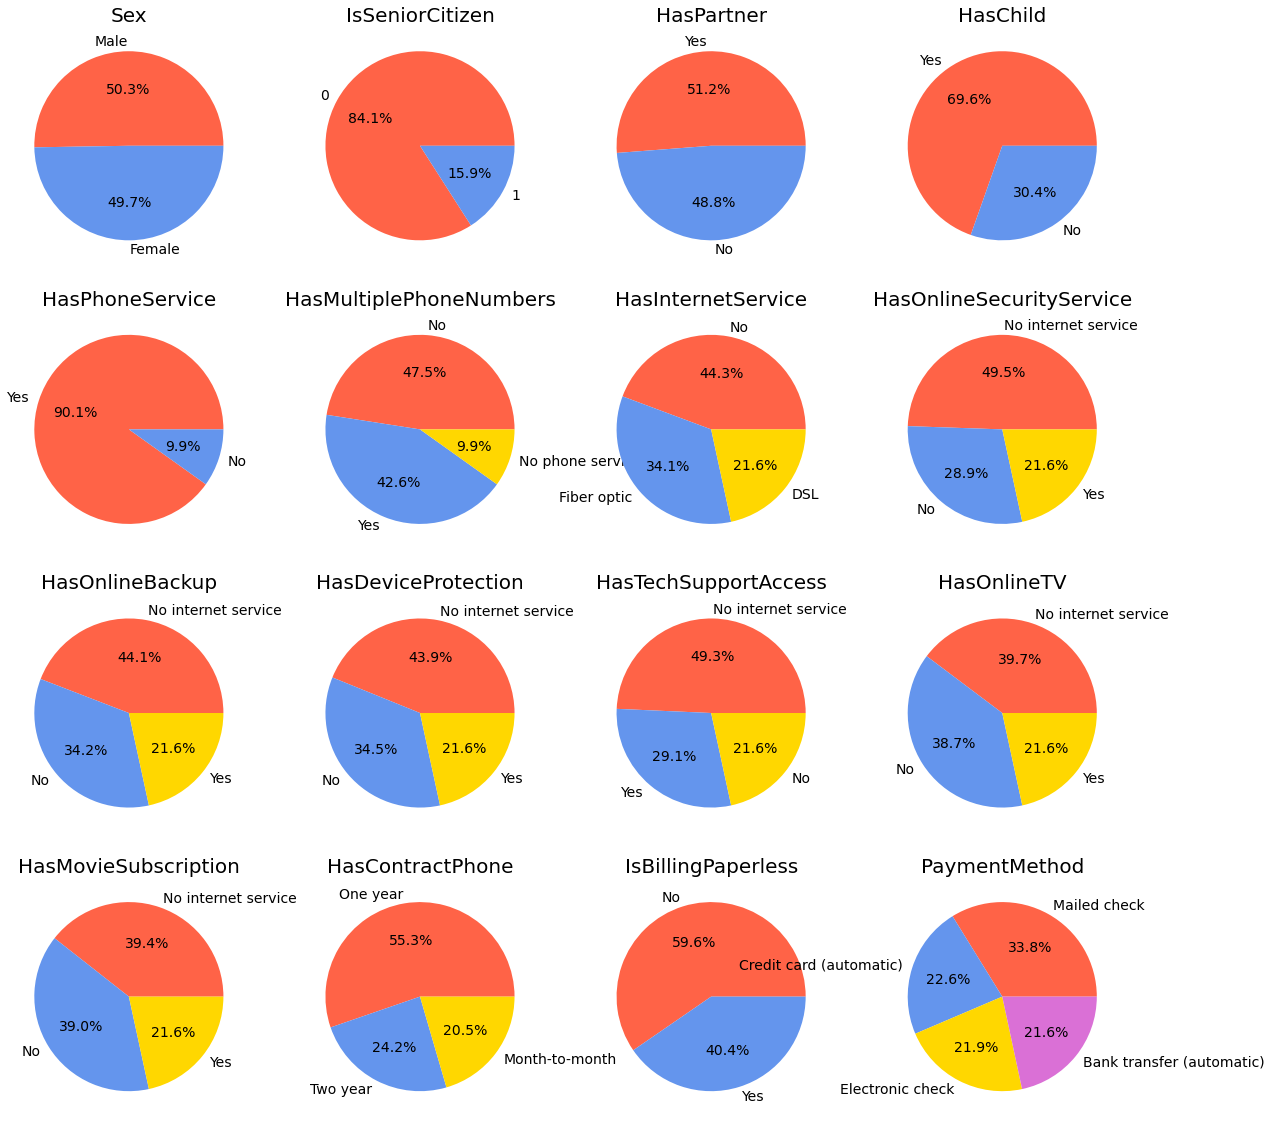

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    ax[i].pie(data[col].value_counts(), textprops={'fontsize': 14}, labels=data[col].unique(), autopct='%1.1f%%',
              colors=['tomato', 'cornflowerblue', 'gold', 'orchid', 'green'])
    ax[i].set_title(col, fontsize = 20)

In [416]:
data = data.replace({
    "Male":1, "Female":0, 
    "Yes":1,  "No":0, 
    "No phone service":0, 
    "No internet service":0,
    "Fiber optic":1, "DSL":1})

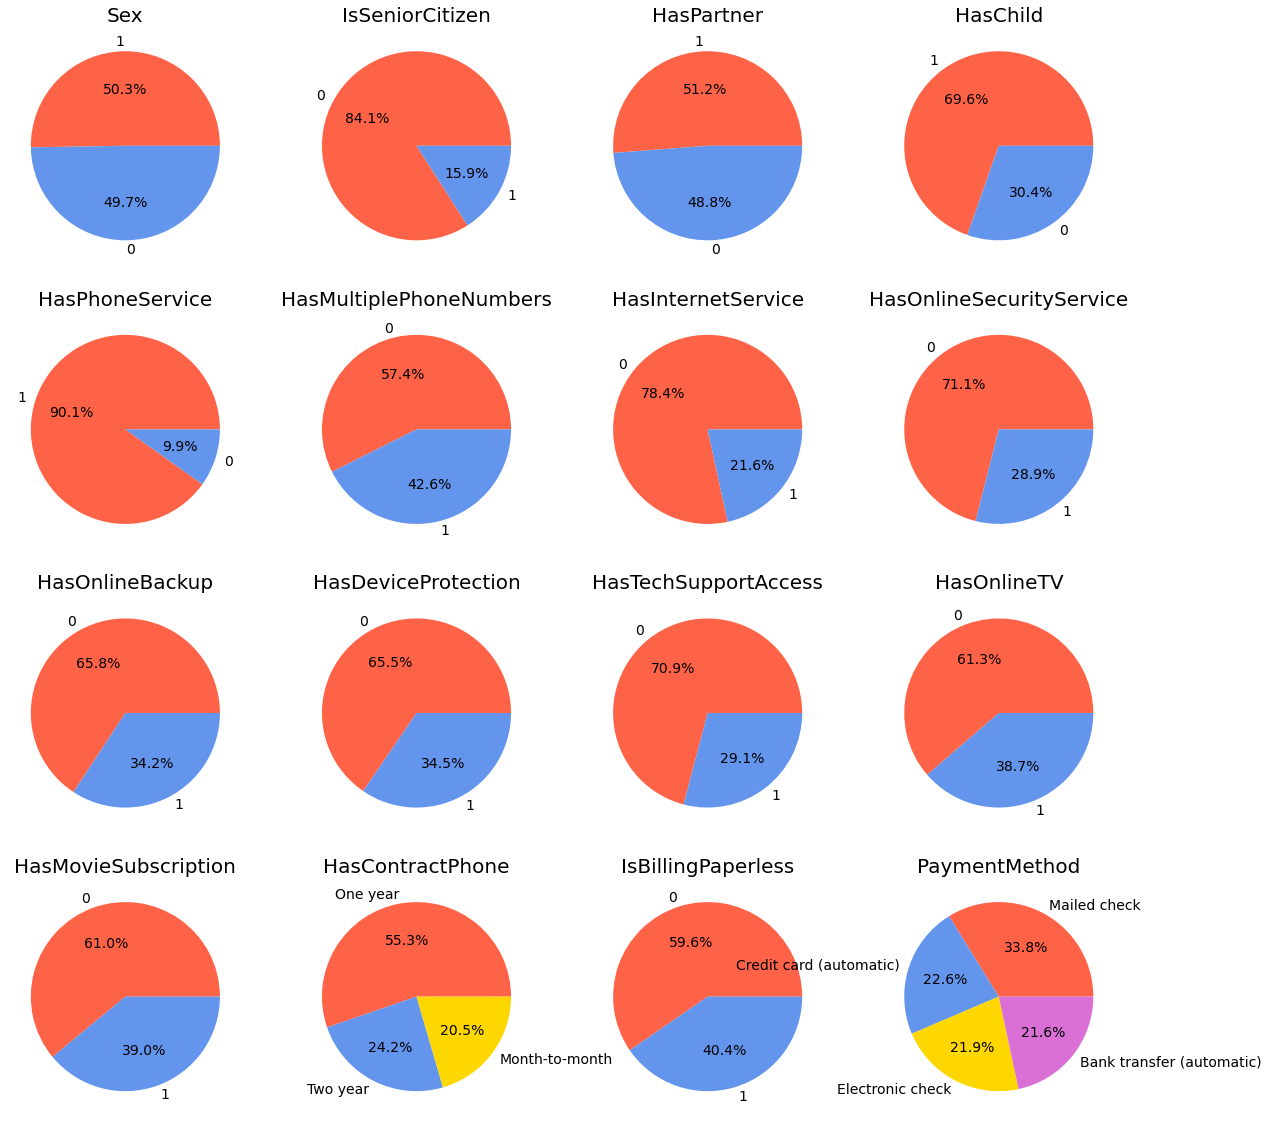

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    ax[i].pie(data[col].value_counts(), textprops={'fontsize': 14}, labels=data[col].unique(), autopct='%1.1f%%',
              colors=['tomato', 'cornflowerblue', 'gold', 'orchid', 'green'])
    ax[i].set_title(col, fontsize = 20)

In [417]:
data = pd.concat([data, pd.get_dummies(data.HasContractPhone)], axis=1)
data.drop(columns = ['HasContractPhone'], inplace=True)

In [17]:
print(f'Shape is : {data.shape}')
data.head(3)

Shape is : (5282, 22)


ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
0            55            19.50     1026.35    1                0   
1            72            25.85     1872.20    1                0   
2             1            75.90       75.90    1                0   

   HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0           1         1                1                        0   
1           1         0                1                        1   
2           0         0                1                        0   

   HasInternetService  ...  HasDeviceProtection  HasTechSupportAccess  \
0                   0  ...                    0                     0   
1                   0  ...                    0                     0   
2                   1  ...                    0                     1   

   HasOnlineTV  HasMovieSubscription  IsBillingPaperless  \
0            0                     0                   0   
1            0                     0                   0   
2            0                     0                   1   

             PaymentMethod  Churn Month-to-month  One year  Two year  
0             Mailed check      0              0         1         0  
1  Credit card (automatic)      0              0         0         1  
2         Electronic check      1              1         0         0  

[3 rows x 22 columns]

In [418]:
data = pd.concat([data, pd.get_dummies(data.PaymentMethod)], axis=1)
data.drop(columns = ['PaymentMethod'], inplace=True)

In [19]:
print(f'Shape is : {data.shape}')
data.head(3)

Shape is : (5282, 25)


ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
0            55            19.50     1026.35    1                0   
1            72            25.85     1872.20    1                0   
2             1            75.90       75.90    1                0   

   HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0           1         1                1                        0   
1           1         0                1                        1   
2           0         0                1                        0   

   HasInternetService  ...  HasMovieSubscription  IsBillingPaperless  Churn  \
0                   0  ...                     0                   0      0   
1                   0  ...                     0                   0      0   
2                   1  ...                     0                   1      1   

   Month-to-month  One year  Two year  Bank transfer (automatic)  \
0               0         1         0                          0   
1               0         0         1                          0   
2               1         0         0                          0   

   Credit card (automatic)  Electronic check  Mailed check  
0                        0                 0             1  
1                        1                 0             0  
2                        0                 1             0  

[3 rows x 25 columns]

In [20]:
data.sample(5)

ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
3337             1            20.05       20.05    0                0   
3086            30           100.40     2936.25    1                0   
791             23            40.10      857.75    1                0   
1180            34            75.55     2425.40    1                1   
2159            10            95.25     1021.55    1                0   

      HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
3337           1         1                1                        0   
3086           0         0                1                        1   
791            0         1                0                        0   
1180           1         0                1                        1   
2159           0         0                1                        1   

      HasInternetService  ...  HasMovieSubscription  IsBillingPaperless  \
3337                   0  ...                     0                   0   
3086                   1  ...                     1                   1   
791                    1  ...                     0                   0   
1180                   1  ...                     0                   1   
2159                   1  ...                     1                   1   

      Churn  Month-to-month  One year  Two year  Bank transfer (automatic)  \
3337      0               1         0         0                          0   
3086      0               1         0         0                          1   
791       0               0         0         1                          0   
1180      0               1         0         0                          0   
2159      0               1         0         0                          0   

      Credit card (automatic)  Electronic check  Mailed check  
3337                        0                 0             1  
3086                        0                 0             0  
791                         0                 0             1  
1180                        0                 1             0  
2159                        0                 1             0  

[5 rows x 25 columns]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClientPeriod               5282 non-null   uint8  
 1   MonthlySpending            5282 non-null   float64
 2   TotalSpent                 5282 non-null   float64
 3   Sex                        5282 non-null   int64  
 4   IsSeniorCitizen            5282 non-null   uint8  
 5   HasPartner                 5282 non-null   int64  
 6   HasChild                   5282 non-null   int64  
 7   HasPhoneService            5282 non-null   int64  
 8   HasMultiplePhoneNumbers    5282 non-null   int64  
 9   HasInternetService         5282 non-null   int64  
 10  HasOnlineSecurityService   5282 non-null   int64  
 11  HasOnlineBackup            5282 non-null   int64  
 12  HasDeviceProtection        5282 non-null   int64  
 13  HasTechSupportAccess       5282 non-null   int64

In [419]:
data = data.astype(dict.fromkeys(data.columns[3:], 'uint8'))

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClientPeriod               5282 non-null   uint8  
 1   MonthlySpending            5282 non-null   float64
 2   TotalSpent                 5282 non-null   float64
 3   Sex                        5282 non-null   uint8  
 4   IsSeniorCitizen            5282 non-null   uint8  
 5   HasPartner                 5282 non-null   uint8  
 6   HasChild                   5282 non-null   uint8  
 7   HasPhoneService            5282 non-null   uint8  
 8   HasMultiplePhoneNumbers    5282 non-null   uint8  
 9   HasInternetService         5282 non-null   uint8  
 10  HasOnlineSecurityService   5282 non-null   uint8  
 11  HasOnlineBackup            5282 non-null   uint8  
 12  HasDeviceProtection        5282 non-null   uint8  
 13  HasTechSupportAccess       5282 non-null   uint8

In [24]:
data.sample(16)

ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
2002            20            68.90     1370.35    0                0   
743             72            63.80     4684.30    0                0   
2115             7            58.85      465.70    1                0   
4246            40           101.85     4086.30    1                1   
392             10            62.25      612.95    1                0   
2981            23            55.80     1327.85    0                0   
1397            26            49.50     1265.65    0                0   
3494             7            81.10      576.65    0                0   
3583             1            19.50       19.50    1                0   
4055            46            74.80     3548.30    0                0   
605             15            55.00      757.10    0                1   
138              9            55.35      449.75    1                0   
1461            57            69.85     4003.00    0                1   
4781            71            19.90     1397.30    0                0   
66               3            19.75       58.85    0                0   
2272             4            77.85      299.20    1                0   

      HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
2002           0         0                1                        1   
743            1         1                0                        0   
2115           1         1                0                        0   
4246           1         0                1                        1   
392            0         0                1                        0   
2981           0         0                1                        0   
1397           0         1                1                        1   
3494           1         0                1                        0   
3583           0         0                1                        0   
4055           0         0                1                        0   
605            0         0                1                        1   
138            0         1                1                        0   
1461           0         0                1                        0   
4781           1         1                1                        0   
66             0         0                1                        0   
2272           0         0                1                        0   

      HasInternetService  ...  HasMovieSubscription  IsBillingPaperless  \
2002                   1  ...                     1                   1   
743                    1  ...                     1                   1   
2115                   1  ...                     1                   0   
4246                   1  ...                     1                   0   
392                    1  ...                     0                   0   
2981                   1  ...                     0                   0   
1397                   1  ...                     0                   1   
3494                   1  ...                     0                   1   
3583                   0  ...                     0                   1   
4055                   1  ...                     0                   1   
605                    1  ...                     0                   0   
138                    1  ...                     0                   0   
1461                   1  ...                     0                   0   
4781                   0  ...                     0                   0   
66                     0  ...                     0                   0   
2272                   1  ...                     0                   0   

      Churn  Month-to-month  One year  Two year  Bank transfer (automatic)  \
2002      0               1         0         0                          0   
743       0               0         0         1                          1   
2115      0               1  

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

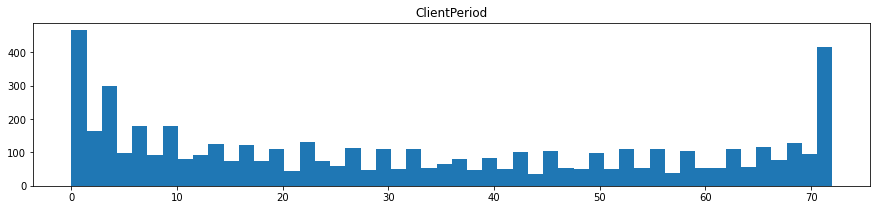

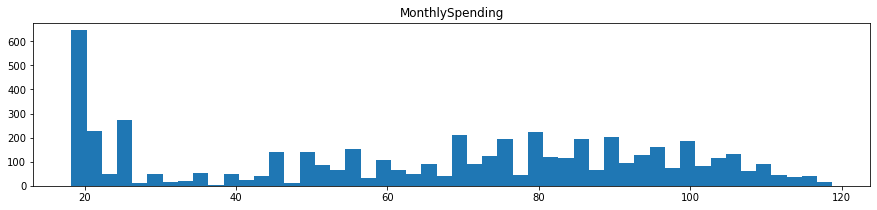

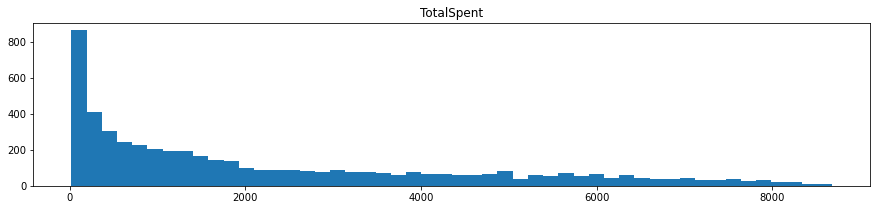

In [25]:
for i in range(3):
    plt.figure(figsize=(15,3))
    plt.hist(data[num_cols[i]], bins=50)
    plt.title(num_cols[i])
    plt.show()

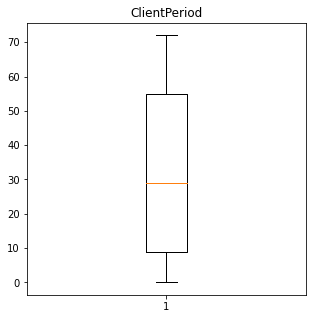

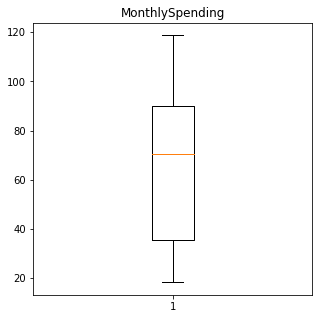

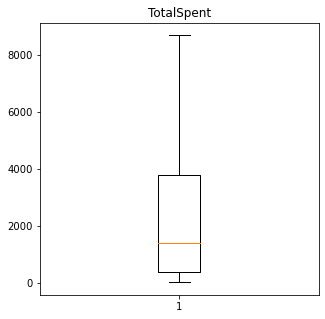

In [26]:
for i in range(3):
    plt.figure(figsize=(5,5))
    plt.boxplot(data[num_cols[i]])
    plt.title(num_cols[i])
    plt.show()

In [27]:
data

ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
0               55            19.50     1026.35    1                0   
1               72            25.85     1872.20    1                0   
2                1            75.90       75.90    1                0   
3               32            79.30     2570.00    0                1   
4               60           115.25     6758.45    0                0   
...            ...              ...         ...  ...              ...   
5277             3            30.40       82.15    1                0   
5278            50            44.45     2188.45    1                0   
5279             1            55.05       55.05    1                0   
5280            29            76.00     2215.25    0                0   
5281            19            75.90     1375.60    0                0   

      HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0              1         1                1                        0   
1              1         0                1                        1   
2              0         0                1                        0   
3              1         0                1                        1   
4              1         1                1                        1   
...          ...       ...              ...                      ...   
5277           0         0                0                        0   
5278           1         0                0                        0   
5279           0         0                1                        0   
5280           0         0                1                        1   
5281           0         1                1                        1   

      HasInternetService  ...  HasMovieSubscription  IsBillingPaperless  \
0                      0  ...                     0                   0   
1                      0  ...                     0                   0   
2                      1  ...                     0                   1   
3                      1  ...                     0                   0   
4                      1  ...                     1                   0   
...                  ...  ...                   ...                 ...   
5277                   1  ...                     0                   0   
5278                   1  ...                     0                   1   
5279                   1  ...                     0                   0   
5280                   1  ...                     0                   1   
5281                   1  ...                     0                   1   

      Churn  Month-to-month  One year  Two year  Bank transfer (automatic)  \
0         0               0         1         0                          0   
1         0               0         0         1                          0   
2         1               1         0         0                          0   
3         0               1         0         0                          0   
4         0               0         0         1                          0   
...     ...             ...       ...       ...                        ...   
5277      0               1         0         0                          0   
5278      0               0         1         0                          1   
5279      0               1         0         0                          0   
5280      0               1         0         0                          0   
5281      0               1         0         0                          0   

      Credit card (automatic)  Electronic check  Mailed check  
0                           0                 0             1  
1                           1                 0             0  
2                           0                 1             0  
3                           0                 0             1  
4                           1                 0             0  
...                       ...             

# Splitting

In [434]:
fin_data = data.copy()
fin_data[num_cols] = scaler.transform(fin_data[num_cols])
fin_data.drop(columns = ['Churn'], inplace=True)
fin_data

ClientPeriod  MonthlySpending  TotalSpent  Sex  IsSeniorCitizen  \
0         0.913843        -1.496916   -0.555994    1                0   
1         1.601834        -1.287346   -0.186154    1                0   
2        -1.271538         0.364459   -0.971570    1                0   
3        -0.016967         0.476670    0.118953    0                1   
4         1.116193         1.663131    1.950315    0                0   
...            ...              ...         ...  ...              ...   
5277     -1.190598        -1.137182   -0.968837    1                0   
5278      0.711493        -0.673488   -0.047876    1                0   
5279     -1.271538        -0.323655   -0.980686    1                0   
5280     -0.138378         0.367760   -0.036158    0                0   
5281     -0.543078         0.364459   -0.403288    0                0   

      HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  \
0              1         1                1                        0   
1              1         0                1                        1   
2              0         0                1                        0   
3              1         0                1                        1   
4              1         1                1                        1   
...          ...       ...              ...                      ...   
5277           0         0                0                        0   
5278           1         0                0                        0   
5279           0         0                1                        0   
5280           0         0                1                        1   
5281           0         1                1                        1   

      HasInternetService  ...  HasOnlineTV  HasMovieSubscription  \
0                      0  ...            0                     0   
1                      0  ...            0                     0   
2                      1  ...            0                     0   
3                      1  ...            0                     0   
4                      1  ...            1                     1   
...                  ...  ...          ...                   ...   
5277                   1  ...            0                     0   
5278                   1  ...            1                     0   
5279                   1  ...            0                     0   
5280                   1  ...            0                     0   
5281                   1  ...            1                     0   

      IsBillingPaperless  Month-to-month  One year  Two year  \
0                      0               0         1         0   
1                      0               0         0         1   
2                      1               1         0         0   
3                      0               1         0         0   
4                      0               0         0         1   
...                  ...             ...       ...       ...   
5277                   0               1         0         0   
5278                   1               0         1         0   
5279                   0               1         0         0   
5280                   1               1         0         0   
5281                   1               1         0         0   

      Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                             0                        0                 0   
1                             0                        1                 0   
2                             0                        0                 1   
3                             0                        0                 0   
4                             0                        1                 0   
...                         ...                      ...               ...   
5277                          0                        0                 1   
5278                          1                       

In [28]:
target = data.Churn
data.drop(columns = ['Churn'], inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1, stratify=target, test_size=0.3)

In [30]:
X_train_std, X_test_std, y_train, y_test = train_test_split(data, target, random_state=1, stratify=target, test_size=0.3)

In [31]:
scaler = StandardScaler().fit(X_train[num_cols])
X_test_std[num_cols] = scaler.transform(X_test[num_cols])
X_train_std[num_cols] = scaler.transform(X_train[num_cols])

/home/clou/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/clou/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [32]:
def score(model):
    print(f'Roc_auc  Train : {round(roc_auc_score (y_train, model.predict_proba(X_train_std)[:,1]),5)}')
    print(f'Accuracy Train : {round(accuracy_score(y_train, model.predict(X_train_std)),5)}')
    print('-------------------------')
    print(f'Roc_auc  Test  :  {round(roc_auc_score (y_test,  model.predict_proba(X_test_std)[:,1]), 5)}')
    print(f'Accuracy Test  :  {round(accuracy_score(y_test,  model.predict(X_test_std)),5)}')

In [33]:
def score1(model):
    print(f'Roc_auc  Train : {round(roc_auc_score (y_train_cat, model.predict_proba(X_train_cat)[:,1]),5)}')
    print(f'Accuracy Train : {round(accuracy_score(y_train_cat, model.predict(X_train_cat)),5)}')
    print('-------------------------')
    print(f'Roc_auc  Test  :  {round(roc_auc_score (y_test_cat,  model.predict_proba(X_test_cat)[:,1]), 5)}')
    print(f'Accuracy Test  :  {round(accuracy_score(y_test_cat,  model.predict(X_test_cat)),5)}')

# Feature selection

In [34]:
feat_labels = data.columns

In [35]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
random_forest.fit(X_train_std, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

In [36]:
importances = random_forest.feature_importances_

In [37]:
importances

array([0.15715221, 0.18630412, 0.18029582, 0.02838825, 0.0229956 ,
       0.02408265, 0.01973428, 0.0088394 , 0.02068879, 0.0193201 ,
       0.026321  , 0.02235559, 0.0212295 , 0.02443559, 0.01891308,
       0.01899884, 0.03023966, 0.0590477 , 0.0124678 , 0.02663467,
       0.01196957, 0.0124162 , 0.03577561, 0.01139397])

In [38]:
indices = np.argsort(importances)

In [39]:
indices

array([ 7, 23, 20, 21, 18, 14, 15,  9,  6,  8, 12, 11,  4,  5, 13, 10, 19,
        3, 16, 22, 17,  0,  2,  1])

In [40]:
indices = indices[::-1]

In [41]:
indices

array([ 1,  2,  0, 17, 22, 16,  3, 19, 10, 13,  5,  4, 11, 12,  8,  6,  9,
       15, 14, 18, 21, 20, 23,  7])

In [42]:
for f in range(data.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) MonthlySpending                0.186304
 2) TotalSpent                     0.180296
 3) ClientPeriod                   0.157152
 4) Month-to-month                 0.059048
 5) Electronic check               0.035776
 6) IsBillingPaperless             0.030240
 7) Sex                            0.028388
 8) Two year                       0.026635
 9) HasOnlineSecurityService       0.026321
10) HasTechSupportAccess           0.024436
11) HasPartner                     0.024083
12) IsSeniorCitizen                0.022996
13) HasOnlineBackup                0.022356
14) HasDeviceProtection            0.021230
15) HasMultiplePhoneNumbers        0.020689
16) HasChild                       0.019734
17) HasInternetService             0.019320
18) HasMovieSubscription           0.018999
19) HasOnlineTV                    0.018913
20) One year                       0.012468
21) Credit card (automatic)        0.012416
22) Bank transfer (automatic)      0.011970
23) Mailed check                

# LogisticRegression

In [491]:
param_grid = [{
        'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
        'C' : [0.001, 0.01, 0.1, 1, 10, 50, 70, 100, 500],
        'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
}]

logit = LogisticRegression()

grid_1 = GridSearchCV(estimator=logit, param_grid=param_grid, scoring='roc_auc', verbose=False, cv=5, n_jobs=-1)
grid_1.fit(fin_data, target)

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-packa

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/si

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/ana

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear so

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-package

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear so

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-packa

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-package

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/h

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-p

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The m

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/ana

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-p

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/ana

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/clou/anaconda3/lib/python3.9/site-package

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-p

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Tr

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 50, 70, 100, 500],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             scoring='roc_auc', verbose=False)

In [492]:
grid_1.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [493]:
score(grid_1)

Roc_auc  Train : 0.85047
Accuracy Train : 0.80822
-------------------------
Roc_auc  Test  :  0.84384
Accuracy Test  :  0.80442


In [301]:
m_1 = LogisticRegression(C=70, max_iter=50, penalty='l1', solver='liblinear').fit(X_train_std, y_train)
score(m_1)

Roc_auc  Train : 0.85097
Accuracy Train : 0.80958
-------------------------
Roc_auc  Test  :  0.84122
Accuracy Test  :  0.80063


In [494]:
m_11 = LogisticRegression().fit(fin_data, target)

In [96]:
logit = LogisticRegression(C=70, max_iter=10, penalty='l1', solver='liblinear').fit(X_train_std, y_train)
score(logit)

Roc_auc  Train : 0.85073
Accuracy Train : 0.81039
-------------------------
Roc_auc  Test  :  0.84148
Accuracy Test  :  0.80126


/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [97]:
logit = LogisticRegression().fit(X_train_std, y_train)
score(logit)

Roc_auc  Train : 0.85079
Accuracy Train : 0.8093
-------------------------
Roc_auc  Test  :  0.84138
Accuracy Test  :  0.8


# SVM

In [135]:
svm_param_grid = [{
    'C':[10, 1, 0.1, 0.01],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[1, 2],
    'gamma':[0.01, 0.1, 1, 10]
}]

In [137]:
svm = SVC(probability=True, max_iter=2000)

grid_svm = GridSearchCV(estimator=svm, param_grid=svm_param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_svm.fit(X_train_std, y_train)

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScale

GridSearchCV(cv=5, estimator=SVC(max_iter=2000, probability=True), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'degree': [1, 2, 3],
                          'gamma': [0.01, 0.1, 1, 10, 50, 100],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='roc_auc')

In [139]:
grid_svm.best_params_

{'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [140]:
score(grid_svm)

Roc_auc  Train : 0.84434
Accuracy Train : 0.80417
-------------------------
Roc_auc  Test  :  0.83356
Accuracy Test  :  0.80063


In [288]:
m_2 = SVC(probability=True, max_iter=2000, C=1, degree=1, gamma=0.01, kernel='rbf').fit(X_train_std, y_train)
score(m_2)

Roc_auc  Train : 0.84435
Accuracy Train : 0.80417
-------------------------
Roc_auc  Test  :  0.83357
Accuracy Test  :  0.80063


In [501]:
m_22 = SVC(probability=True, C=1).fit(fin_data, target)

In [502]:
score(m_22)

Roc_auc  Train : 0.86798
Accuracy Train : 0.82039
-------------------------
Roc_auc  Test  :  0.8374
Accuracy Test  :  0.80946


In [98]:
svm_param_grid_1 = [{
    'C':[0.01, 0.009, 0.008],
    #'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree':[1, 2, 3, 4],
    #'gamma':[5, 6, 7, 8, 9],
    #'max_iter':[2000]
}]

svm_1 = SVC(probability=True, kernel='poly', max_iter=3000, gamma=7, degree=1, C=0.009)

grid_svm_1 = GridSearchCV(estimator=svm_1, param_grid=svm_param_grid_1, scoring='roc_auc', cv=5, n_jobs=-1)

grid_svm_1.fit(X_train_std, y_train)

GridSearchCV(cv=5,
             estimator=SVC(C=0.009, degree=1, gamma=7, kernel='poly',
                           max_iter=3000, probability=True),
             n_jobs=-1, param_grid=[{'C': [0.01, 0.009, 0.008]}],
             scoring='roc_auc')

In [99]:
grid_svm_1.best_params_

{'C': 0.009}

In [128]:
score(grid_svm_1)

Roc_auc  Train : 0.84114
Accuracy Train : 0.80579
-------------------------
Roc_auc  Test  :  0.83139
Accuracy Test  :  0.79937


In [134]:
svm_2 = SVC(probability=True, kernel='poly', max_iter=2000, gamma=7, degree=1, C=0.009).fit(X_train_std, y_train)
score(svm_2)

Roc_auc  Train : 0.84112
Accuracy Train : 0.80579
-------------------------
Roc_auc  Test  :  0.83136
Accuracy Test  :  0.79937


In [152]:
svm_3 = SVC(probability=True, C=0.01).fit(X_train_std, y_train)
score(svm_3)

Roc_auc  Train : 0.83567
Accuracy Train : 0.7379
-------------------------
Roc_auc  Test  :  0.81814
Accuracy Test  :  0.73817


# DecisionTrees

In [153]:
dt_param_grid_0 = [{
    #'max_depth':[], - better if it AUTOMATICALY searching
    'min_samples_split':[2, 4, 8, 16, 32, 48, 72],
    'min_samples_leaf':[2, 4, 8, 16, 32, 48, 72]
    #'max_features':[] - better if it AUTOMATICALY searching
}]

dt_0 = DecisionTreeClassifier()

grid_dt_0 = GridSearchCV(estimator=dt_0, param_grid=dt_param_grid_0, scoring='roc_auc', cv=5, n_jobs=-1)

grid_dt_0.fit(X_train_std, y_train)

print(grid_dt_0.best_params_)
print()
score(grid_dt_0)

{'min_samples_leaf': 72, 'min_samples_split': 16}

Roc_auc  Train : 0.85413
Accuracy Train : 0.80687
-------------------------
Roc_auc  Test  :  0.81794
Accuracy Test  :  0.77918


In [289]:
m_3 = DecisionTreeClassifier(max_depth=100, min_samples_leaf=100, min_samples_split=2).fit(X_train_std, y_train)
score(m_3)

Roc_auc  Train : 0.84866
Accuracy Train : 0.80254
-------------------------
Roc_auc  Test  :  0.82157
Accuracy Test  :  0.78549


In [503]:
m_33 = DecisionTreeClassifier().fit(fin_data, target)
score(m_33)

Roc_auc  Train : 0.99999
Accuracy Train : 0.99838
-------------------------
Roc_auc  Test  :  1.0
Accuracy Test  :  0.99874


In [171]:
dt_1 = DecisionTreeClassifier(min_samples_leaf=120).fit(X_train_std, y_train)
score(dt_1)

Roc_auc  Train : 0.84551
Accuracy Train : 0.79821
-------------------------
Roc_auc  Test  :  0.81983
Accuracy Test  :  0.78612


# KNN

In [197]:
knn_param_grid_0 = [{
    'n_neighbors':[85, 90, 95],
    #'weights':['uniform', 'distance'],
    'leaf_size':[1, 2, 3, 10, 20],
    #'p':[1, 2]
}]

knn_0 = KNeighborsClassifier(n_jobs=-1)

knn_grid_0 = GridSearchCV(estimator=knn_0, param_grid=knn_param_grid_0, scoring='roc_auc', cv=5, n_jobs=-1)

knn_grid_0.fit(X_train_std, y_train)

print(knn_grid_0.best_params_)
print()
score(knn_grid_0)

{'leaf_size': 1, 'n_neighbors': 85}

Roc_auc  Train : 0.84396
Accuracy Train : 0.79821
-------------------------
Roc_auc  Test  :  0.83345
Accuracy Test  :  0.78864


In [452]:
m_4 = KNeighborsClassifier(n_neighbors=80).fit(X_train_std, y_train)
score(m_4)

Roc_auc  Train : 0.84424
Accuracy Train : 0.79876
-------------------------
Roc_auc  Test  :  0.83379
Accuracy Test  :  0.79306


In [504]:
m_44 = KNeighborsClassifier().fit(fin_data, target)
score(m_44)

Roc_auc  Train : 0.89357
Accuracy Train : 0.83284
-------------------------
Roc_auc  Test  :  0.90124
Accuracy Test  :  0.83975


# RandomForestClassifier

In [198]:
rf_param_grid_0 = [{
    #'n_estimators':[55, 75, 95], 
    #'max_depth':[10, 20, 40],
    'min_samples_split':[5, 10, 15, 30],
    'min_samples_leaf':[5, 15, 30, 50],
    #'max_features':['auto', 'log2', 'None'],
    'max_leaf_nodes':[30, 55, 60, 70, 'None'],
    #'max_samples':[0.7, 0.9] - equal 
}]

rf_0 = RandomForestClassifier(n_jobs=-1)

grid_rf_0 = GridSearchCV(estimator=rf_0, param_grid=rf_param_grid_0, scoring='roc_auc', cv=5, n_jobs=-1)

grid_rf_0.fit(X_train_std, y_train)

print(grid_rf_0.best_params_)
print()
score(grid_rf_0)

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super()

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super()

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clou/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/clou/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/clou/anaconda3/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
  File "/home/c

{'max_leaf_nodes': 55, 'min_samples_leaf': 5, 'min_samples_split': 20}

Roc_auc  Train : 0.88842
Accuracy Train : 0.835
-------------------------
Roc_auc  Test  :  0.83837
Accuracy Test  :  0.80063


In [238]:
rf_1 = RandomForestClassifier(min_samples_leaf=25, n_jobs=-1).fit(X_train_std, y_train)
score(rf_1)

Roc_auc  Train : 0.87412
Accuracy Train : 0.82039
-------------------------
Roc_auc  Test  :  0.83932
Accuracy Test  :  0.79937


In [294]:
m_5 = RandomForestClassifier(max_samples=0.3, max_leaf_nodes=50, min_samples_leaf=15, min_samples_split=10, n_jobs=-1).fit(X_train_std, y_train)
score(rf_2)

Roc_auc  Train : 0.86554
Accuracy Train : 0.81309
-------------------------
Roc_auc  Test  :  0.84155
Accuracy Test  :  0.79243


In [505]:
m_55 = RandomForestClassifier().fit(fin_data, target)
score(m_55)

Roc_auc  Train : 0.99995
Accuracy Train : 0.99811
-------------------------
Roc_auc  Test  :  1.0
Accuracy Test  :  0.99937


# CatBoostClassifier

In [556]:
df = pd.read_csv('./train.csv')

y = df['Churn']

X = df.drop(columns='Churn')

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, random_state=1, stratify=y)

# - - - - - - - - - - - - - -

### CatBoostClassifier default settings - Score: 0.83917

In [244]:
model = CatBoostClassifier(eval_metric='AUC')
model.fit(X_train_std, y_train, eval_set=(X_test_std, y_test), verbose=False)

print(f'Model is fitted : {model.is_fitted()}')
score(model)

Model is fitted : True
Roc_auc  Train : 0.89685
Accuracy Train : 0.83473
-------------------------
Roc_auc  Test  :  0.83917
Accuracy Test  :  0.80189


In [247]:
model1 = CatBoostClassifier(eval_metric='AUC', cat_features=cat_cols)
model1.fit(X_train_cat, y_train_cat, eval_set=(X_test_cat, y_test_cat), verbose=False)

print(f'Model is fitted : {model.is_fitted()}')
score1(model1)

Model is fitted : True
Roc_auc  Train : 0.87634
Accuracy Train : 0.82454
-------------------------
Roc_auc  Test  :  0.8479
Accuracy Test  :  0.80696


### CatBoostClassifier Optimize settings - Score: 0.82352

In [248]:
catboost = CatBoostClassifier(
    #cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=42,
    loss_function='CrossEntropy',
#   task_type='GPU',
    early_stopping_rounds=10
)

PARAMS = {
    "n_estimators": [1000],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],     # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],            # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],         # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],          # [3, 5, 7, 10],
    # "random_strength": [2, 5, 8], # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],   # np.arange(10, 1001, 10),
    # 'task_type': ['GPU'],
    # 'early_stopping_rounds': [10],
}

catboost.grid_search(PARAMS, X_train_std, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8499686	best: 0.8499686 (0)	total: 498ms	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 100,
  'depth': 4,
  'l2_leaf_reg': 10,
  'iterations': 1000,
  'subsample': 0.6,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 102],
              'test-AUC-mean': [0.8044357348731473, 0.813222997879441],
              'test-AUC-std': [0.015549578714346804, 0.01375035250696744],
              'train-AUC-mean': [0.8147343908563986, nan],
              'train-AUC-std': [0.0028455049588456374, nan],
              'test-CrossEntropy-mean': [0.6624011274945103, nan],
              'test-CrossEntropy-std': [0.0010345883975379706, nan],
              'train-CrossEntropy-mean': [0.6619468496248023, nan],
              'train-CrossEntropy-std': [0.0012094990960487076, nan]})}

In [279]:
score1(catboost)

Roc_auc  Train : 0.89693
Accuracy Train : 0.83868
-------------------------
Roc_auc  Test  :  0.84253
Accuracy Test  :  0.79864


In [278]:
score1(catboost)

Roc_auc  Train : 0.89693
Accuracy Train : 0.83868
-------------------------
Roc_auc  Test  :  0.84253
Accuracy Test  :  0.79864


In [250]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=42,
    loss_function='CrossEntropy',
#   task_type='GPU',
    early_stopping_rounds=10
)

PARAMS = {
    "n_estimators": [1000],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],     # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],            # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],         # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],          # [3, 5, 7, 10],
    # "random_strength": [2, 5, 8], # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],   # np.arange(10, 1001, 10),
    # 'task_type': ['GPU'],
    # 'early_stopping_rounds': [10],
}

catboost.grid_search(PARAMS, X_train_cat, y_train_cat, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8489628	best: 0.8489628 (0)	total: 348ms	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 100,
  'depth': 4,
  'l2_leaf_reg': 10,
  'iterations': 1000,
  'subsample': 0.6,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 127],
              'test-AUC-mean': [0.7784657480387183, 0.7918367630029344],
              'test-AUC-std': [0.01678891394956658, 0.02526701660356968],
              'train-AUC-mean': [0.7852978068531364, nan],
              'train-AUC-std': [0.012490656259936218, nan],
              'test-CrossEntropy-mean': [0.6664757074433536, nan],
              'test-CrossEntropy-std': [0.002368709522509434, nan],
              'train-CrossEntropy-mean': [0.665817098996197, nan],
              'train-CrossEntropy-std': [0.0024006452234482593, nan]})}

# ----------- 0.84268

In [295]:
m_6 = CatBoostClassifier(
    iterations=5000,
    random_seed=1,
    max_depth=2,
    eval_metric='AUC:hints=skip_train~false',
    learning_rate=0.0055
)

m_6.fit(
    #X, y,
    X_train_std, y_train,
    #cat_features=cat_cols,
    eval_set=(X_test_std, y_test),
    verbose=False,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [456]:
score(m_6)

Roc_auc  Train : 0.86914
Accuracy Train : 0.81931
-------------------------
Roc_auc  Test  :  0.84268
Accuracy Test  :  0.80189


In [507]:
m_66 = CatBoostClassifier(
    iterations=5000,
    random_seed=1,
    max_depth=2,
    eval_metric='AUC:hints=skip_train~false',
    learning_rate=0.1
)

m_66.fit(
    fin_data, target,
    #cat_features=cat_cols,
    eval_set=(X_test_std, y_test),
    verbose=False,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [508]:
score(m_66)

Roc_auc  Train : 0.93468
Accuracy Train : 0.87179
-------------------------
Roc_auc  Test  :  0.92085
Accuracy Test  :  0.85615


In [557]:
model_22 = CatBoostClassifier(
    iterations=5000,
    random_seed=1,
    max_depth=2,
    eval_metric='AUC:hints=skip_train~false',
    learning_rate=0.01
)

model_22.fit(
    X, y,
    cat_features=cat_cols,
    eval_set=(X_test_cat, y_test_cat),
    verbose=False,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# ----------- 0.84105

In [261]:
model_3 = CatBoostClassifier(
    depth=2,
    grow_policy='Lossguide',
    iterations=5000,
    eval_metric='AUC:hints=skip_train~false',
    l2_leaf_reg=20,
    learning_rate=0.006,
    #metric_period=1000,
    min_data_in_leaf=5,
    random_seed=1,
    subsample=0.9
)

model_3.fit(
    X_train_std, y_train,
    #cat_features=cat_cols,
    eval_set=(X_test_std, y_test),
    verbose=False,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [262]:
score(model_3)

Roc_auc  Train : 0.86937
Accuracy Train : 0.81769
-------------------------
Roc_auc  Test  :  0.84105
Accuracy Test  :  0.80126


# ------- 0.85203

In [563]:
ctboost_22 = CatBoostClassifier(
    cat_features=cat_cols,
    depth=2,
    grow_policy='Depthwise',
    iterations=2000,
    eval_metric='AUC:hints=skip_train~false',
    l2_leaf_reg=16,
    learning_rate=0.07,
    metric_period=100,
    min_data_in_leaf=160,
    random_seed=0,
    random_strength=5,
    subsample=0.4
)

ctboost_22.fit(
    X, y,
    eval_set=(X_test_cat, y_test_cat),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [554]:
score1(ctboost_22)

Roc_auc  Train : 0.86025
Accuracy Train : 0.81242
-------------------------
Roc_auc  Test  :  0.85203
Accuracy Test  :  0.80772


# - - - - - - - - - - - - - -

In [597]:
c_b = CatBoostClassifier(
    cat_features=cat_cols,
    depth=2,
    grow_policy='Depthwise',
    iterations=5000,
    eval_metric='AUC:hints=skip_train~false',
    l2_leaf_reg=16,
    learning_rate=0.009,
    metric_period=100,
    min_data_in_leaf=160,
    random_seed=0,
    random_strength=5,
    subsample=0.4
)

c_b.fit(
    X_train_cat, y_train_cat,
    cat_features=cat_cols,
    eval_set=(X_test_cat, y_test_cat),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [559]:
score1(c_b)

Roc_auc  Train : 0.86192
Accuracy Train : 0.81343
-------------------------
Roc_auc  Test  :  0.86258
Accuracy Test  :  0.81908


# - - - - -

In [273]:
c_b_v1 = CatBoostClassifier(cat_features=cat_cols, verbose=False).fit(X_train_cat, y_train_cat)

In [274]:
score1(c_b_v1)

Roc_auc  Train : 0.89586
Accuracy Train : 0.83767
-------------------------
Roc_auc  Test  :  0.84447
Accuracy Test  :  0.80091


# CatBoost models (3) for staking
### without difficult ...

In [524]:
X = X.replace({"Male":1, "Female":0})

In [526]:
Xind_ = X[X['TotalSpent'] == ' '].index

X.loc[(Xind_), 'TotalSpent'] = X.loc[(ind_), 'MonthlySpending']

X = X.astype({'ClientPeriod':'uint8', 'TotalSpent':'float64', 'IsSeniorCitizen':'int8',
                    'IsSeniorCitizen':'uint8'})

X = X.replace({
    "Yes":1,  "No":0, 
    "No phone service":0, 
    "No internet service":0,
    "Fiber optic":1, "DSL":1})

In [541]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   uint8  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5282 non-null   int64  
 4   IsSeniorCitizen           5282 non-null   uint8  
 5   HasPartner                5282 non-null   int64  
 6   HasChild                  5282 non-null   int64  
 7   HasPhoneService           5282 non-null   int64  
 8   HasMultiplePhoneNumbers   5282 non-null   int64  
 9   HasInternetService        5282 non-null   int64  
 10  HasOnlineSecurityService  5282 non-null   int64  
 11  HasOnlineBackup           5282 non-null   int64  
 12  HasDeviceProtection       5282 non-null   int64  
 13  HasTechSupportAccess      5282 non-null   int64  
 14  HasOnlin

In [542]:
X = pd.concat([X, pd.get_dummies(X.PaymentMethod)], axis=1)
X.drop(columns = ['PaymentMethod', 'HasContractPhone'], inplace=True)

In [562]:
staking_cb = StackingClassifier(
    estimators=[
        ('1', c_b),
        ('2', ctboost_22),
        ('3', model_22)
    ],
    final_estimator=CatBoostClassifier(cat_features=cat_cols)
).fit(X, y)

0:	learn: 0.6997343	total: 6.23ms	remaining: 31.1s
100:	learn: 0.8366825	total: 550ms	remaining: 26.7s
200:	learn: 0.8395130	total: 1s	remaining: 24s
300:	learn: 0.8413706	total: 1.47s	remaining: 23s
400:	learn: 0.8424163	total: 1.92s	remaining: 22.1s
500:	learn: 0.8432403	total: 2.38s	remaining: 21.4s
600:	learn: 0.8442002	total: 2.83s	remaining: 20.7s
700:	learn: 0.8448685	total: 3.28s	remaining: 20.1s
800:	learn: 0.8455678	total: 3.73s	remaining: 19.6s
900:	learn: 0.8463670	total: 4.19s	remaining: 19s
1000:	learn: 0.8476652	total: 4.63s	remaining: 18.5s
1100:	learn: 0.8490006	total: 5.09s	remaining: 18s
1200:	learn: 0.8506186	total: 5.55s	remaining: 17.6s
1300:	learn: 0.8521572	total: 6.03s	remaining: 17.1s
1400:	learn: 0.8532166	total: 6.5s	remaining: 16.7s
1500:	learn: 0.8539500	total: 6.97s	remaining: 16.2s
1600:	learn: 0.8547076	total: 7.44s	remaining: 15.8s
1700:	learn: 0.8552470	total: 7.91s	remaining: 15.3s
1800:	learn: 0.8557753	total: 8.38s	remaining: 14.9s
1900:	learn: 0.8

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Male": Cannot convert 'b'Male'' to float

# - - - Staking - - -

In [275]:
from sklearn.ensemble import StackingClassifier

In [296]:
m_7 = CatBoostClassifier()

In [509]:
staking = StackingClassifier(
    estimators=[
        ('logreg', m_11),
        ('SVC', m_22),
        ('DesicionTreeClassifier', m_33),
        ('KNeighborsClassifier', m_44),
        ('RandomForectClassifier', m_55),
        ('CatBoost', m_66)
    ]
)

staking.fit(fin_data, target)

0:	learn: 0.7775010	total: 5.34ms	remaining: 26.7s
1:	learn: 0.7834274	total: 9.45ms	remaining: 23.6s
2:	learn: 0.8194269	total: 11.9ms	remaining: 19.8s
3:	learn: 0.8258931	total: 14.8ms	remaining: 18.4s
4:	learn: 0.8290242	total: 17.8ms	remaining: 17.8s
5:	learn: 0.8290971	total: 20.6ms	remaining: 17.1s
6:	learn: 0.8308578	total: 23.3ms	remaining: 16.6s
7:	learn: 0.8329734	total: 26.2ms	remaining: 16.3s
8:	learn: 0.8340114	total: 29ms	remaining: 16.1s
9:	learn: 0.8360899	total: 31.7ms	remaining: 15.8s
10:	learn: 0.8376423	total: 34.5ms	remaining: 15.6s
11:	learn: 0.8371409	total: 37.2ms	remaining: 15.5s
12:	learn: 0.8376774	total: 39.8ms	remaining: 15.3s
13:	learn: 0.8377319	total: 42.5ms	remaining: 15.1s
14:	learn: 0.8383162	total: 45.2ms	remaining: 15s
15:	learn: 0.8394196	total: 48.1ms	remaining: 15s
16:	learn: 0.8395462	total: 50.9ms	remaining: 14.9s
17:	learn: 0.8400639	total: 53.7ms	remaining: 14.9s
18:	learn: 0.8410193	total: 56.2ms	remaining: 14.7s
19:	learn: 0.8424983	total: 

203:	learn: 0.8621003	total: 584ms	remaining: 13.7s
204:	learn: 0.8622140	total: 588ms	remaining: 13.7s
205:	learn: 0.8622573	total: 590ms	remaining: 13.7s
206:	learn: 0.8623076	total: 594ms	remaining: 13.7s
207:	learn: 0.8623630	total: 597ms	remaining: 13.8s
208:	learn: 0.8624344	total: 600ms	remaining: 13.8s
209:	learn: 0.8624657	total: 603ms	remaining: 13.8s
210:	learn: 0.8624894	total: 606ms	remaining: 13.8s
211:	learn: 0.8625719	total: 609ms	remaining: 13.8s
212:	learn: 0.8626751	total: 612ms	remaining: 13.8s
213:	learn: 0.8627628	total: 616ms	remaining: 13.8s
214:	learn: 0.8628359	total: 619ms	remaining: 13.8s
215:	learn: 0.8629062	total: 622ms	remaining: 13.8s
216:	learn: 0.8630337	total: 625ms	remaining: 13.8s
217:	learn: 0.8630352	total: 627ms	remaining: 13.8s
218:	learn: 0.8630847	total: 631ms	remaining: 13.8s
219:	learn: 0.8631742	total: 633ms	remaining: 13.8s
220:	learn: 0.8632172	total: 636ms	remaining: 13.8s
221:	learn: 0.8632931	total: 639ms	remaining: 13.7s
222:	learn: 

404:	learn: 0.8710736	total: 1.16s	remaining: 13.2s
405:	learn: 0.8710873	total: 1.17s	remaining: 13.2s
406:	learn: 0.8711534	total: 1.17s	remaining: 13.2s
407:	learn: 0.8712558	total: 1.17s	remaining: 13.2s
408:	learn: 0.8712780	total: 1.18s	remaining: 13.2s
409:	learn: 0.8713416	total: 1.18s	remaining: 13.2s
410:	learn: 0.8713401	total: 1.18s	remaining: 13.2s
411:	learn: 0.8714024	total: 1.19s	remaining: 13.2s
412:	learn: 0.8714454	total: 1.19s	remaining: 13.2s
413:	learn: 0.8714739	total: 1.19s	remaining: 13.2s
414:	learn: 0.8715093	total: 1.2s	remaining: 13.2s
415:	learn: 0.8715549	total: 1.2s	remaining: 13.2s
416:	learn: 0.8715709	total: 1.2s	remaining: 13.2s
417:	learn: 0.8716087	total: 1.21s	remaining: 13.2s
418:	learn: 0.8716354	total: 1.21s	remaining: 13.2s
419:	learn: 0.8716643	total: 1.21s	remaining: 13.2s
420:	learn: 0.8717180	total: 1.21s	remaining: 13.2s
421:	learn: 0.8717428	total: 1.22s	remaining: 13.2s
422:	learn: 0.8717680	total: 1.22s	remaining: 13.2s
423:	learn: 0.8

603:	learn: 0.8785823	total: 1.74s	remaining: 12.7s
604:	learn: 0.8786503	total: 1.75s	remaining: 12.7s
605:	learn: 0.8786770	total: 1.75s	remaining: 12.7s
606:	learn: 0.8787273	total: 1.75s	remaining: 12.7s
607:	learn: 0.8787345	total: 1.76s	remaining: 12.7s
608:	learn: 0.8787719	total: 1.76s	remaining: 12.7s
609:	learn: 0.8787909	total: 1.76s	remaining: 12.7s
610:	learn: 0.8788598	total: 1.77s	remaining: 12.7s
611:	learn: 0.8789048	total: 1.77s	remaining: 12.7s
612:	learn: 0.8789058	total: 1.77s	remaining: 12.7s
613:	learn: 0.8789289	total: 1.78s	remaining: 12.7s
614:	learn: 0.8789586	total: 1.78s	remaining: 12.7s
615:	learn: 0.8789894	total: 1.78s	remaining: 12.7s
616:	learn: 0.8789942	total: 1.79s	remaining: 12.7s
617:	learn: 0.8791058	total: 1.79s	remaining: 12.7s
618:	learn: 0.8791306	total: 1.79s	remaining: 12.7s
619:	learn: 0.8791518	total: 1.8s	remaining: 12.7s
620:	learn: 0.8792009	total: 1.8s	remaining: 12.7s
621:	learn: 0.8792118	total: 1.8s	remaining: 12.7s
622:	learn: 0.8

800:	learn: 0.8843519	total: 2.32s	remaining: 12.2s
801:	learn: 0.8843616	total: 2.32s	remaining: 12.2s
802:	learn: 0.8843884	total: 2.33s	remaining: 12.2s
803:	learn: 0.8844049	total: 2.33s	remaining: 12.2s
804:	learn: 0.8844444	total: 2.33s	remaining: 12.2s
805:	learn: 0.8844698	total: 2.34s	remaining: 12.2s
806:	learn: 0.8845059	total: 2.34s	remaining: 12.2s
807:	learn: 0.8845254	total: 2.34s	remaining: 12.2s
808:	learn: 0.8845536	total: 2.35s	remaining: 12.2s
809:	learn: 0.8845966	total: 2.35s	remaining: 12.2s
810:	learn: 0.8846079	total: 2.35s	remaining: 12.2s
811:	learn: 0.8846174	total: 2.36s	remaining: 12.2s
812:	learn: 0.8846505	total: 2.36s	remaining: 12.2s
813:	learn: 0.8846878	total: 2.36s	remaining: 12.1s
814:	learn: 0.8846937	total: 2.37s	remaining: 12.2s
815:	learn: 0.8847499	total: 2.37s	remaining: 12.1s
816:	learn: 0.8847512	total: 2.37s	remaining: 12.1s
817:	learn: 0.8847805	total: 2.38s	remaining: 12.1s
818:	learn: 0.8848211	total: 2.38s	remaining: 12.1s
819:	learn: 

998:	learn: 0.8890953	total: 2.9s	remaining: 11.6s
999:	learn: 0.8891189	total: 2.9s	remaining: 11.6s
1000:	learn: 0.8891233	total: 2.9s	remaining: 11.6s
1001:	learn: 0.8891421	total: 2.91s	remaining: 11.6s
1002:	learn: 0.8891830	total: 2.91s	remaining: 11.6s
1003:	learn: 0.8892003	total: 2.92s	remaining: 11.6s
1004:	learn: 0.8892038	total: 2.92s	remaining: 11.6s
1005:	learn: 0.8892334	total: 2.92s	remaining: 11.6s
1006:	learn: 0.8892683	total: 2.92s	remaining: 11.6s
1007:	learn: 0.8892911	total: 2.93s	remaining: 11.6s
1008:	learn: 0.8893176	total: 2.93s	remaining: 11.6s
1009:	learn: 0.8893815	total: 2.93s	remaining: 11.6s
1010:	learn: 0.8894043	total: 2.94s	remaining: 11.6s
1011:	learn: 0.8894284	total: 2.94s	remaining: 11.6s
1012:	learn: 0.8894520	total: 2.94s	remaining: 11.6s
1013:	learn: 0.8894570	total: 2.95s	remaining: 11.6s
1014:	learn: 0.8894972	total: 2.95s	remaining: 11.6s
1015:	learn: 0.8895241	total: 2.95s	remaining: 11.6s
1016:	learn: 0.8895560	total: 2.96s	remaining: 11.6

1197:	learn: 0.8930571	total: 3.48s	remaining: 11s
1198:	learn: 0.8930771	total: 3.48s	remaining: 11s
1199:	learn: 0.8930886	total: 3.49s	remaining: 11s
1200:	learn: 0.8931199	total: 3.49s	remaining: 11s
1201:	learn: 0.8931275	total: 3.49s	remaining: 11s
1202:	learn: 0.8931696	total: 3.5s	remaining: 11s
1203:	learn: 0.8931739	total: 3.5s	remaining: 11s
1204:	learn: 0.8932352	total: 3.5s	remaining: 11s
1205:	learn: 0.8932386	total: 3.51s	remaining: 11s
1206:	learn: 0.8932517	total: 3.51s	remaining: 11s
1207:	learn: 0.8932641	total: 3.51s	remaining: 11s
1208:	learn: 0.8932882	total: 3.52s	remaining: 11s
1209:	learn: 0.8933131	total: 3.52s	remaining: 11s
1210:	learn: 0.8933149	total: 3.52s	remaining: 11s
1211:	learn: 0.8933279	total: 3.53s	remaining: 11s
1212:	learn: 0.8933607	total: 3.53s	remaining: 11s
1213:	learn: 0.8933589	total: 3.53s	remaining: 11s
1214:	learn: 0.8933772	total: 3.54s	remaining: 11s
1215:	learn: 0.8933854	total: 3.54s	remaining: 11s
1216:	learn: 0.8933882	total: 3.54

1396:	learn: 0.8965986	total: 4.06s	remaining: 10.5s
1397:	learn: 0.8966090	total: 4.06s	remaining: 10.5s
1398:	learn: 0.8966151	total: 4.07s	remaining: 10.5s
1399:	learn: 0.8966198	total: 4.07s	remaining: 10.5s
1400:	learn: 0.8966555	total: 4.07s	remaining: 10.5s
1401:	learn: 0.8966655	total: 4.08s	remaining: 10.5s
1402:	learn: 0.8966935	total: 4.08s	remaining: 10.5s
1403:	learn: 0.8967000	total: 4.08s	remaining: 10.5s
1404:	learn: 0.8967228	total: 4.09s	remaining: 10.5s
1405:	learn: 0.8967230	total: 4.09s	remaining: 10.5s
1406:	learn: 0.8967362	total: 4.09s	remaining: 10.5s
1407:	learn: 0.8967491	total: 4.1s	remaining: 10.5s
1408:	learn: 0.8967547	total: 4.1s	remaining: 10.5s
1409:	learn: 0.8967666	total: 4.11s	remaining: 10.5s
1410:	learn: 0.8967695	total: 4.11s	remaining: 10.5s
1411:	learn: 0.8967846	total: 4.11s	remaining: 10.5s
1412:	learn: 0.8967881	total: 4.12s	remaining: 10.4s
1413:	learn: 0.8968046	total: 4.12s	remaining: 10.4s
1414:	learn: 0.8968235	total: 4.12s	remaining: 1

1593:	learn: 0.8995070	total: 4.64s	remaining: 9.92s
1594:	learn: 0.8995133	total: 4.64s	remaining: 9.92s
1595:	learn: 0.8995511	total: 4.65s	remaining: 9.91s
1596:	learn: 0.8995505	total: 4.65s	remaining: 9.91s
1597:	learn: 0.8995655	total: 4.65s	remaining: 9.91s
1598:	learn: 0.8995706	total: 4.66s	remaining: 9.91s
1599:	learn: 0.8996000	total: 4.66s	remaining: 9.9s
1600:	learn: 0.8996078	total: 4.66s	remaining: 9.9s
1601:	learn: 0.8996263	total: 4.67s	remaining: 9.9s
1602:	learn: 0.8996397	total: 4.67s	remaining: 9.9s
1603:	learn: 0.8996723	total: 4.67s	remaining: 9.9s
1604:	learn: 0.8996840	total: 4.68s	remaining: 9.89s
1605:	learn: 0.8997001	total: 4.68s	remaining: 9.89s
1606:	learn: 0.8997016	total: 4.69s	remaining: 9.89s
1607:	learn: 0.8997068	total: 4.69s	remaining: 9.89s
1608:	learn: 0.8997183	total: 4.69s	remaining: 9.89s
1609:	learn: 0.8997233	total: 4.7s	remaining: 9.89s
1610:	learn: 0.8997246	total: 4.7s	remaining: 9.88s
1611:	learn: 0.8997318	total: 4.7s	remaining: 9.88s
1

1791:	learn: 0.9022722	total: 5.22s	remaining: 9.35s
1792:	learn: 0.9022948	total: 5.22s	remaining: 9.35s
1793:	learn: 0.9022976	total: 5.23s	remaining: 9.34s
1794:	learn: 0.9023134	total: 5.23s	remaining: 9.34s
1795:	learn: 0.9023419	total: 5.24s	remaining: 9.34s
1796:	learn: 0.9023756	total: 5.24s	remaining: 9.34s
1797:	learn: 0.9023701	total: 5.24s	remaining: 9.34s
1798:	learn: 0.9023849	total: 5.24s	remaining: 9.33s
1799:	learn: 0.9023834	total: 5.25s	remaining: 9.33s
1800:	learn: 0.9023877	total: 5.25s	remaining: 9.33s
1801:	learn: 0.9024075	total: 5.25s	remaining: 9.32s
1802:	learn: 0.9024553	total: 5.26s	remaining: 9.32s
1803:	learn: 0.9024770	total: 5.26s	remaining: 9.32s
1804:	learn: 0.9024997	total: 5.26s	remaining: 9.32s
1805:	learn: 0.9025065	total: 5.27s	remaining: 9.31s
1806:	learn: 0.9025301	total: 5.27s	remaining: 9.31s
1807:	learn: 0.9025464	total: 5.27s	remaining: 9.31s
1808:	learn: 0.9025675	total: 5.28s	remaining: 9.31s
1809:	learn: 0.9025834	total: 5.28s	remaining:

1990:	learn: 0.9049830	total: 5.8s	remaining: 8.77s
1991:	learn: 0.9049973	total: 5.81s	remaining: 8.78s
1992:	learn: 0.9049906	total: 5.82s	remaining: 8.78s
1993:	learn: 0.9050179	total: 5.82s	remaining: 8.77s
1994:	learn: 0.9050483	total: 5.82s	remaining: 8.77s
1995:	learn: 0.9050479	total: 5.83s	remaining: 8.77s
1996:	learn: 0.9050594	total: 5.83s	remaining: 8.77s
1997:	learn: 0.9050648	total: 5.83s	remaining: 8.76s
1998:	learn: 0.9050653	total: 5.83s	remaining: 8.76s
1999:	learn: 0.9050805	total: 5.84s	remaining: 8.76s
2000:	learn: 0.9050839	total: 5.84s	remaining: 8.76s
2001:	learn: 0.9050982	total: 5.84s	remaining: 8.75s
2002:	learn: 0.9051045	total: 5.85s	remaining: 8.75s
2003:	learn: 0.9051122	total: 5.85s	remaining: 8.75s
2004:	learn: 0.9051280	total: 5.85s	remaining: 8.74s
2005:	learn: 0.9051469	total: 5.86s	remaining: 8.74s
2006:	learn: 0.9051521	total: 5.86s	remaining: 8.74s
2007:	learn: 0.9051725	total: 5.86s	remaining: 8.74s
2008:	learn: 0.9051686	total: 5.87s	remaining: 

2187:	learn: 0.9074122	total: 6.38s	remaining: 8.21s
2188:	learn: 0.9074272	total: 6.39s	remaining: 8.2s
2189:	learn: 0.9074352	total: 6.39s	remaining: 8.2s
2190:	learn: 0.9074474	total: 6.39s	remaining: 8.2s
2191:	learn: 0.9074580	total: 6.4s	remaining: 8.2s
2192:	learn: 0.9074537	total: 6.4s	remaining: 8.19s
2193:	learn: 0.9074879	total: 6.4s	remaining: 8.19s
2194:	learn: 0.9075021	total: 6.41s	remaining: 8.19s
2195:	learn: 0.9075407	total: 6.41s	remaining: 8.18s
2196:	learn: 0.9075564	total: 6.41s	remaining: 8.18s
2197:	learn: 0.9075633	total: 6.42s	remaining: 8.18s
2198:	learn: 0.9075646	total: 6.42s	remaining: 8.18s
2199:	learn: 0.9075848	total: 6.42s	remaining: 8.17s
2200:	learn: 0.9075881	total: 6.43s	remaining: 8.17s
2201:	learn: 0.9076172	total: 6.43s	remaining: 8.17s
2202:	learn: 0.9076156	total: 6.43s	remaining: 8.17s
2203:	learn: 0.9076284	total: 6.44s	remaining: 8.17s
2204:	learn: 0.9076393	total: 6.44s	remaining: 8.16s
2205:	learn: 0.9076560	total: 6.44s	remaining: 8.16s


2385:	learn: 0.9099077	total: 6.96s	remaining: 7.63s
2386:	learn: 0.9099299	total: 6.96s	remaining: 7.62s
2387:	learn: 0.9099319	total: 6.97s	remaining: 7.62s
2388:	learn: 0.9099492	total: 6.97s	remaining: 7.62s
2389:	learn: 0.9100430	total: 6.97s	remaining: 7.62s
2390:	learn: 0.9100558	total: 6.98s	remaining: 7.61s
2391:	learn: 0.9100795	total: 6.98s	remaining: 7.61s
2392:	learn: 0.9100847	total: 6.98s	remaining: 7.61s
2393:	learn: 0.9100810	total: 6.99s	remaining: 7.6s
2394:	learn: 0.9100782	total: 6.99s	remaining: 7.6s
2395:	learn: 0.9100754	total: 6.99s	remaining: 7.6s
2396:	learn: 0.9100991	total: 7s	remaining: 7.6s
2397:	learn: 0.9101251	total: 7s	remaining: 7.59s
2398:	learn: 0.9101331	total: 7s	remaining: 7.59s
2399:	learn: 0.9101396	total: 7s	remaining: 7.59s
2400:	learn: 0.9101538	total: 7.01s	remaining: 7.59s
2401:	learn: 0.9101540	total: 7.01s	remaining: 7.58s
2402:	learn: 0.9101757	total: 7.01s	remaining: 7.58s
2403:	learn: 0.9102113	total: 7.02s	remaining: 7.58s
2404:	lea

2587:	learn: 0.9121313	total: 7.54s	remaining: 7.03s
2588:	learn: 0.9121415	total: 7.54s	remaining: 7.03s
2589:	learn: 0.9121426	total: 7.55s	remaining: 7.02s
2590:	learn: 0.9121522	total: 7.55s	remaining: 7.02s
2591:	learn: 0.9121650	total: 7.55s	remaining: 7.02s
2592:	learn: 0.9121543	total: 7.56s	remaining: 7.01s
2593:	learn: 0.9121735	total: 7.56s	remaining: 7.01s
2594:	learn: 0.9121906	total: 7.56s	remaining: 7.01s
2595:	learn: 0.9121991	total: 7.57s	remaining: 7.01s
2596:	learn: 0.9122228	total: 7.57s	remaining: 7s
2597:	learn: 0.9122458	total: 7.57s	remaining: 7s
2598:	learn: 0.9122534	total: 7.58s	remaining: 7s
2599:	learn: 0.9122527	total: 7.58s	remaining: 7s
2600:	learn: 0.9122510	total: 7.58s	remaining: 6.99s
2601:	learn: 0.9122740	total: 7.59s	remaining: 6.99s
2602:	learn: 0.9122818	total: 7.59s	remaining: 6.99s
2603:	learn: 0.9122920	total: 7.59s	remaining: 6.99s
2604:	learn: 0.9123068	total: 7.6s	remaining: 6.98s
2605:	learn: 0.9123116	total: 7.6s	remaining: 6.98s
2606:	l

2786:	learn: 0.9141558	total: 8.12s	remaining: 6.45s
2787:	learn: 0.9141638	total: 8.12s	remaining: 6.45s
2788:	learn: 0.9141653	total: 8.13s	remaining: 6.44s
2789:	learn: 0.9141708	total: 8.13s	remaining: 6.44s
2790:	learn: 0.9141771	total: 8.13s	remaining: 6.44s
2791:	learn: 0.9142025	total: 8.13s	remaining: 6.43s
2792:	learn: 0.9142033	total: 8.14s	remaining: 6.43s
2793:	learn: 0.9142101	total: 8.14s	remaining: 6.43s
2794:	learn: 0.9142244	total: 8.14s	remaining: 6.42s
2795:	learn: 0.9142342	total: 8.15s	remaining: 6.42s
2796:	learn: 0.9142392	total: 8.15s	remaining: 6.42s
2797:	learn: 0.9142591	total: 8.15s	remaining: 6.42s
2798:	learn: 0.9142680	total: 8.16s	remaining: 6.41s
2799:	learn: 0.9142722	total: 8.16s	remaining: 6.41s
2800:	learn: 0.9142844	total: 8.16s	remaining: 6.41s
2801:	learn: 0.9143061	total: 8.17s	remaining: 6.41s
2802:	learn: 0.9143139	total: 8.17s	remaining: 6.4s
2803:	learn: 0.9143136	total: 8.17s	remaining: 6.4s
2804:	learn: 0.9143243	total: 8.18s	remaining: 6

2986:	learn: 0.9159640	total: 8.7s	remaining: 5.86s
2987:	learn: 0.9159889	total: 8.71s	remaining: 5.86s
2988:	learn: 0.9159894	total: 8.71s	remaining: 5.86s
2989:	learn: 0.9159979	total: 8.71s	remaining: 5.86s
2990:	learn: 0.9160213	total: 8.71s	remaining: 5.85s
2991:	learn: 0.9160363	total: 8.72s	remaining: 5.85s
2992:	learn: 0.9160317	total: 8.72s	remaining: 5.85s
2993:	learn: 0.9160786	total: 8.72s	remaining: 5.84s
2994:	learn: 0.9160817	total: 8.73s	remaining: 5.84s
2995:	learn: 0.9160851	total: 8.73s	remaining: 5.84s
2996:	learn: 0.9160943	total: 8.73s	remaining: 5.84s
2997:	learn: 0.9160973	total: 8.74s	remaining: 5.83s
2998:	learn: 0.9161093	total: 8.74s	remaining: 5.83s
2999:	learn: 0.9161414	total: 8.74s	remaining: 5.83s
3000:	learn: 0.9161473	total: 8.75s	remaining: 5.83s
3001:	learn: 0.9161525	total: 8.75s	remaining: 5.82s
3002:	learn: 0.9161646	total: 8.75s	remaining: 5.82s
3003:	learn: 0.9161698	total: 8.76s	remaining: 5.82s
3004:	learn: 0.9161716	total: 8.76s	remaining: 

3184:	learn: 0.9176519	total: 9.28s	remaining: 5.29s
3185:	learn: 0.9176614	total: 9.29s	remaining: 5.29s
3186:	learn: 0.9176516	total: 9.29s	remaining: 5.29s
3187:	learn: 0.9176488	total: 9.29s	remaining: 5.28s
3188:	learn: 0.9176443	total: 9.3s	remaining: 5.28s
3189:	learn: 0.9176456	total: 9.3s	remaining: 5.28s
3190:	learn: 0.9176558	total: 9.3s	remaining: 5.27s
3191:	learn: 0.9176571	total: 9.3s	remaining: 5.27s
3192:	learn: 0.9176564	total: 9.31s	remaining: 5.27s
3193:	learn: 0.9176599	total: 9.31s	remaining: 5.26s
3194:	learn: 0.9176662	total: 9.31s	remaining: 5.26s
3195:	learn: 0.9176925	total: 9.32s	remaining: 5.26s
3196:	learn: 0.9177016	total: 9.32s	remaining: 5.26s
3197:	learn: 0.9177083	total: 9.32s	remaining: 5.25s
3198:	learn: 0.9177098	total: 9.33s	remaining: 5.25s
3199:	learn: 0.9177233	total: 9.33s	remaining: 5.25s
3200:	learn: 0.9177848	total: 9.33s	remaining: 5.25s
3201:	learn: 0.9178047	total: 9.34s	remaining: 5.24s
3202:	learn: 0.9178036	total: 9.34s	remaining: 5.2

3386:	learn: 0.9195098	total: 9.87s	remaining: 4.7s
3387:	learn: 0.9194998	total: 9.87s	remaining: 4.7s
3388:	learn: 0.9195065	total: 9.87s	remaining: 4.69s
3389:	learn: 0.9195054	total: 9.88s	remaining: 4.69s
3390:	learn: 0.9195239	total: 9.88s	remaining: 4.69s
3391:	learn: 0.9195662	total: 9.88s	remaining: 4.68s
3392:	learn: 0.9195691	total: 9.88s	remaining: 4.68s
3393:	learn: 0.9195793	total: 9.89s	remaining: 4.68s
3394:	learn: 0.9195986	total: 9.89s	remaining: 4.67s
3395:	learn: 0.9196045	total: 9.89s	remaining: 4.67s
3396:	learn: 0.9196101	total: 9.89s	remaining: 4.67s
3397:	learn: 0.9196021	total: 9.9s	remaining: 4.67s
3398:	learn: 0.9196272	total: 9.9s	remaining: 4.66s
3399:	learn: 0.9196318	total: 9.9s	remaining: 4.66s
3400:	learn: 0.9196579	total: 9.91s	remaining: 4.66s
3401:	learn: 0.9196681	total: 9.91s	remaining: 4.65s
3402:	learn: 0.9196683	total: 9.91s	remaining: 4.65s
3403:	learn: 0.9196670	total: 9.92s	remaining: 4.65s
3404:	learn: 0.9196792	total: 9.92s	remaining: 4.65

3588:	learn: 0.9210889	total: 10.4s	remaining: 4.11s
3589:	learn: 0.9211012	total: 10.4s	remaining: 4.1s
3590:	learn: 0.9211169	total: 10.5s	remaining: 4.1s
3591:	learn: 0.9211184	total: 10.5s	remaining: 4.1s
3592:	learn: 0.9211253	total: 10.5s	remaining: 4.09s
3593:	learn: 0.9211278	total: 10.5s	remaining: 4.09s
3594:	learn: 0.9211601	total: 10.5s	remaining: 4.09s
3595:	learn: 0.9211666	total: 10.5s	remaining: 4.09s
3596:	learn: 0.9211625	total: 10.5s	remaining: 4.08s
3597:	learn: 0.9211646	total: 10.5s	remaining: 4.08s
3598:	learn: 0.9211712	total: 10.5s	remaining: 4.08s
3599:	learn: 0.9211836	total: 10.5s	remaining: 4.08s
3600:	learn: 0.9211710	total: 10.5s	remaining: 4.07s
3601:	learn: 0.9211714	total: 10.5s	remaining: 4.07s
3602:	learn: 0.9211772	total: 10.5s	remaining: 4.07s
3603:	learn: 0.9212092	total: 10.5s	remaining: 4.06s
3604:	learn: 0.9212153	total: 10.5s	remaining: 4.06s
3605:	learn: 0.9212133	total: 10.5s	remaining: 4.06s
3606:	learn: 0.9212179	total: 10.5s	remaining: 4.

3787:	learn: 0.9227624	total: 11s	remaining: 3.53s
3788:	learn: 0.9227670	total: 11s	remaining: 3.52s
3789:	learn: 0.9227868	total: 11s	remaining: 3.52s
3790:	learn: 0.9228030	total: 11s	remaining: 3.52s
3791:	learn: 0.9228150	total: 11s	remaining: 3.52s
3792:	learn: 0.9228045	total: 11s	remaining: 3.51s
3793:	learn: 0.9228271	total: 11s	remaining: 3.51s
3794:	learn: 0.9228356	total: 11s	remaining: 3.51s
3795:	learn: 0.9228438	total: 11s	remaining: 3.5s
3796:	learn: 0.9228526	total: 11.1s	remaining: 3.5s
3797:	learn: 0.9228634	total: 11.1s	remaining: 3.5s
3798:	learn: 0.9228712	total: 11.1s	remaining: 3.5s
3799:	learn: 0.9228906	total: 11.1s	remaining: 3.49s
3800:	learn: 0.9228912	total: 11.1s	remaining: 3.49s
3801:	learn: 0.9229168	total: 11.1s	remaining: 3.49s
3802:	learn: 0.9229257	total: 11.1s	remaining: 3.48s
3803:	learn: 0.9229440	total: 11.1s	remaining: 3.48s
3804:	learn: 0.9229713	total: 11.1s	remaining: 3.48s
3805:	learn: 0.9229705	total: 11.1s	remaining: 3.48s
3806:	learn: 0.

3986:	learn: 0.9240959	total: 11.6s	remaining: 2.95s
3987:	learn: 0.9240977	total: 11.6s	remaining: 2.94s
3988:	learn: 0.9241142	total: 11.6s	remaining: 2.94s
3989:	learn: 0.9241150	total: 11.6s	remaining: 2.94s
3990:	learn: 0.9241333	total: 11.6s	remaining: 2.94s
3991:	learn: 0.9241671	total: 11.6s	remaining: 2.93s
3992:	learn: 0.9241693	total: 11.6s	remaining: 2.93s
3993:	learn: 0.9241709	total: 11.6s	remaining: 2.93s
3994:	learn: 0.9241754	total: 11.6s	remaining: 2.92s
3995:	learn: 0.9241758	total: 11.6s	remaining: 2.92s
3996:	learn: 0.9241793	total: 11.6s	remaining: 2.92s
3997:	learn: 0.9241971	total: 11.6s	remaining: 2.92s
3998:	learn: 0.9241963	total: 11.6s	remaining: 2.91s
3999:	learn: 0.9241937	total: 11.6s	remaining: 2.91s
4000:	learn: 0.9242182	total: 11.6s	remaining: 2.91s
4001:	learn: 0.9242188	total: 11.7s	remaining: 2.9s
4002:	learn: 0.9242219	total: 11.7s	remaining: 2.9s
4003:	learn: 0.9242188	total: 11.7s	remaining: 2.9s
4004:	learn: 0.9242406	total: 11.7s	remaining: 2.

4183:	learn: 0.9254976	total: 12.2s	remaining: 2.38s
4184:	learn: 0.9254980	total: 12.2s	remaining: 2.37s
4185:	learn: 0.9255070	total: 12.2s	remaining: 2.37s
4186:	learn: 0.9255269	total: 12.2s	remaining: 2.37s
4187:	learn: 0.9255434	total: 12.2s	remaining: 2.36s
4188:	learn: 0.9255576	total: 12.2s	remaining: 2.36s
4189:	learn: 0.9255636	total: 12.2s	remaining: 2.36s
4190:	learn: 0.9255734	total: 12.2s	remaining: 2.35s
4191:	learn: 0.9255934	total: 12.2s	remaining: 2.35s
4192:	learn: 0.9255956	total: 12.2s	remaining: 2.35s
4193:	learn: 0.9256047	total: 12.2s	remaining: 2.35s
4194:	learn: 0.9256045	total: 12.2s	remaining: 2.34s
4195:	learn: 0.9256095	total: 12.2s	remaining: 2.34s
4196:	learn: 0.9256212	total: 12.2s	remaining: 2.34s
4197:	learn: 0.9256197	total: 12.2s	remaining: 2.33s
4198:	learn: 0.9256487	total: 12.2s	remaining: 2.33s
4199:	learn: 0.9256646	total: 12.2s	remaining: 2.33s
4200:	learn: 0.9256655	total: 12.2s	remaining: 2.33s
4201:	learn: 0.9256653	total: 12.2s	remaining:

4381:	learn: 0.9267215	total: 12.8s	remaining: 1.8s
4382:	learn: 0.9267180	total: 12.8s	remaining: 1.8s
4383:	learn: 0.9267249	total: 12.8s	remaining: 1.79s
4384:	learn: 0.9267469	total: 12.8s	remaining: 1.79s
4385:	learn: 0.9267575	total: 12.8s	remaining: 1.79s
4386:	learn: 0.9267618	total: 12.8s	remaining: 1.78s
4387:	learn: 0.9267584	total: 12.8s	remaining: 1.78s
4388:	learn: 0.9267566	total: 12.8s	remaining: 1.78s
4389:	learn: 0.9267599	total: 12.8s	remaining: 1.78s
4390:	learn: 0.9267682	total: 12.8s	remaining: 1.77s
4391:	learn: 0.9267823	total: 12.8s	remaining: 1.77s
4392:	learn: 0.9267909	total: 12.8s	remaining: 1.77s
4393:	learn: 0.9267927	total: 12.8s	remaining: 1.76s
4394:	learn: 0.9267977	total: 12.8s	remaining: 1.76s
4395:	learn: 0.9267968	total: 12.8s	remaining: 1.76s
4396:	learn: 0.9267931	total: 12.8s	remaining: 1.76s
4397:	learn: 0.9267951	total: 12.8s	remaining: 1.75s
4398:	learn: 0.9268085	total: 12.8s	remaining: 1.75s
4399:	learn: 0.9268103	total: 12.8s	remaining: 1

4581:	learn: 0.9279848	total: 13.3s	remaining: 1.22s
4582:	learn: 0.9279905	total: 13.3s	remaining: 1.21s
4583:	learn: 0.9279909	total: 13.3s	remaining: 1.21s
4584:	learn: 0.9280035	total: 13.3s	remaining: 1.21s
4585:	learn: 0.9280113	total: 13.4s	remaining: 1.21s
4586:	learn: 0.9280161	total: 13.4s	remaining: 1.2s
4587:	learn: 0.9280159	total: 13.4s	remaining: 1.2s
4588:	learn: 0.9280217	total: 13.4s	remaining: 1.2s
4589:	learn: 0.9280257	total: 13.4s	remaining: 1.19s
4590:	learn: 0.9280409	total: 13.4s	remaining: 1.19s
4591:	learn: 0.9280482	total: 13.4s	remaining: 1.19s
4592:	learn: 0.9280576	total: 13.4s	remaining: 1.19s
4593:	learn: 0.9280630	total: 13.4s	remaining: 1.18s
4594:	learn: 0.9280717	total: 13.4s	remaining: 1.18s
4595:	learn: 0.9280713	total: 13.4s	remaining: 1.18s
4596:	learn: 0.9280793	total: 13.4s	remaining: 1.17s
4597:	learn: 0.9280947	total: 13.4s	remaining: 1.17s
4598:	learn: 0.9280958	total: 13.4s	remaining: 1.17s
4599:	learn: 0.9280977	total: 13.4s	remaining: 1.

4778:	learn: 0.9293258	total: 13.9s	remaining: 644ms
4779:	learn: 0.9293247	total: 13.9s	remaining: 641ms
4780:	learn: 0.9293156	total: 13.9s	remaining: 638ms
4781:	learn: 0.9293152	total: 13.9s	remaining: 635ms
4782:	learn: 0.9293058	total: 13.9s	remaining: 632ms
4783:	learn: 0.9293250	total: 13.9s	remaining: 629ms
4784:	learn: 0.9293415	total: 13.9s	remaining: 626ms
4785:	learn: 0.9293395	total: 13.9s	remaining: 623ms
4786:	learn: 0.9293412	total: 13.9s	remaining: 620ms
4787:	learn: 0.9293564	total: 13.9s	remaining: 618ms
4788:	learn: 0.9293727	total: 13.9s	remaining: 615ms
4789:	learn: 0.9293671	total: 14s	remaining: 612ms
4790:	learn: 0.9293688	total: 14s	remaining: 609ms
4791:	learn: 0.9293784	total: 14s	remaining: 606ms
4792:	learn: 0.9293896	total: 14s	remaining: 603ms
4793:	learn: 0.9293933	total: 14s	remaining: 600ms
4794:	learn: 0.9293849	total: 14s	remaining: 597ms
4795:	learn: 0.9293972	total: 14s	remaining: 594ms
4796:	learn: 0.9294001	total: 14s	remaining: 592ms
4797:	lea

4977:	learn: 0.9304674	total: 14.5s	remaining: 64.1ms
4978:	learn: 0.9304676	total: 14.5s	remaining: 61.2ms
4979:	learn: 0.9304730	total: 14.5s	remaining: 58.3ms
4980:	learn: 0.9304821	total: 14.5s	remaining: 55.4ms
4981:	learn: 0.9304817	total: 14.5s	remaining: 52.4ms
4982:	learn: 0.9304925	total: 14.5s	remaining: 49.5ms
4983:	learn: 0.9305119	total: 14.5s	remaining: 46.6ms
4984:	learn: 0.9305180	total: 14.5s	remaining: 43.7ms
4985:	learn: 0.9305299	total: 14.5s	remaining: 40.8ms
4986:	learn: 0.9305338	total: 14.5s	remaining: 37.9ms
4987:	learn: 0.9305475	total: 14.5s	remaining: 35ms
4988:	learn: 0.9305418	total: 14.5s	remaining: 32.1ms
4989:	learn: 0.9305412	total: 14.5s	remaining: 29.1ms
4990:	learn: 0.9305466	total: 14.5s	remaining: 26.2ms
4991:	learn: 0.9305540	total: 14.5s	remaining: 23.3ms
4992:	learn: 0.9305681	total: 14.5s	remaining: 20.4ms
4993:	learn: 0.9305807	total: 14.6s	remaining: 17.5ms
4994:	learn: 0.9305946	total: 14.6s	remaining: 14.6ms
4995:	learn: 0.9305983	total: 

154:	learn: 0.8596645	total: 386ms	remaining: 12.1s
155:	learn: 0.8596987	total: 390ms	remaining: 12.1s
156:	learn: 0.8597729	total: 392ms	remaining: 12.1s
157:	learn: 0.8599325	total: 395ms	remaining: 12.1s
158:	learn: 0.8600933	total: 398ms	remaining: 12.1s
159:	learn: 0.8602249	total: 401ms	remaining: 12.1s
160:	learn: 0.8603008	total: 404ms	remaining: 12.1s
161:	learn: 0.8603564	total: 407ms	remaining: 12.1s
162:	learn: 0.8604656	total: 409ms	remaining: 12.1s
163:	learn: 0.8605577	total: 412ms	remaining: 12.1s
164:	learn: 0.8606064	total: 415ms	remaining: 12.2s
165:	learn: 0.8606878	total: 418ms	remaining: 12.2s
166:	learn: 0.8608133	total: 420ms	remaining: 12.2s
167:	learn: 0.8608979	total: 423ms	remaining: 12.2s
168:	learn: 0.8610584	total: 426ms	remaining: 12.2s
169:	learn: 0.8611383	total: 428ms	remaining: 12.2s
170:	learn: 0.8612676	total: 431ms	remaining: 12.2s
171:	learn: 0.8613264	total: 433ms	remaining: 12.2s
172:	learn: 0.8613843	total: 436ms	remaining: 12.2s
173:	learn: 

377:	learn: 0.8742427	total: 964ms	remaining: 11.8s
378:	learn: 0.8742961	total: 967ms	remaining: 11.8s
379:	learn: 0.8743247	total: 970ms	remaining: 11.8s
380:	learn: 0.8743666	total: 973ms	remaining: 11.8s
381:	learn: 0.8744341	total: 975ms	remaining: 11.8s
382:	learn: 0.8744958	total: 978ms	remaining: 11.8s
383:	learn: 0.8745164	total: 981ms	remaining: 11.8s
384:	learn: 0.8745906	total: 984ms	remaining: 11.8s
385:	learn: 0.8746210	total: 987ms	remaining: 11.8s
386:	learn: 0.8746494	total: 990ms	remaining: 11.8s
387:	learn: 0.8747070	total: 992ms	remaining: 11.8s
388:	learn: 0.8747340	total: 995ms	remaining: 11.8s
389:	learn: 0.8747534	total: 998ms	remaining: 11.8s
390:	learn: 0.8747890	total: 1s	remaining: 11.8s
391:	learn: 0.8748145	total: 1s	remaining: 11.8s
392:	learn: 0.8749003	total: 1.01s	remaining: 11.8s
393:	learn: 0.8749078	total: 1.01s	remaining: 11.8s
394:	learn: 0.8749350	total: 1.01s	remaining: 11.8s
395:	learn: 0.8749400	total: 1.01s	remaining: 11.8s
396:	learn: 0.8749

602:	learn: 0.8829584	total: 1.54s	remaining: 11.2s
603:	learn: 0.8829569	total: 1.54s	remaining: 11.2s
604:	learn: 0.8829750	total: 1.54s	remaining: 11.2s
605:	learn: 0.8829863	total: 1.55s	remaining: 11.2s
606:	learn: 0.8830292	total: 1.55s	remaining: 11.2s
607:	learn: 0.8830947	total: 1.55s	remaining: 11.2s
608:	learn: 0.8830981	total: 1.56s	remaining: 11.2s
609:	learn: 0.8831315	total: 1.56s	remaining: 11.2s
610:	learn: 0.8831323	total: 1.56s	remaining: 11.2s
611:	learn: 0.8831859	total: 1.56s	remaining: 11.2s
612:	learn: 0.8832227	total: 1.57s	remaining: 11.2s
613:	learn: 0.8832763	total: 1.57s	remaining: 11.2s
614:	learn: 0.8833354	total: 1.57s	remaining: 11.2s
615:	learn: 0.8833606	total: 1.57s	remaining: 11.2s
616:	learn: 0.8833774	total: 1.58s	remaining: 11.2s
617:	learn: 0.8834064	total: 1.58s	remaining: 11.2s
618:	learn: 0.8834548	total: 1.58s	remaining: 11.2s
619:	learn: 0.8834571	total: 1.58s	remaining: 11.2s
620:	learn: 0.8834791	total: 1.59s	remaining: 11.2s
621:	learn: 

826:	learn: 0.8895557	total: 2.12s	remaining: 10.7s
827:	learn: 0.8895623	total: 2.12s	remaining: 10.7s
828:	learn: 0.8895757	total: 2.12s	remaining: 10.7s
829:	learn: 0.8895818	total: 2.12s	remaining: 10.7s
830:	learn: 0.8896104	total: 2.13s	remaining: 10.7s
831:	learn: 0.8896185	total: 2.13s	remaining: 10.7s
832:	learn: 0.8896568	total: 2.13s	remaining: 10.7s
833:	learn: 0.8897814	total: 2.13s	remaining: 10.7s
834:	learn: 0.8898051	total: 2.14s	remaining: 10.7s
835:	learn: 0.8898153	total: 2.14s	remaining: 10.7s
836:	learn: 0.8898187	total: 2.14s	remaining: 10.7s
837:	learn: 0.8898674	total: 2.15s	remaining: 10.7s
838:	learn: 0.8898833	total: 2.15s	remaining: 10.7s
839:	learn: 0.8899129	total: 2.15s	remaining: 10.7s
840:	learn: 0.8899306	total: 2.16s	remaining: 10.7s
841:	learn: 0.8899219	total: 2.16s	remaining: 10.7s
842:	learn: 0.8899474	total: 2.16s	remaining: 10.7s
843:	learn: 0.8900699	total: 2.16s	remaining: 10.7s
844:	learn: 0.8900714	total: 2.17s	remaining: 10.7s
845:	learn: 

1047:	learn: 0.8951426	total: 2.69s	remaining: 10.2s
1048:	learn: 0.8951759	total: 2.69s	remaining: 10.1s
1049:	learn: 0.8951768	total: 2.7s	remaining: 10.1s
1050:	learn: 0.8952145	total: 2.7s	remaining: 10.1s
1051:	learn: 0.8952455	total: 2.7s	remaining: 10.1s
1052:	learn: 0.8952808	total: 2.71s	remaining: 10.1s
1053:	learn: 0.8952747	total: 2.71s	remaining: 10.1s
1054:	learn: 0.8953231	total: 2.71s	remaining: 10.1s
1055:	learn: 0.8953561	total: 2.71s	remaining: 10.1s
1056:	learn: 0.8953912	total: 2.72s	remaining: 10.1s
1057:	learn: 0.8954291	total: 2.72s	remaining: 10.1s
1058:	learn: 0.8954488	total: 2.72s	remaining: 10.1s
1059:	learn: 0.8954561	total: 2.73s	remaining: 10.1s
1060:	learn: 0.8954972	total: 2.73s	remaining: 10.1s
1061:	learn: 0.8955163	total: 2.73s	remaining: 10.1s
1062:	learn: 0.8955294	total: 2.74s	remaining: 10.1s
1063:	learn: 0.8955442	total: 2.74s	remaining: 10.1s
1064:	learn: 0.8955508	total: 2.74s	remaining: 10.1s
1065:	learn: 0.8956395	total: 2.74s	remaining: 10

1266:	learn: 0.9001778	total: 3.27s	remaining: 9.63s
1267:	learn: 0.9002117	total: 3.27s	remaining: 9.62s
1268:	learn: 0.9002291	total: 3.27s	remaining: 9.62s
1269:	learn: 0.9002548	total: 3.27s	remaining: 9.62s
1270:	learn: 0.9002722	total: 3.28s	remaining: 9.62s
1271:	learn: 0.9002714	total: 3.28s	remaining: 9.61s
1272:	learn: 0.9003287	total: 3.28s	remaining: 9.61s
1273:	learn: 0.9003403	total: 3.29s	remaining: 9.61s
1274:	learn: 0.9003432	total: 3.29s	remaining: 9.61s
1275:	learn: 0.9003693	total: 3.29s	remaining: 9.6s
1276:	learn: 0.9004107	total: 3.29s	remaining: 9.6s
1277:	learn: 0.9004229	total: 3.3s	remaining: 9.6s
1278:	learn: 0.9004258	total: 3.3s	remaining: 9.6s
1279:	learn: 0.9004353	total: 3.3s	remaining: 9.6s
1280:	learn: 0.9004319	total: 3.3s	remaining: 9.59s
1281:	learn: 0.9004481	total: 3.31s	remaining: 9.59s
1282:	learn: 0.9004437	total: 3.31s	remaining: 9.59s
1283:	learn: 0.9005153	total: 3.31s	remaining: 9.59s
1284:	learn: 0.9005350	total: 3.31s	remaining: 9.59s
12

1489:	learn: 0.9042868	total: 3.84s	remaining: 9.05s
1490:	learn: 0.9043239	total: 3.85s	remaining: 9.05s
1491:	learn: 0.9043404	total: 3.85s	remaining: 9.05s
1492:	learn: 0.9043917	total: 3.85s	remaining: 9.04s
1493:	learn: 0.9043972	total: 3.85s	remaining: 9.04s
1494:	learn: 0.9044363	total: 3.85s	remaining: 9.04s
1495:	learn: 0.9044584	total: 3.86s	remaining: 9.04s
1496:	learn: 0.9044862	total: 3.86s	remaining: 9.04s
1497:	learn: 0.9045123	total: 3.86s	remaining: 9.03s
1498:	learn: 0.9045131	total: 3.87s	remaining: 9.03s
1499:	learn: 0.9045276	total: 3.87s	remaining: 9.03s
1500:	learn: 0.9045322	total: 3.87s	remaining: 9.03s
1501:	learn: 0.9046047	total: 3.88s	remaining: 9.03s
1502:	learn: 0.9046415	total: 3.88s	remaining: 9.02s
1503:	learn: 0.9046452	total: 3.88s	remaining: 9.03s
1504:	learn: 0.9046348	total: 3.88s	remaining: 9.02s
1505:	learn: 0.9046455	total: 3.89s	remaining: 9.02s
1506:	learn: 0.9046554	total: 3.89s	remaining: 9.02s
1507:	learn: 0.9046502	total: 3.89s	remaining:

1710:	learn: 0.9084550	total: 4.42s	remaining: 8.49s
1711:	learn: 0.9085063	total: 4.42s	remaining: 8.49s
1712:	learn: 0.9085127	total: 4.42s	remaining: 8.49s
1713:	learn: 0.9085211	total: 4.42s	remaining: 8.48s
1714:	learn: 0.9085193	total: 4.43s	remaining: 8.48s
1715:	learn: 0.9085240	total: 4.43s	remaining: 8.48s
1716:	learn: 0.9085512	total: 4.43s	remaining: 8.48s
1717:	learn: 0.9085582	total: 4.44s	remaining: 8.47s
1718:	learn: 0.9085683	total: 4.44s	remaining: 8.47s
1719:	learn: 0.9085611	total: 4.44s	remaining: 8.47s
1720:	learn: 0.9085654	total: 4.44s	remaining: 8.47s
1721:	learn: 0.9086196	total: 4.45s	remaining: 8.47s
1722:	learn: 0.9086439	total: 4.45s	remaining: 8.46s
1723:	learn: 0.9086575	total: 4.45s	remaining: 8.46s
1724:	learn: 0.9087074	total: 4.46s	remaining: 8.46s
1725:	learn: 0.9087166	total: 4.46s	remaining: 8.46s
1726:	learn: 0.9087404	total: 4.46s	remaining: 8.46s
1727:	learn: 0.9087427	total: 4.46s	remaining: 8.45s
1728:	learn: 0.9087760	total: 4.47s	remaining:

1933:	learn: 0.9119923	total: 4.99s	remaining: 7.92s
1934:	learn: 0.9119915	total: 5s	remaining: 7.92s
1935:	learn: 0.9119984	total: 5s	remaining: 7.91s
1936:	learn: 0.9119897	total: 5s	remaining: 7.91s
1937:	learn: 0.9120416	total: 5s	remaining: 7.91s
1938:	learn: 0.9120590	total: 5.01s	remaining: 7.91s
1939:	learn: 0.9120894	total: 5.01s	remaining: 7.9s
1940:	learn: 0.9121210	total: 5.01s	remaining: 7.9s
1941:	learn: 0.9121560	total: 5.01s	remaining: 7.9s
1942:	learn: 0.9122009	total: 5.02s	remaining: 7.89s
1943:	learn: 0.9122325	total: 5.02s	remaining: 7.89s
1944:	learn: 0.9122244	total: 5.02s	remaining: 7.89s
1945:	learn: 0.9122372	total: 5.03s	remaining: 7.89s
1946:	learn: 0.9122487	total: 5.03s	remaining: 7.89s
1947:	learn: 0.9122661	total: 5.03s	remaining: 7.88s
1948:	learn: 0.9122818	total: 5.04s	remaining: 7.88s
1949:	learn: 0.9122873	total: 5.04s	remaining: 7.88s
1950:	learn: 0.9122838	total: 5.04s	remaining: 7.88s
1951:	learn: 0.9122783	total: 5.04s	remaining: 7.88s
1952:	le

2163:	learn: 0.9152876	total: 5.59s	remaining: 7.32s
2164:	learn: 0.9153015	total: 5.59s	remaining: 7.32s
2165:	learn: 0.9153192	total: 5.59s	remaining: 7.32s
2166:	learn: 0.9153464	total: 5.59s	remaining: 7.32s
2167:	learn: 0.9153681	total: 5.6s	remaining: 7.31s
2168:	learn: 0.9153832	total: 5.6s	remaining: 7.31s
2169:	learn: 0.9153960	total: 5.6s	remaining: 7.31s
2170:	learn: 0.9154290	total: 5.61s	remaining: 7.3s
2171:	learn: 0.9154293	total: 5.61s	remaining: 7.3s
2172:	learn: 0.9154136	total: 5.61s	remaining: 7.3s
2173:	learn: 0.9154200	total: 5.61s	remaining: 7.3s
2174:	learn: 0.9154264	total: 5.62s	remaining: 7.3s
2175:	learn: 0.9154412	total: 5.62s	remaining: 7.29s
2176:	learn: 0.9154525	total: 5.62s	remaining: 7.29s
2177:	learn: 0.9154606	total: 5.63s	remaining: 7.29s
2178:	learn: 0.9154675	total: 5.63s	remaining: 7.29s
2179:	learn: 0.9154727	total: 5.63s	remaining: 7.29s
2180:	learn: 0.9154780	total: 5.63s	remaining: 7.28s
2181:	learn: 0.9154840	total: 5.64s	remaining: 7.28s
2

2388:	learn: 0.9183257	total: 6.16s	remaining: 6.73s
2389:	learn: 0.9183341	total: 6.17s	remaining: 6.73s
2390:	learn: 0.9183385	total: 6.17s	remaining: 6.73s
2391:	learn: 0.9183547	total: 6.17s	remaining: 6.73s
2392:	learn: 0.9183872	total: 6.17s	remaining: 6.73s
2393:	learn: 0.9183901	total: 6.18s	remaining: 6.72s
2394:	learn: 0.9183886	total: 6.18s	remaining: 6.72s
2395:	learn: 0.9183782	total: 6.18s	remaining: 6.72s
2396:	learn: 0.9183932	total: 6.18s	remaining: 6.72s
2397:	learn: 0.9183941	total: 6.19s	remaining: 6.71s
2398:	learn: 0.9183915	total: 6.19s	remaining: 6.71s
2399:	learn: 0.9183976	total: 6.19s	remaining: 6.71s
2400:	learn: 0.9184121	total: 6.2s	remaining: 6.71s
2401:	learn: 0.9184338	total: 6.2s	remaining: 6.7s
2402:	learn: 0.9184402	total: 6.2s	remaining: 6.7s
2403:	learn: 0.9184416	total: 6.2s	remaining: 6.7s
2404:	learn: 0.9184625	total: 6.21s	remaining: 6.7s
2405:	learn: 0.9184550	total: 6.21s	remaining: 6.7s
2406:	learn: 0.9184990	total: 6.21s	remaining: 6.69s
24

2574:	learn: 0.9204172	total: 6.74s	remaining: 6.35s
2575:	learn: 0.9204227	total: 6.74s	remaining: 6.35s
2576:	learn: 0.9204085	total: 6.75s	remaining: 6.34s
2577:	learn: 0.9204198	total: 6.75s	remaining: 6.34s
2578:	learn: 0.9204198	total: 6.75s	remaining: 6.34s
2579:	learn: 0.9204482	total: 6.75s	remaining: 6.34s
2580:	learn: 0.9204778	total: 6.76s	remaining: 6.33s
2581:	learn: 0.9204952	total: 6.76s	remaining: 6.33s
2582:	learn: 0.9204923	total: 6.76s	remaining: 6.33s
2583:	learn: 0.9204966	total: 6.76s	remaining: 6.33s
2584:	learn: 0.9205427	total: 6.77s	remaining: 6.32s
2585:	learn: 0.9205395	total: 6.77s	remaining: 6.32s
2586:	learn: 0.9205493	total: 6.77s	remaining: 6.32s
2587:	learn: 0.9205624	total: 6.78s	remaining: 6.31s
2588:	learn: 0.9206038	total: 6.78s	remaining: 6.31s
2589:	learn: 0.9205800	total: 6.78s	remaining: 6.31s
2590:	learn: 0.9205934	total: 6.78s	remaining: 6.31s
2591:	learn: 0.9205884	total: 6.79s	remaining: 6.3s
2592:	learn: 0.9206125	total: 6.79s	remaining: 

2801:	learn: 0.9231272	total: 7.32s	remaining: 5.74s
2802:	learn: 0.9231391	total: 7.32s	remaining: 5.74s
2803:	learn: 0.9231736	total: 7.33s	remaining: 5.74s
2804:	learn: 0.9232382	total: 7.33s	remaining: 5.73s
2805:	learn: 0.9232712	total: 7.33s	remaining: 5.73s
2806:	learn: 0.9233144	total: 7.33s	remaining: 5.73s
2807:	learn: 0.9233187	total: 7.34s	remaining: 5.73s
2808:	learn: 0.9233132	total: 7.34s	remaining: 5.72s
2809:	learn: 0.9233318	total: 7.34s	remaining: 5.72s
2810:	learn: 0.9233182	total: 7.34s	remaining: 5.72s
2811:	learn: 0.9233121	total: 7.35s	remaining: 5.72s
2812:	learn: 0.9233127	total: 7.35s	remaining: 5.71s
2813:	learn: 0.9233292	total: 7.35s	remaining: 5.71s
2814:	learn: 0.9233431	total: 7.36s	remaining: 5.71s
2815:	learn: 0.9233935	total: 7.36s	remaining: 5.71s
2816:	learn: 0.9233871	total: 7.36s	remaining: 5.7s
2817:	learn: 0.9234170	total: 7.36s	remaining: 5.7s
2818:	learn: 0.9234228	total: 7.37s	remaining: 5.7s
2819:	learn: 0.9234164	total: 7.37s	remaining: 5.

3018:	learn: 0.9257380	total: 7.89s	remaining: 5.18s
3019:	learn: 0.9257685	total: 7.9s	remaining: 5.18s
3020:	learn: 0.9257858	total: 7.9s	remaining: 5.18s
3021:	learn: 0.9258044	total: 7.9s	remaining: 5.17s
3022:	learn: 0.9257980	total: 7.91s	remaining: 5.17s
3023:	learn: 0.9258197	total: 7.91s	remaining: 5.17s
3024:	learn: 0.9258229	total: 7.91s	remaining: 5.17s
3025:	learn: 0.9258418	total: 7.92s	remaining: 5.16s
3026:	learn: 0.9258423	total: 7.92s	remaining: 5.16s
3027:	learn: 0.9258641	total: 7.92s	remaining: 5.16s
3028:	learn: 0.9258647	total: 7.92s	remaining: 5.16s
3029:	learn: 0.9258791	total: 7.93s	remaining: 5.15s
3030:	learn: 0.9258910	total: 7.93s	remaining: 5.15s
3031:	learn: 0.9258904	total: 7.93s	remaining: 5.15s
3032:	learn: 0.9258904	total: 7.93s	remaining: 5.14s
3033:	learn: 0.9258846	total: 7.93s	remaining: 5.14s
3034:	learn: 0.9258733	total: 7.94s	remaining: 5.14s
3035:	learn: 0.9258913	total: 7.94s	remaining: 5.14s
3036:	learn: 0.9258959	total: 7.94s	remaining: 5.

3235:	learn: 0.9285654	total: 8.47s	remaining: 4.62s
3236:	learn: 0.9285799	total: 8.47s	remaining: 4.61s
3237:	learn: 0.9286155	total: 8.47s	remaining: 4.61s
3238:	learn: 0.9286161	total: 8.47s	remaining: 4.61s
3239:	learn: 0.9285979	total: 8.48s	remaining: 4.61s
3240:	learn: 0.9285915	total: 8.48s	remaining: 4.6s
3241:	learn: 0.9285909	total: 8.48s	remaining: 4.6s
3242:	learn: 0.9285912	total: 8.48s	remaining: 4.6s
3243:	learn: 0.9285918	total: 8.49s	remaining: 4.59s
3244:	learn: 0.9286034	total: 8.49s	remaining: 4.59s
3245:	learn: 0.9286092	total: 8.49s	remaining: 4.59s
3246:	learn: 0.9286242	total: 8.49s	remaining: 4.59s
3247:	learn: 0.9286280	total: 8.5s	remaining: 4.58s
3248:	learn: 0.9286338	total: 8.5s	remaining: 4.58s
3249:	learn: 0.9286700	total: 8.5s	remaining: 4.58s
3250:	learn: 0.9286978	total: 8.51s	remaining: 4.58s
3251:	learn: 0.9286935	total: 8.51s	remaining: 4.57s
3252:	learn: 0.9286946	total: 8.51s	remaining: 4.57s
3253:	learn: 0.9286877	total: 8.51s	remaining: 4.57s

3441:	learn: 0.9305113	total: 9.04s	remaining: 4.09s
3442:	learn: 0.9305365	total: 9.05s	remaining: 4.09s
3443:	learn: 0.9305287	total: 9.05s	remaining: 4.09s
3444:	learn: 0.9305319	total: 9.05s	remaining: 4.08s
3445:	learn: 0.9305478	total: 9.05s	remaining: 4.08s
3446:	learn: 0.9305840	total: 9.06s	remaining: 4.08s
3447:	learn: 0.9305823	total: 9.06s	remaining: 4.08s
3448:	learn: 0.9305814	total: 9.06s	remaining: 4.08s
3449:	learn: 0.9306034	total: 9.06s	remaining: 4.07s
3450:	learn: 0.9306420	total: 9.07s	remaining: 4.07s
3451:	learn: 0.9306489	total: 9.07s	remaining: 4.07s
3452:	learn: 0.9306414	total: 9.07s	remaining: 4.06s
3453:	learn: 0.9306333	total: 9.07s	remaining: 4.06s
3454:	learn: 0.9306339	total: 9.08s	remaining: 4.06s
3455:	learn: 0.9306524	total: 9.08s	remaining: 4.06s
3456:	learn: 0.9306689	total: 9.08s	remaining: 4.05s
3457:	learn: 0.9306915	total: 9.09s	remaining: 4.05s
3458:	learn: 0.9306964	total: 9.09s	remaining: 4.05s
3459:	learn: 0.9307086	total: 9.09s	remaining:

3670:	learn: 0.9327246	total: 9.62s	remaining: 3.48s
3671:	learn: 0.9327313	total: 9.62s	remaining: 3.48s
3672:	learn: 0.9327339	total: 9.63s	remaining: 3.48s
3673:	learn: 0.9327318	total: 9.63s	remaining: 3.48s
3674:	learn: 0.9327417	total: 9.63s	remaining: 3.47s
3675:	learn: 0.9327568	total: 9.63s	remaining: 3.47s
3676:	learn: 0.9327492	total: 9.64s	remaining: 3.47s
3677:	learn: 0.9327576	total: 9.64s	remaining: 3.46s
3678:	learn: 0.9327649	total: 9.64s	remaining: 3.46s
3679:	learn: 0.9327565	total: 9.65s	remaining: 3.46s
3680:	learn: 0.9327553	total: 9.65s	remaining: 3.46s
3681:	learn: 0.9327663	total: 9.65s	remaining: 3.46s
3682:	learn: 0.9327991	total: 9.65s	remaining: 3.45s
3683:	learn: 0.9327956	total: 9.66s	remaining: 3.45s
3684:	learn: 0.9328104	total: 9.66s	remaining: 3.45s
3685:	learn: 0.9328176	total: 9.66s	remaining: 3.44s
3686:	learn: 0.9328388	total: 9.67s	remaining: 3.44s
3687:	learn: 0.9328388	total: 9.67s	remaining: 3.44s
3688:	learn: 0.9328721	total: 9.67s	remaining:

3896:	learn: 0.9346730	total: 10.2s	remaining: 2.88s
3897:	learn: 0.9346999	total: 10.2s	remaining: 2.88s
3898:	learn: 0.9347022	total: 10.2s	remaining: 2.88s
3899:	learn: 0.9347019	total: 10.2s	remaining: 2.88s
3900:	learn: 0.9347144	total: 10.2s	remaining: 2.87s
3901:	learn: 0.9347353	total: 10.2s	remaining: 2.87s
3902:	learn: 0.9347402	total: 10.2s	remaining: 2.87s
3903:	learn: 0.9347422	total: 10.2s	remaining: 2.87s
3904:	learn: 0.9347631	total: 10.2s	remaining: 2.86s
3905:	learn: 0.9347694	total: 10.2s	remaining: 2.86s
3906:	learn: 0.9347729	total: 10.2s	remaining: 2.86s
3907:	learn: 0.9347770	total: 10.2s	remaining: 2.85s
3908:	learn: 0.9348013	total: 10.2s	remaining: 2.85s
3909:	learn: 0.9348071	total: 10.2s	remaining: 2.85s
3910:	learn: 0.9348068	total: 10.2s	remaining: 2.85s
3911:	learn: 0.9348114	total: 10.2s	remaining: 2.85s
3912:	learn: 0.9348332	total: 10.2s	remaining: 2.84s
3913:	learn: 0.9348352	total: 10.2s	remaining: 2.84s
3914:	learn: 0.9348465	total: 10.2s	remaining:

4119:	learn: 0.9367268	total: 10.8s	remaining: 2.3s
4120:	learn: 0.9367366	total: 10.8s	remaining: 2.3s
4121:	learn: 0.9367424	total: 10.8s	remaining: 2.29s
4122:	learn: 0.9367537	total: 10.8s	remaining: 2.29s
4123:	learn: 0.9367552	total: 10.8s	remaining: 2.29s
4124:	learn: 0.9367644	total: 10.8s	remaining: 2.29s
4125:	learn: 0.9367778	total: 10.8s	remaining: 2.28s
4126:	learn: 0.9367827	total: 10.8s	remaining: 2.28s
4127:	learn: 0.9367757	total: 10.8s	remaining: 2.28s
4128:	learn: 0.9367781	total: 10.8s	remaining: 2.28s
4129:	learn: 0.9367815	total: 10.8s	remaining: 2.27s
4130:	learn: 0.9367902	total: 10.8s	remaining: 2.27s
4131:	learn: 0.9368099	total: 10.8s	remaining: 2.27s
4132:	learn: 0.9368215	total: 10.8s	remaining: 2.27s
4133:	learn: 0.9368218	total: 10.8s	remaining: 2.26s
4134:	learn: 0.9368073	total: 10.8s	remaining: 2.26s
4135:	learn: 0.9368180	total: 10.8s	remaining: 2.26s
4136:	learn: 0.9368262	total: 10.8s	remaining: 2.25s
4137:	learn: 0.9368285	total: 10.8s	remaining: 2

4300:	learn: 0.9381507	total: 11.3s	remaining: 1.84s
4301:	learn: 0.9381377	total: 11.4s	remaining: 1.84s
4302:	learn: 0.9381499	total: 11.4s	remaining: 1.84s
4303:	learn: 0.9381577	total: 11.4s	remaining: 1.84s
4304:	learn: 0.9381655	total: 11.4s	remaining: 1.83s
4305:	learn: 0.9381652	total: 11.4s	remaining: 1.83s
4306:	learn: 0.9381777	total: 11.4s	remaining: 1.83s
4307:	learn: 0.9381852	total: 11.4s	remaining: 1.83s
4308:	learn: 0.9381774	total: 11.4s	remaining: 1.82s
4309:	learn: 0.9382035	total: 11.4s	remaining: 1.82s
4310:	learn: 0.9382203	total: 11.4s	remaining: 1.82s
4311:	learn: 0.9382162	total: 11.4s	remaining: 1.81s
4312:	learn: 0.9382475	total: 11.4s	remaining: 1.81s
4313:	learn: 0.9382603	total: 11.4s	remaining: 1.81s
4314:	learn: 0.9382490	total: 11.4s	remaining: 1.81s
4315:	learn: 0.9382846	total: 11.4s	remaining: 1.8s
4316:	learn: 0.9382889	total: 11.4s	remaining: 1.8s
4317:	learn: 0.9383139	total: 11.4s	remaining: 1.8s
4318:	learn: 0.9383182	total: 11.4s	remaining: 1.

4530:	learn: 0.9398807	total: 11.9s	remaining: 1.23s
4531:	learn: 0.9398809	total: 11.9s	remaining: 1.23s
4532:	learn: 0.9398804	total: 11.9s	remaining: 1.23s
4533:	learn: 0.9398951	total: 11.9s	remaining: 1.23s
4534:	learn: 0.9399044	total: 11.9s	remaining: 1.22s
4535:	learn: 0.9399093	total: 11.9s	remaining: 1.22s
4536:	learn: 0.9399253	total: 11.9s	remaining: 1.22s
4537:	learn: 0.9399282	total: 11.9s	remaining: 1.22s
4538:	learn: 0.9399351	total: 11.9s	remaining: 1.21s
4539:	learn: 0.9399276	total: 11.9s	remaining: 1.21s
4540:	learn: 0.9399241	total: 11.9s	remaining: 1.21s
4541:	learn: 0.9399247	total: 12s	remaining: 1.21s
4542:	learn: 0.9399218	total: 12s	remaining: 1.2s
4543:	learn: 0.9399505	total: 12s	remaining: 1.2s
4544:	learn: 0.9399606	total: 12s	remaining: 1.2s
4545:	learn: 0.9399624	total: 12s	remaining: 1.19s
4546:	learn: 0.9399624	total: 12s	remaining: 1.19s
4547:	learn: 0.9399832	total: 12s	remaining: 1.19s
4548:	learn: 0.9399867	total: 12s	remaining: 1.19s
4549:	learn:

4757:	learn: 0.9414225	total: 12.5s	remaining: 636ms
4758:	learn: 0.9414333	total: 12.5s	remaining: 633ms
4759:	learn: 0.9414437	total: 12.5s	remaining: 630ms
4760:	learn: 0.9414353	total: 12.5s	remaining: 628ms
4761:	learn: 0.9414532	total: 12.5s	remaining: 625ms
4762:	learn: 0.9414631	total: 12.5s	remaining: 622ms
4763:	learn: 0.9414776	total: 12.5s	remaining: 620ms
4764:	learn: 0.9414877	total: 12.5s	remaining: 617ms
4765:	learn: 0.9415054	total: 12.5s	remaining: 615ms
4766:	learn: 0.9415248	total: 12.5s	remaining: 612ms
4767:	learn: 0.9415439	total: 12.5s	remaining: 609ms
4768:	learn: 0.9415706	total: 12.5s	remaining: 607ms
4769:	learn: 0.9415830	total: 12.5s	remaining: 604ms
4770:	learn: 0.9415683	total: 12.5s	remaining: 601ms
4771:	learn: 0.9415703	total: 12.5s	remaining: 599ms
4772:	learn: 0.9415593	total: 12.5s	remaining: 596ms
4773:	learn: 0.9415801	total: 12.5s	remaining: 594ms
4774:	learn: 0.9415781	total: 12.5s	remaining: 591ms
4775:	learn: 0.9415807	total: 12.5s	remaining:

4986:	learn: 0.9432031	total: 13.1s	remaining: 34.1ms
4987:	learn: 0.9432095	total: 13.1s	remaining: 31.5ms
4988:	learn: 0.9431921	total: 13.1s	remaining: 28.8ms
4989:	learn: 0.9431933	total: 13.1s	remaining: 26.2ms
4990:	learn: 0.9431965	total: 13.1s	remaining: 23.6ms
4991:	learn: 0.9432055	total: 13.1s	remaining: 21ms
4992:	learn: 0.9432159	total: 13.1s	remaining: 18.4ms
4993:	learn: 0.9432144	total: 13.1s	remaining: 15.7ms
4994:	learn: 0.9432142	total: 13.1s	remaining: 13.1ms
4995:	learn: 0.9432263	total: 13.1s	remaining: 10.5ms
4996:	learn: 0.9432373	total: 13.1s	remaining: 7.87ms
4997:	learn: 0.9432486	total: 13.1s	remaining: 5.25ms
4998:	learn: 0.9432362	total: 13.1s	remaining: 2.62ms
4999:	learn: 0.9432272	total: 13.1s	remaining: 0us
0:	learn: 0.7735654	total: 4.14ms	remaining: 20.7s
1:	learn: 0.7967354	total: 9.16ms	remaining: 22.9s
2:	learn: 0.8022471	total: 11.8ms	remaining: 19.7s
3:	learn: 0.8221338	total: 14.1ms	remaining: 17.7s
4:	learn: 0.8198372	total: 16.6ms	remaining: 

156:	learn: 0.8619984	total: 391ms	remaining: 12.1s
157:	learn: 0.8620847	total: 394ms	remaining: 12.1s
158:	learn: 0.8621951	total: 397ms	remaining: 12.1s
159:	learn: 0.8622690	total: 399ms	remaining: 12.1s
160:	learn: 0.8623214	total: 402ms	remaining: 12.1s
161:	learn: 0.8623805	total: 404ms	remaining: 12.1s
162:	learn: 0.8624984	total: 407ms	remaining: 12.1s
163:	learn: 0.8626045	total: 410ms	remaining: 12.1s
164:	learn: 0.8626236	total: 413ms	remaining: 12.1s
165:	learn: 0.8627783	total: 415ms	remaining: 12.1s
166:	learn: 0.8628162	total: 418ms	remaining: 12.1s
167:	learn: 0.8629281	total: 421ms	remaining: 12.1s
168:	learn: 0.8629918	total: 424ms	remaining: 12.1s
169:	learn: 0.8630431	total: 427ms	remaining: 12.1s
170:	learn: 0.8631071	total: 430ms	remaining: 12.1s
171:	learn: 0.8631218	total: 433ms	remaining: 12.1s
172:	learn: 0.8632739	total: 435ms	remaining: 12.1s
173:	learn: 0.8633472	total: 438ms	remaining: 12.1s
174:	learn: 0.8634561	total: 440ms	remaining: 12.1s
175:	learn: 

385:	learn: 0.8786023	total: 967ms	remaining: 11.6s
386:	learn: 0.8786408	total: 970ms	remaining: 11.6s
387:	learn: 0.8787153	total: 973ms	remaining: 11.6s
388:	learn: 0.8787515	total: 976ms	remaining: 11.6s
389:	learn: 0.8788564	total: 979ms	remaining: 11.6s
390:	learn: 0.8788619	total: 982ms	remaining: 11.6s
391:	learn: 0.8788709	total: 985ms	remaining: 11.6s
392:	learn: 0.8789505	total: 988ms	remaining: 11.6s
393:	learn: 0.8790041	total: 991ms	remaining: 11.6s
394:	learn: 0.8790308	total: 993ms	remaining: 11.6s
395:	learn: 0.8791021	total: 996ms	remaining: 11.6s
396:	learn: 0.8791838	total: 999ms	remaining: 11.6s
397:	learn: 0.8792524	total: 1s	remaining: 11.6s
398:	learn: 0.8793275	total: 1s	remaining: 11.6s
399:	learn: 0.8793566	total: 1.01s	remaining: 11.6s
400:	learn: 0.8794012	total: 1.01s	remaining: 11.6s
401:	learn: 0.8794446	total: 1.01s	remaining: 11.6s
402:	learn: 0.8794924	total: 1.01s	remaining: 11.6s
403:	learn: 0.8795883	total: 1.02s	remaining: 11.6s
404:	learn: 0.8796

610:	learn: 0.8885299	total: 1.54s	remaining: 11.1s
611:	learn: 0.8885676	total: 1.55s	remaining: 11.1s
612:	learn: 0.8885876	total: 1.55s	remaining: 11.1s
613:	learn: 0.8885641	total: 1.55s	remaining: 11.1s
614:	learn: 0.8886313	total: 1.55s	remaining: 11.1s
615:	learn: 0.8886374	total: 1.56s	remaining: 11.1s
616:	learn: 0.8886365	total: 1.56s	remaining: 11.1s
617:	learn: 0.8887342	total: 1.56s	remaining: 11.1s
618:	learn: 0.8887608	total: 1.56s	remaining: 11.1s
619:	learn: 0.8887516	total: 1.57s	remaining: 11.1s
620:	learn: 0.8888081	total: 1.57s	remaining: 11.1s
621:	learn: 0.8888286	total: 1.57s	remaining: 11.1s
622:	learn: 0.8888492	total: 1.58s	remaining: 11.1s
623:	learn: 0.8888828	total: 1.58s	remaining: 11.1s
624:	learn: 0.8888906	total: 1.58s	remaining: 11.1s
625:	learn: 0.8889002	total: 1.58s	remaining: 11.1s
626:	learn: 0.8889115	total: 1.59s	remaining: 11.1s
627:	learn: 0.8889289	total: 1.59s	remaining: 11.1s
628:	learn: 0.8889784	total: 1.59s	remaining: 11.1s
629:	learn: 

837:	learn: 0.8950429	total: 2.12s	remaining: 10.5s
838:	learn: 0.8951073	total: 2.12s	remaining: 10.5s
839:	learn: 0.8951620	total: 2.13s	remaining: 10.5s
840:	learn: 0.8952258	total: 2.13s	remaining: 10.5s
841:	learn: 0.8952513	total: 2.13s	remaining: 10.5s
842:	learn: 0.8952964	total: 2.13s	remaining: 10.5s
843:	learn: 0.8952964	total: 2.14s	remaining: 10.5s
844:	learn: 0.8953373	total: 2.14s	remaining: 10.5s
845:	learn: 0.8953393	total: 2.14s	remaining: 10.5s
846:	learn: 0.8954091	total: 2.14s	remaining: 10.5s
847:	learn: 0.8954714	total: 2.15s	remaining: 10.5s
848:	learn: 0.8954804	total: 2.15s	remaining: 10.5s
849:	learn: 0.8954888	total: 2.15s	remaining: 10.5s
850:	learn: 0.8955392	total: 2.15s	remaining: 10.5s
851:	learn: 0.8955647	total: 2.16s	remaining: 10.5s
852:	learn: 0.8955827	total: 2.16s	remaining: 10.5s
853:	learn: 0.8955949	total: 2.17s	remaining: 10.5s
854:	learn: 0.8956102	total: 2.17s	remaining: 10.5s
855:	learn: 0.8956403	total: 2.17s	remaining: 10.5s
856:	learn: 

1063:	learn: 0.9012528	total: 2.69s	remaining: 9.97s
1064:	learn: 0.9012910	total: 2.7s	remaining: 9.97s
1065:	learn: 0.9013284	total: 2.7s	remaining: 9.97s
1066:	learn: 0.9013490	total: 2.7s	remaining: 9.96s
1067:	learn: 0.9013643	total: 2.71s	remaining: 9.96s
1068:	learn: 0.9013973	total: 2.71s	remaining: 9.96s
1069:	learn: 0.9014086	total: 2.71s	remaining: 9.96s
1070:	learn: 0.9014417	total: 2.71s	remaining: 9.96s
1071:	learn: 0.9014738	total: 2.72s	remaining: 9.95s
1072:	learn: 0.9015211	total: 2.72s	remaining: 9.95s
1073:	learn: 0.9015260	total: 2.72s	remaining: 9.95s
1074:	learn: 0.9015625	total: 2.73s	remaining: 9.95s
1075:	learn: 0.9015880	total: 2.73s	remaining: 9.95s
1076:	learn: 0.9016451	total: 2.73s	remaining: 9.95s
1077:	learn: 0.9016937	total: 2.73s	remaining: 9.94s
1078:	learn: 0.9017098	total: 2.74s	remaining: 9.94s
1079:	learn: 0.9017327	total: 2.74s	remaining: 9.94s
1080:	learn: 0.9017336	total: 2.74s	remaining: 9.94s
1081:	learn: 0.9017367	total: 2.74s	remaining: 9.

1293:	learn: 0.9065672	total: 3.29s	remaining: 9.41s
1294:	learn: 0.9065762	total: 3.29s	remaining: 9.41s
1295:	learn: 0.9065968	total: 3.29s	remaining: 9.41s
1296:	learn: 0.9066005	total: 3.29s	remaining: 9.41s
1297:	learn: 0.9066466	total: 3.3s	remaining: 9.41s
1298:	learn: 0.9066544	total: 3.3s	remaining: 9.4s
1299:	learn: 0.9066646	total: 3.3s	remaining: 9.4s
1300:	learn: 0.9066834	total: 3.31s	remaining: 9.4s
1301:	learn: 0.9066982	total: 3.31s	remaining: 9.4s
1302:	learn: 0.9067164	total: 3.31s	remaining: 9.4s
1303:	learn: 0.9067489	total: 3.31s	remaining: 9.4s
1304:	learn: 0.9067550	total: 3.32s	remaining: 9.39s
1305:	learn: 0.9067532	total: 3.32s	remaining: 9.39s
1306:	learn: 0.9067767	total: 3.32s	remaining: 9.39s
1307:	learn: 0.9068060	total: 3.33s	remaining: 9.39s
1308:	learn: 0.9068144	total: 3.33s	remaining: 9.39s
1309:	learn: 0.9068245	total: 3.33s	remaining: 9.39s
1310:	learn: 0.9068387	total: 3.33s	remaining: 9.38s
1311:	learn: 0.9068569	total: 3.34s	remaining: 9.38s
13

1517:	learn: 0.9108730	total: 3.86s	remaining: 8.86s
1518:	learn: 0.9108988	total: 3.87s	remaining: 8.86s
1519:	learn: 0.9109217	total: 3.87s	remaining: 8.86s
1520:	learn: 0.9109495	total: 3.87s	remaining: 8.86s
1521:	learn: 0.9109663	total: 3.88s	remaining: 8.86s
1522:	learn: 0.9109889	total: 3.88s	remaining: 8.85s
1523:	learn: 0.9109869	total: 3.88s	remaining: 8.85s
1524:	learn: 0.9109822	total: 3.88s	remaining: 8.85s
1525:	learn: 0.9109938	total: 3.89s	remaining: 8.85s
1526:	learn: 0.9110208	total: 3.89s	remaining: 8.85s
1527:	learn: 0.9110274	total: 3.89s	remaining: 8.85s
1528:	learn: 0.9110590	total: 3.9s	remaining: 8.84s
1529:	learn: 0.9110944	total: 3.9s	remaining: 8.84s
1530:	learn: 0.9111019	total: 3.9s	remaining: 8.84s
1531:	learn: 0.9111242	total: 3.9s	remaining: 8.84s
1532:	learn: 0.9111451	total: 3.91s	remaining: 8.84s
1533:	learn: 0.9111477	total: 3.91s	remaining: 8.84s
1534:	learn: 0.9111987	total: 3.91s	remaining: 8.83s
1535:	learn: 0.9111992	total: 3.92s	remaining: 8.8

1741:	learn: 0.9148743	total: 4.44s	remaining: 8.3s
1742:	learn: 0.9148743	total: 4.44s	remaining: 8.3s
1743:	learn: 0.9148694	total: 4.44s	remaining: 8.29s
1744:	learn: 0.9148761	total: 4.45s	remaining: 8.29s
1745:	learn: 0.9148833	total: 4.45s	remaining: 8.29s
1746:	learn: 0.9149062	total: 4.45s	remaining: 8.29s
1747:	learn: 0.9149221	total: 4.45s	remaining: 8.29s
1748:	learn: 0.9149363	total: 4.46s	remaining: 8.29s
1749:	learn: 0.9149705	total: 4.46s	remaining: 8.28s
1750:	learn: 0.9149667	total: 4.46s	remaining: 8.28s
1751:	learn: 0.9149780	total: 4.46s	remaining: 8.28s
1752:	learn: 0.9149798	total: 4.47s	remaining: 8.28s
1753:	learn: 0.9150012	total: 4.47s	remaining: 8.27s
1754:	learn: 0.9150001	total: 4.47s	remaining: 8.27s
1755:	learn: 0.9150140	total: 4.48s	remaining: 8.27s
1756:	learn: 0.9150302	total: 4.48s	remaining: 8.27s
1757:	learn: 0.9150314	total: 4.48s	remaining: 8.27s
1758:	learn: 0.9150873	total: 4.49s	remaining: 8.27s
1759:	learn: 0.9151133	total: 4.49s	remaining: 8

1963:	learn: 0.9184383	total: 5.01s	remaining: 7.75s
1964:	learn: 0.9184661	total: 5.01s	remaining: 7.74s
1965:	learn: 0.9184606	total: 5.02s	remaining: 7.74s
1966:	learn: 0.9184797	total: 5.02s	remaining: 7.74s
1967:	learn: 0.9184786	total: 5.02s	remaining: 7.74s
1968:	learn: 0.9185012	total: 5.03s	remaining: 7.74s
1969:	learn: 0.9185023	total: 5.03s	remaining: 7.73s
1970:	learn: 0.9185107	total: 5.03s	remaining: 7.73s
1971:	learn: 0.9185354	total: 5.03s	remaining: 7.73s
1972:	learn: 0.9185467	total: 5.04s	remaining: 7.73s
1973:	learn: 0.9185391	total: 5.04s	remaining: 7.72s
1974:	learn: 0.9185823	total: 5.04s	remaining: 7.72s
1975:	learn: 0.9186115	total: 5.04s	remaining: 7.72s
1976:	learn: 0.9186246	total: 5.05s	remaining: 7.72s
1977:	learn: 0.9186327	total: 5.05s	remaining: 7.72s
1978:	learn: 0.9186640	total: 5.05s	remaining: 7.71s
1979:	learn: 0.9186651	total: 5.06s	remaining: 7.71s
1980:	learn: 0.9186741	total: 5.06s	remaining: 7.71s
1981:	learn: 0.9186961	total: 5.06s	remaining:

2192:	learn: 0.9215716	total: 5.59s	remaining: 7.15s
2193:	learn: 0.9215693	total: 5.59s	remaining: 7.15s
2194:	learn: 0.9215719	total: 5.59s	remaining: 7.15s
2195:	learn: 0.9216081	total: 5.59s	remaining: 7.14s
2196:	learn: 0.9216333	total: 5.6s	remaining: 7.14s
2197:	learn: 0.9216379	total: 5.6s	remaining: 7.14s
2198:	learn: 0.9216475	total: 5.6s	remaining: 7.14s
2199:	learn: 0.9216594	total: 5.61s	remaining: 7.13s
2200:	learn: 0.9216889	total: 5.61s	remaining: 7.13s
2201:	learn: 0.9216927	total: 5.61s	remaining: 7.13s
2202:	learn: 0.9217179	total: 5.62s	remaining: 7.13s
2203:	learn: 0.9217365	total: 5.62s	remaining: 7.13s
2204:	learn: 0.9217486	total: 5.62s	remaining: 7.13s
2205:	learn: 0.9217533	total: 5.62s	remaining: 7.12s
2206:	learn: 0.9217692	total: 5.63s	remaining: 7.12s
2207:	learn: 0.9217738	total: 5.63s	remaining: 7.12s
2208:	learn: 0.9217898	total: 5.63s	remaining: 7.12s
2209:	learn: 0.9218028	total: 5.63s	remaining: 7.11s
2210:	learn: 0.9218309	total: 5.64s	remaining: 7.

2417:	learn: 0.9244456	total: 6.16s	remaining: 6.58s
2418:	learn: 0.9244465	total: 6.17s	remaining: 6.58s
2419:	learn: 0.9244534	total: 6.17s	remaining: 6.58s
2420:	learn: 0.9244830	total: 6.17s	remaining: 6.57s
2421:	learn: 0.9245004	total: 6.17s	remaining: 6.57s
2422:	learn: 0.9245131	total: 6.18s	remaining: 6.57s
2423:	learn: 0.9245290	total: 6.18s	remaining: 6.57s
2424:	learn: 0.9245334	total: 6.18s	remaining: 6.56s
2425:	learn: 0.9245427	total: 6.18s	remaining: 6.56s
2426:	learn: 0.9245357	total: 6.19s	remaining: 6.56s
2427:	learn: 0.9245519	total: 6.19s	remaining: 6.56s
2428:	learn: 0.9245603	total: 6.19s	remaining: 6.55s
2429:	learn: 0.9245653	total: 6.2s	remaining: 6.55s
2430:	learn: 0.9245612	total: 6.2s	remaining: 6.55s
2431:	learn: 0.9245624	total: 6.2s	remaining: 6.55s
2432:	learn: 0.9245939	total: 6.2s	remaining: 6.54s
2433:	learn: 0.9246122	total: 6.21s	remaining: 6.54s
2434:	learn: 0.9246522	total: 6.21s	remaining: 6.54s
2435:	learn: 0.9246548	total: 6.21s	remaining: 6.5

2641:	learn: 0.9271200	total: 6.74s	remaining: 6.01s
2642:	learn: 0.9271527	total: 6.74s	remaining: 6.01s
2643:	learn: 0.9271753	total: 6.74s	remaining: 6.01s
2644:	learn: 0.9272014	total: 6.75s	remaining: 6s
2645:	learn: 0.9272217	total: 6.75s	remaining: 6s
2646:	learn: 0.9272478	total: 6.75s	remaining: 6s
2647:	learn: 0.9272573	total: 6.75s	remaining: 6s
2648:	learn: 0.9272660	total: 6.76s	remaining: 6s
2649:	learn: 0.9272649	total: 6.76s	remaining: 5.99s
2650:	learn: 0.9272651	total: 6.76s	remaining: 5.99s
2651:	learn: 0.9272767	total: 6.76s	remaining: 5.99s
2652:	learn: 0.9273254	total: 6.77s	remaining: 5.99s
2653:	learn: 0.9273466	total: 6.77s	remaining: 5.98s
2654:	learn: 0.9273642	total: 6.77s	remaining: 5.98s
2655:	learn: 0.9273613	total: 6.78s	remaining: 5.98s
2656:	learn: 0.9273894	total: 6.78s	remaining: 5.98s
2657:	learn: 0.9274004	total: 6.78s	remaining: 5.97s
2658:	learn: 0.9274077	total: 6.78s	remaining: 5.97s
2659:	learn: 0.9274181	total: 6.79s	remaining: 5.97s
2660:	le

2868:	learn: 0.9298807	total: 7.31s	remaining: 5.43s
2869:	learn: 0.9299271	total: 7.32s	remaining: 5.43s
2870:	learn: 0.9299146	total: 7.32s	remaining: 5.43s
2871:	learn: 0.9299297	total: 7.32s	remaining: 5.42s
2872:	learn: 0.9299537	total: 7.32s	remaining: 5.42s
2873:	learn: 0.9299746	total: 7.33s	remaining: 5.42s
2874:	learn: 0.9299746	total: 7.33s	remaining: 5.42s
2875:	learn: 0.9300015	total: 7.33s	remaining: 5.41s
2876:	learn: 0.9299981	total: 7.33s	remaining: 5.41s
2877:	learn: 0.9300094	total: 7.34s	remaining: 5.41s
2878:	learn: 0.9300030	total: 7.34s	remaining: 5.41s
2879:	learn: 0.9300097	total: 7.34s	remaining: 5.4s
2880:	learn: 0.9300444	total: 7.34s	remaining: 5.4s
2881:	learn: 0.9300598	total: 7.35s	remaining: 5.4s
2882:	learn: 0.9300798	total: 7.35s	remaining: 5.4s
2883:	learn: 0.9300838	total: 7.35s	remaining: 5.39s
2884:	learn: 0.9300867	total: 7.36s	remaining: 5.39s
2885:	learn: 0.9301105	total: 7.36s	remaining: 5.39s
2886:	learn: 0.9301296	total: 7.36s	remaining: 5.3

3097:	learn: 0.9321851	total: 7.89s	remaining: 4.84s
3098:	learn: 0.9321872	total: 7.89s	remaining: 4.84s
3099:	learn: 0.9322121	total: 7.89s	remaining: 4.84s
3100:	learn: 0.9322451	total: 7.9s	remaining: 4.83s
3101:	learn: 0.9322697	total: 7.9s	remaining: 4.83s
3102:	learn: 0.9322854	total: 7.9s	remaining: 4.83s
3103:	learn: 0.9323138	total: 7.9s	remaining: 4.83s
3104:	learn: 0.9323375	total: 7.91s	remaining: 4.83s
3105:	learn: 0.9323375	total: 7.91s	remaining: 4.82s
3106:	learn: 0.9323503	total: 7.91s	remaining: 4.82s
3107:	learn: 0.9323662	total: 7.91s	remaining: 4.82s
3108:	learn: 0.9323882	total: 7.92s	remaining: 4.82s
3109:	learn: 0.9323908	total: 7.92s	remaining: 4.81s
3110:	learn: 0.9323903	total: 7.92s	remaining: 4.81s
3111:	learn: 0.9324024	total: 7.92s	remaining: 4.81s
3112:	learn: 0.9324166	total: 7.93s	remaining: 4.8s
3113:	learn: 0.9324158	total: 7.93s	remaining: 4.8s
3114:	learn: 0.9324271	total: 7.93s	remaining: 4.8s
3115:	learn: 0.9324450	total: 7.94s	remaining: 4.8s
3

3324:	learn: 0.9348853	total: 8.46s	remaining: 4.26s
3325:	learn: 0.9348960	total: 8.46s	remaining: 4.26s
3326:	learn: 0.9348992	total: 8.47s	remaining: 4.26s
3327:	learn: 0.9349186	total: 8.47s	remaining: 4.25s
3328:	learn: 0.9349317	total: 8.47s	remaining: 4.25s
3329:	learn: 0.9349549	total: 8.47s	remaining: 4.25s
3330:	learn: 0.9349496	total: 8.48s	remaining: 4.25s
3331:	learn: 0.9349685	total: 8.48s	remaining: 4.25s
3332:	learn: 0.9349760	total: 8.48s	remaining: 4.24s
3333:	learn: 0.9349667	total: 8.48s	remaining: 4.24s
3334:	learn: 0.9349998	total: 8.49s	remaining: 4.24s
3335:	learn: 0.9350053	total: 8.49s	remaining: 4.24s
3336:	learn: 0.9350174	total: 8.49s	remaining: 4.23s
3337:	learn: 0.9349992	total: 8.5s	remaining: 4.23s
3338:	learn: 0.9350009	total: 8.5s	remaining: 4.23s
3339:	learn: 0.9350140	total: 8.5s	remaining: 4.22s
3340:	learn: 0.9350586	total: 8.51s	remaining: 4.22s
3341:	learn: 0.9350597	total: 8.51s	remaining: 4.22s
3342:	learn: 0.9350525	total: 8.51s	remaining: 4.

3549:	learn: 0.9371091	total: 9.04s	remaining: 3.69s
3550:	learn: 0.9371273	total: 9.04s	remaining: 3.69s
3551:	learn: 0.9371198	total: 9.04s	remaining: 3.69s
3552:	learn: 0.9371377	total: 9.04s	remaining: 3.68s
3553:	learn: 0.9371598	total: 9.05s	remaining: 3.68s
3554:	learn: 0.9371664	total: 9.05s	remaining: 3.68s
3555:	learn: 0.9371771	total: 9.05s	remaining: 3.68s
3556:	learn: 0.9371939	total: 9.05s	remaining: 3.67s
3557:	learn: 0.9372093	total: 9.06s	remaining: 3.67s
3558:	learn: 0.9372139	total: 9.06s	remaining: 3.67s
3559:	learn: 0.9372284	total: 9.06s	remaining: 3.67s
3560:	learn: 0.9372336	total: 9.07s	remaining: 3.66s
3561:	learn: 0.9372432	total: 9.07s	remaining: 3.66s
3562:	learn: 0.9372502	total: 9.07s	remaining: 3.66s
3563:	learn: 0.9372473	total: 9.07s	remaining: 3.66s
3564:	learn: 0.9372507	total: 9.08s	remaining: 3.65s
3565:	learn: 0.9372600	total: 9.08s	remaining: 3.65s
3566:	learn: 0.9372684	total: 9.08s	remaining: 3.65s
3567:	learn: 0.9372623	total: 9.09s	remaining:

3777:	learn: 0.9390678	total: 9.61s	remaining: 3.11s
3778:	learn: 0.9390768	total: 9.62s	remaining: 3.11s
3779:	learn: 0.9390815	total: 9.62s	remaining: 3.1s
3780:	learn: 0.9390864	total: 9.62s	remaining: 3.1s
3781:	learn: 0.9390896	total: 9.62s	remaining: 3.1s
3782:	learn: 0.9391070	total: 9.63s	remaining: 3.1s
3783:	learn: 0.9391113	total: 9.63s	remaining: 3.09s
3784:	learn: 0.9391290	total: 9.63s	remaining: 3.09s
3785:	learn: 0.9391391	total: 9.63s	remaining: 3.09s
3786:	learn: 0.9391382	total: 9.64s	remaining: 3.09s
3787:	learn: 0.9391461	total: 9.64s	remaining: 3.08s
3788:	learn: 0.9391443	total: 9.64s	remaining: 3.08s
3789:	learn: 0.9391577	total: 9.64s	remaining: 3.08s
3790:	learn: 0.9391513	total: 9.65s	remaining: 3.08s
3791:	learn: 0.9391652	total: 9.65s	remaining: 3.07s
3792:	learn: 0.9391762	total: 9.65s	remaining: 3.07s
3793:	learn: 0.9392052	total: 9.65s	remaining: 3.07s
3794:	learn: 0.9392179	total: 9.66s	remaining: 3.07s
3795:	learn: 0.9392394	total: 9.66s	remaining: 3.0

4005:	learn: 0.9410795	total: 10.2s	remaining: 2.53s
4006:	learn: 0.9410862	total: 10.2s	remaining: 2.53s
4007:	learn: 0.9411215	total: 10.2s	remaining: 2.52s
4008:	learn: 0.9411224	total: 10.2s	remaining: 2.52s
4009:	learn: 0.9411424	total: 10.2s	remaining: 2.52s
4010:	learn: 0.9411467	total: 10.2s	remaining: 2.52s
4011:	learn: 0.9411583	total: 10.2s	remaining: 2.51s
4012:	learn: 0.9411586	total: 10.2s	remaining: 2.51s
4013:	learn: 0.9411679	total: 10.2s	remaining: 2.51s
4014:	learn: 0.9411737	total: 10.2s	remaining: 2.51s
4015:	learn: 0.9411931	total: 10.2s	remaining: 2.5s
4016:	learn: 0.9412076	total: 10.2s	remaining: 2.5s
4017:	learn: 0.9412226	total: 10.2s	remaining: 2.5s
4018:	learn: 0.9412348	total: 10.2s	remaining: 2.5s
4019:	learn: 0.9412528	total: 10.2s	remaining: 2.49s
4020:	learn: 0.9412542	total: 10.2s	remaining: 2.49s
4021:	learn: 0.9412629	total: 10.2s	remaining: 2.49s
4022:	learn: 0.9412704	total: 10.2s	remaining: 2.49s
4023:	learn: 0.9412649	total: 10.2s	remaining: 2.4

4230:	learn: 0.9427657	total: 10.8s	remaining: 1.96s
4231:	learn: 0.9427836	total: 10.8s	remaining: 1.95s
4232:	learn: 0.9427909	total: 10.8s	remaining: 1.95s
4233:	learn: 0.9428057	total: 10.8s	remaining: 1.95s
4234:	learn: 0.9428167	total: 10.8s	remaining: 1.95s
4235:	learn: 0.9428358	total: 10.8s	remaining: 1.94s
4236:	learn: 0.9428436	total: 10.8s	remaining: 1.94s
4237:	learn: 0.9428529	total: 10.8s	remaining: 1.94s
4238:	learn: 0.9428627	total: 10.8s	remaining: 1.94s
4239:	learn: 0.9428633	total: 10.8s	remaining: 1.93s
4240:	learn: 0.9428978	total: 10.8s	remaining: 1.93s
4241:	learn: 0.9429102	total: 10.8s	remaining: 1.93s
4242:	learn: 0.9429186	total: 10.8s	remaining: 1.93s
4243:	learn: 0.9429007	total: 10.8s	remaining: 1.92s
4244:	learn: 0.9429111	total: 10.8s	remaining: 1.92s
4245:	learn: 0.9429268	total: 10.8s	remaining: 1.92s
4246:	learn: 0.9429496	total: 10.8s	remaining: 1.92s
4247:	learn: 0.9429427	total: 10.8s	remaining: 1.91s
4248:	learn: 0.9429856	total: 10.8s	remaining:

4454:	learn: 0.9444095	total: 11.3s	remaining: 1.39s
4455:	learn: 0.9444214	total: 11.3s	remaining: 1.38s
4456:	learn: 0.9444269	total: 11.3s	remaining: 1.38s
4457:	learn: 0.9444263	total: 11.3s	remaining: 1.38s
4458:	learn: 0.9444521	total: 11.3s	remaining: 1.38s
4459:	learn: 0.9444475	total: 11.3s	remaining: 1.37s
4460:	learn: 0.9444608	total: 11.4s	remaining: 1.37s
4461:	learn: 0.9444602	total: 11.4s	remaining: 1.37s
4462:	learn: 0.9444701	total: 11.4s	remaining: 1.37s
4463:	learn: 0.9444892	total: 11.4s	remaining: 1.36s
4464:	learn: 0.9444869	total: 11.4s	remaining: 1.36s
4465:	learn: 0.9444878	total: 11.4s	remaining: 1.36s
4466:	learn: 0.9445034	total: 11.4s	remaining: 1.36s
4467:	learn: 0.9445057	total: 11.4s	remaining: 1.35s
4468:	learn: 0.9444924	total: 11.4s	remaining: 1.35s
4469:	learn: 0.9444904	total: 11.4s	remaining: 1.35s
4470:	learn: 0.9444927	total: 11.4s	remaining: 1.35s
4471:	learn: 0.9445075	total: 11.4s	remaining: 1.34s
4472:	learn: 0.9445222	total: 11.4s	remaining:

4683:	learn: 0.9461368	total: 11.9s	remaining: 803ms
4684:	learn: 0.9461536	total: 11.9s	remaining: 801ms
4685:	learn: 0.9461551	total: 11.9s	remaining: 798ms
4686:	learn: 0.9461626	total: 11.9s	remaining: 796ms
4687:	learn: 0.9461638	total: 11.9s	remaining: 793ms
4688:	learn: 0.9461745	total: 11.9s	remaining: 791ms
4689:	learn: 0.9461913	total: 11.9s	remaining: 788ms
4690:	learn: 0.9462081	total: 11.9s	remaining: 786ms
4691:	learn: 0.9462072	total: 11.9s	remaining: 783ms
4692:	learn: 0.9462151	total: 11.9s	remaining: 781ms
4693:	learn: 0.9462397	total: 11.9s	remaining: 778ms
4694:	learn: 0.9462461	total: 11.9s	remaining: 776ms
4695:	learn: 0.9462545	total: 11.9s	remaining: 773ms
4696:	learn: 0.9462565	total: 11.9s	remaining: 771ms
4697:	learn: 0.9462608	total: 11.9s	remaining: 768ms
4698:	learn: 0.9462498	total: 11.9s	remaining: 766ms
4699:	learn: 0.9462510	total: 12s	remaining: 763ms
4700:	learn: 0.9462611	total: 12s	remaining: 760ms
4701:	learn: 0.9462579	total: 12s	remaining: 758ms

4911:	learn: 0.9477717	total: 12.5s	remaining: 224ms
4912:	learn: 0.9477810	total: 12.5s	remaining: 221ms
4913:	learn: 0.9477816	total: 12.5s	remaining: 219ms
4914:	learn: 0.9477813	total: 12.5s	remaining: 216ms
4915:	learn: 0.9477897	total: 12.5s	remaining: 214ms
4916:	learn: 0.9477879	total: 12.5s	remaining: 211ms
4917:	learn: 0.9477865	total: 12.5s	remaining: 208ms
4918:	learn: 0.9478244	total: 12.5s	remaining: 206ms
4919:	learn: 0.9478262	total: 12.5s	remaining: 203ms
4920:	learn: 0.9478271	total: 12.5s	remaining: 201ms
4921:	learn: 0.9478395	total: 12.5s	remaining: 198ms
4922:	learn: 0.9478415	total: 12.5s	remaining: 196ms
4923:	learn: 0.9478462	total: 12.5s	remaining: 193ms
4924:	learn: 0.9478459	total: 12.5s	remaining: 191ms
4925:	learn: 0.9478537	total: 12.5s	remaining: 188ms
4926:	learn: 0.9478586	total: 12.5s	remaining: 186ms
4927:	learn: 0.9478586	total: 12.5s	remaining: 183ms
4928:	learn: 0.9478702	total: 12.5s	remaining: 180ms
4929:	learn: 0.9478815	total: 12.5s	remaining:

79:	learn: 0.8557460	total: 196ms	remaining: 12.1s
80:	learn: 0.8558858	total: 199ms	remaining: 12.1s
81:	learn: 0.8560697	total: 202ms	remaining: 12.1s
82:	learn: 0.8560932	total: 205ms	remaining: 12.1s
83:	learn: 0.8563306	total: 207ms	remaining: 12.1s
84:	learn: 0.8565312	total: 210ms	remaining: 12.2s
85:	learn: 0.8566855	total: 213ms	remaining: 12.2s
86:	learn: 0.8568376	total: 216ms	remaining: 12.2s
87:	learn: 0.8569854	total: 219ms	remaining: 12.2s
88:	learn: 0.8572140	total: 221ms	remaining: 12.2s
89:	learn: 0.8573793	total: 224ms	remaining: 12.2s
90:	learn: 0.8574699	total: 227ms	remaining: 12.2s
91:	learn: 0.8575706	total: 230ms	remaining: 12.3s
92:	learn: 0.8576494	total: 232ms	remaining: 12.3s
93:	learn: 0.8577663	total: 235ms	remaining: 12.3s
94:	learn: 0.8579058	total: 238ms	remaining: 12.3s
95:	learn: 0.8579330	total: 241ms	remaining: 12.3s
96:	learn: 0.8579695	total: 243ms	remaining: 12.3s
97:	learn: 0.8580781	total: 246ms	remaining: 12.3s
98:	learn: 0.8581299	total: 248

303:	learn: 0.8741069	total: 774ms	remaining: 12s
304:	learn: 0.8741561	total: 777ms	remaining: 12s
305:	learn: 0.8742183	total: 780ms	remaining: 12s
306:	learn: 0.8742510	total: 783ms	remaining: 12s
307:	learn: 0.8742823	total: 786ms	remaining: 12s
308:	learn: 0.8743020	total: 788ms	remaining: 12s
309:	learn: 0.8743301	total: 791ms	remaining: 12s
310:	learn: 0.8743659	total: 794ms	remaining: 12s
311:	learn: 0.8744412	total: 797ms	remaining: 12s
312:	learn: 0.8745386	total: 799ms	remaining: 12s
313:	learn: 0.8746049	total: 803ms	remaining: 12s
314:	learn: 0.8746500	total: 805ms	remaining: 12s
315:	learn: 0.8746735	total: 807ms	remaining: 12s
316:	learn: 0.8746961	total: 810ms	remaining: 12s
317:	learn: 0.8747467	total: 813ms	remaining: 12s
318:	learn: 0.8747508	total: 816ms	remaining: 12s
319:	learn: 0.8748011	total: 819ms	remaining: 12s
320:	learn: 0.8748703	total: 822ms	remaining: 12s
321:	learn: 0.8749389	total: 824ms	remaining: 12s
322:	learn: 0.8749580	total: 826ms	remaining: 12s


527:	learn: 0.8833217	total: 1.35s	remaining: 11.4s
528:	learn: 0.8833843	total: 1.35s	remaining: 11.4s
529:	learn: 0.8833964	total: 1.35s	remaining: 11.4s
530:	learn: 0.8834335	total: 1.36s	remaining: 11.4s
531:	learn: 0.8836805	total: 1.36s	remaining: 11.4s
532:	learn: 0.8837335	total: 1.36s	remaining: 11.4s
533:	learn: 0.8837995	total: 1.37s	remaining: 11.4s
534:	learn: 0.8838264	total: 1.37s	remaining: 11.4s
535:	learn: 0.8838774	total: 1.37s	remaining: 11.4s
536:	learn: 0.8839321	total: 1.37s	remaining: 11.4s
537:	learn: 0.8839720	total: 1.38s	remaining: 11.4s
538:	learn: 0.8840018	total: 1.38s	remaining: 11.4s
539:	learn: 0.8840111	total: 1.38s	remaining: 11.4s
540:	learn: 0.8840505	total: 1.39s	remaining: 11.4s
541:	learn: 0.8840933	total: 1.39s	remaining: 11.4s
542:	learn: 0.8841631	total: 1.39s	remaining: 11.4s
543:	learn: 0.8841888	total: 1.39s	remaining: 11.4s
544:	learn: 0.8842042	total: 1.4s	remaining: 11.4s
545:	learn: 0.8842473	total: 1.4s	remaining: 11.4s
546:	learn: 0.

749:	learn: 0.8918985	total: 1.93s	remaining: 10.9s
750:	learn: 0.8919193	total: 1.93s	remaining: 10.9s
751:	learn: 0.8919509	total: 1.93s	remaining: 10.9s
752:	learn: 0.8919908	total: 1.94s	remaining: 10.9s
753:	learn: 0.8920377	total: 1.94s	remaining: 10.9s
754:	learn: 0.8920522	total: 1.94s	remaining: 10.9s
755:	learn: 0.8920742	total: 1.94s	remaining: 10.9s
756:	learn: 0.8921034	total: 1.95s	remaining: 10.9s
757:	learn: 0.8921330	total: 1.95s	remaining: 10.9s
758:	learn: 0.8921764	total: 1.95s	remaining: 10.9s
759:	learn: 0.8921839	total: 1.95s	remaining: 10.9s
760:	learn: 0.8921819	total: 1.96s	remaining: 10.9s
761:	learn: 0.8921868	total: 1.96s	remaining: 10.9s
762:	learn: 0.8922120	total: 1.96s	remaining: 10.9s
763:	learn: 0.8922311	total: 1.97s	remaining: 10.9s
764:	learn: 0.8923498	total: 1.97s	remaining: 10.9s
765:	learn: 0.8924074	total: 1.97s	remaining: 10.9s
766:	learn: 0.8924331	total: 1.97s	remaining: 10.9s
767:	learn: 0.8924878	total: 1.98s	remaining: 10.9s
768:	learn: 

969:	learn: 0.8980334	total: 2.5s	remaining: 10.4s
970:	learn: 0.8980508	total: 2.5s	remaining: 10.4s
971:	learn: 0.8980670	total: 2.51s	remaining: 10.4s
972:	learn: 0.8980896	total: 2.51s	remaining: 10.4s
973:	learn: 0.8980898	total: 2.51s	remaining: 10.4s
974:	learn: 0.8981081	total: 2.52s	remaining: 10.4s
975:	learn: 0.8981391	total: 2.52s	remaining: 10.4s
976:	learn: 0.8981755	total: 2.52s	remaining: 10.4s
977:	learn: 0.8982433	total: 2.52s	remaining: 10.4s
978:	learn: 0.8982435	total: 2.53s	remaining: 10.4s
979:	learn: 0.8982574	total: 2.53s	remaining: 10.4s
980:	learn: 0.8982629	total: 2.53s	remaining: 10.4s
981:	learn: 0.8982681	total: 2.54s	remaining: 10.4s
982:	learn: 0.8982838	total: 2.54s	remaining: 10.4s
983:	learn: 0.8983741	total: 2.54s	remaining: 10.4s
984:	learn: 0.8983735	total: 2.54s	remaining: 10.4s
985:	learn: 0.8984103	total: 2.55s	remaining: 10.4s
986:	learn: 0.8984195	total: 2.55s	remaining: 10.4s
987:	learn: 0.8984502	total: 2.55s	remaining: 10.4s
988:	learn: 0.

1190:	learn: 0.9029073	total: 3.08s	remaining: 9.84s
1191:	learn: 0.9029090	total: 3.08s	remaining: 9.84s
1192:	learn: 0.9029429	total: 3.08s	remaining: 9.84s
1193:	learn: 0.9029504	total: 3.09s	remaining: 9.84s
1194:	learn: 0.9029730	total: 3.09s	remaining: 9.84s
1195:	learn: 0.9029828	total: 3.09s	remaining: 9.83s
1196:	learn: 0.9030158	total: 3.09s	remaining: 9.83s
1197:	learn: 0.9030358	total: 3.1s	remaining: 9.83s
1198:	learn: 0.9030462	total: 3.1s	remaining: 9.83s
1199:	learn: 0.9030963	total: 3.1s	remaining: 9.83s
1200:	learn: 0.9031076	total: 3.1s	remaining: 9.82s
1201:	learn: 0.9031293	total: 3.11s	remaining: 9.82s
1202:	learn: 0.9031507	total: 3.11s	remaining: 9.82s
1203:	learn: 0.9032127	total: 3.11s	remaining: 9.82s
1204:	learn: 0.9032430	total: 3.12s	remaining: 9.82s
1205:	learn: 0.9032668	total: 3.12s	remaining: 9.81s
1206:	learn: 0.9032795	total: 3.12s	remaining: 9.81s
1207:	learn: 0.9033105	total: 3.13s	remaining: 9.81s
1208:	learn: 0.9033200	total: 3.13s	remaining: 9.8

1409:	learn: 0.9073807	total: 3.65s	remaining: 9.3s
1410:	learn: 0.9073821	total: 3.66s	remaining: 9.3s
1411:	learn: 0.9074088	total: 3.66s	remaining: 9.3s
1412:	learn: 0.9074143	total: 3.66s	remaining: 9.29s
1413:	learn: 0.9074091	total: 3.66s	remaining: 9.29s
1414:	learn: 0.9074189	total: 3.67s	remaining: 9.29s
1415:	learn: 0.9074397	total: 3.67s	remaining: 9.29s
1416:	learn: 0.9074513	total: 3.67s	remaining: 9.29s
1417:	learn: 0.9074690	total: 3.67s	remaining: 9.28s
1418:	learn: 0.9074675	total: 3.68s	remaining: 9.28s
1419:	learn: 0.9074832	total: 3.68s	remaining: 9.28s
1420:	learn: 0.9074843	total: 3.68s	remaining: 9.28s
1421:	learn: 0.9075109	total: 3.69s	remaining: 9.28s
1422:	learn: 0.9075222	total: 3.69s	remaining: 9.27s
1423:	learn: 0.9075457	total: 3.69s	remaining: 9.27s
1424:	learn: 0.9075877	total: 3.69s	remaining: 9.27s
1425:	learn: 0.9075827	total: 3.7s	remaining: 9.27s
1426:	learn: 0.9076007	total: 3.7s	remaining: 9.27s
1427:	learn: 0.9076154	total: 3.7s	remaining: 9.26s

1628:	learn: 0.9112490	total: 4.23s	remaining: 8.75s
1629:	learn: 0.9112420	total: 4.23s	remaining: 8.75s
1630:	learn: 0.9112473	total: 4.24s	remaining: 8.75s
1631:	learn: 0.9113028	total: 4.24s	remaining: 8.75s
1632:	learn: 0.9113150	total: 4.24s	remaining: 8.74s
1633:	learn: 0.9113390	total: 4.24s	remaining: 8.74s
1634:	learn: 0.9113474	total: 4.25s	remaining: 8.74s
1635:	learn: 0.9113853	total: 4.25s	remaining: 8.74s
1636:	learn: 0.9114441	total: 4.25s	remaining: 8.73s
1637:	learn: 0.9114733	total: 4.25s	remaining: 8.73s
1638:	learn: 0.9115193	total: 4.26s	remaining: 8.73s
1639:	learn: 0.9115411	total: 4.26s	remaining: 8.73s
1640:	learn: 0.9115413	total: 4.26s	remaining: 8.73s
1641:	learn: 0.9115413	total: 4.26s	remaining: 8.72s
1642:	learn: 0.9115550	total: 4.27s	remaining: 8.72s
1643:	learn: 0.9115639	total: 4.27s	remaining: 8.72s
1644:	learn: 0.9115723	total: 4.27s	remaining: 8.72s
1645:	learn: 0.9115755	total: 4.28s	remaining: 8.71s
1646:	learn: 0.9115712	total: 4.28s	remaining:

1847:	learn: 0.9147543	total: 4.8s	remaining: 8.2s
1848:	learn: 0.9147645	total: 4.81s	remaining: 8.19s
1849:	learn: 0.9147815	total: 4.81s	remaining: 8.19s
1850:	learn: 0.9147830	total: 4.81s	remaining: 8.19s
1851:	learn: 0.9147931	total: 4.82s	remaining: 8.19s
1852:	learn: 0.9148018	total: 4.82s	remaining: 8.19s
1853:	learn: 0.9148273	total: 4.82s	remaining: 8.18s
1854:	learn: 0.9148299	total: 4.83s	remaining: 8.18s
1855:	learn: 0.9148391	total: 4.83s	remaining: 8.18s
1856:	learn: 0.9148606	total: 4.83s	remaining: 8.18s
1857:	learn: 0.9148823	total: 4.83s	remaining: 8.17s
1858:	learn: 0.9148831	total: 4.84s	remaining: 8.17s
1859:	learn: 0.9149338	total: 4.84s	remaining: 8.17s
1860:	learn: 0.9149540	total: 4.84s	remaining: 8.17s
1861:	learn: 0.9149624	total: 4.84s	remaining: 8.16s
1862:	learn: 0.9149616	total: 4.85s	remaining: 8.16s
1863:	learn: 0.9150137	total: 4.85s	remaining: 8.16s
1864:	learn: 0.9150148	total: 4.85s	remaining: 8.16s
1865:	learn: 0.9150215	total: 4.86s	remaining: 8

2067:	learn: 0.9182623	total: 5.38s	remaining: 7.63s
2068:	learn: 0.9182605	total: 5.38s	remaining: 7.63s
2069:	learn: 0.9182892	total: 5.39s	remaining: 7.62s
2070:	learn: 0.9183054	total: 5.39s	remaining: 7.62s
2071:	learn: 0.9183343	total: 5.39s	remaining: 7.62s
2072:	learn: 0.9183282	total: 5.39s	remaining: 7.62s
2073:	learn: 0.9183274	total: 5.4s	remaining: 7.61s
2074:	learn: 0.9183404	total: 5.4s	remaining: 7.61s
2075:	learn: 0.9183717	total: 5.4s	remaining: 7.61s
2076:	learn: 0.9183786	total: 5.41s	remaining: 7.61s
2077:	learn: 0.9184272	total: 5.41s	remaining: 7.61s
2078:	learn: 0.9184423	total: 5.41s	remaining: 7.6s
2079:	learn: 0.9184498	total: 5.41s	remaining: 7.6s
2080:	learn: 0.9184672	total: 5.42s	remaining: 7.6s
2081:	learn: 0.9184704	total: 5.42s	remaining: 7.6s
2082:	learn: 0.9184788	total: 5.42s	remaining: 7.59s
2083:	learn: 0.9185100	total: 5.42s	remaining: 7.59s
2084:	learn: 0.9185245	total: 5.43s	remaining: 7.59s
2085:	learn: 0.9185335	total: 5.43s	remaining: 7.59s


2284:	learn: 0.9209597	total: 5.95s	remaining: 7.07s
2285:	learn: 0.9209716	total: 5.95s	remaining: 7.07s
2286:	learn: 0.9209794	total: 5.95s	remaining: 7.06s
2287:	learn: 0.9209681	total: 5.96s	remaining: 7.06s
2288:	learn: 0.9209858	total: 5.96s	remaining: 7.06s
2289:	learn: 0.9209797	total: 5.96s	remaining: 7.06s
2290:	learn: 0.9209892	total: 5.96s	remaining: 7.05s
2291:	learn: 0.9209930	total: 5.97s	remaining: 7.05s
2292:	learn: 0.9210231	total: 5.97s	remaining: 7.05s
2293:	learn: 0.9210454	total: 5.97s	remaining: 7.05s
2294:	learn: 0.9210737	total: 5.98s	remaining: 7.04s
2295:	learn: 0.9210729	total: 5.98s	remaining: 7.04s
2296:	learn: 0.9210714	total: 5.98s	remaining: 7.04s
2297:	learn: 0.9210917	total: 5.98s	remaining: 7.04s
2298:	learn: 0.9210920	total: 5.99s	remaining: 7.03s
2299:	learn: 0.9210926	total: 5.99s	remaining: 7.03s
2300:	learn: 0.9211004	total: 5.99s	remaining: 7.03s
2301:	learn: 0.9211177	total: 6s	remaining: 7.03s
2302:	learn: 0.9211510	total: 6s	remaining: 7.03s

2507:	learn: 0.9239465	total: 6.52s	remaining: 6.48s
2508:	learn: 0.9239444	total: 6.53s	remaining: 6.48s
2509:	learn: 0.9239407	total: 6.53s	remaining: 6.48s
2510:	learn: 0.9239468	total: 6.53s	remaining: 6.47s
2511:	learn: 0.9239635	total: 6.54s	remaining: 6.47s
2512:	learn: 0.9240020	total: 6.54s	remaining: 6.47s
2513:	learn: 0.9240104	total: 6.54s	remaining: 6.47s
2514:	learn: 0.9240489	total: 6.54s	remaining: 6.46s
2515:	learn: 0.9240466	total: 6.55s	remaining: 6.46s
2516:	learn: 0.9240530	total: 6.55s	remaining: 6.46s
2517:	learn: 0.9240608	total: 6.55s	remaining: 6.46s
2518:	learn: 0.9240727	total: 6.55s	remaining: 6.46s
2519:	learn: 0.9240747	total: 6.56s	remaining: 6.45s
2520:	learn: 0.9240938	total: 6.56s	remaining: 6.45s
2521:	learn: 0.9241025	total: 6.56s	remaining: 6.45s
2522:	learn: 0.9241051	total: 6.57s	remaining: 6.45s
2523:	learn: 0.9241418	total: 6.57s	remaining: 6.44s
2524:	learn: 0.9241430	total: 6.57s	remaining: 6.44s
2525:	learn: 0.9241560	total: 6.57s	remaining:

2731:	learn: 0.9265472	total: 7.1s	remaining: 5.89s
2732:	learn: 0.9265472	total: 7.11s	remaining: 5.89s
2733:	learn: 0.9265533	total: 7.11s	remaining: 5.89s
2734:	learn: 0.9265510	total: 7.11s	remaining: 5.89s
2735:	learn: 0.9265608	total: 7.11s	remaining: 5.88s
2736:	learn: 0.9265597	total: 7.12s	remaining: 5.88s
2737:	learn: 0.9265779	total: 7.12s	remaining: 5.88s
2738:	learn: 0.9265927	total: 7.12s	remaining: 5.88s
2739:	learn: 0.9266103	total: 7.12s	remaining: 5.88s
2740:	learn: 0.9266098	total: 7.13s	remaining: 5.87s
2741:	learn: 0.9266208	total: 7.13s	remaining: 5.87s
2742:	learn: 0.9266465	total: 7.13s	remaining: 5.87s
2743:	learn: 0.9266430	total: 7.13s	remaining: 5.87s
2744:	learn: 0.9266590	total: 7.14s	remaining: 5.86s
2745:	learn: 0.9266850	total: 7.14s	remaining: 5.86s
2746:	learn: 0.9266905	total: 7.14s	remaining: 5.86s
2747:	learn: 0.9267044	total: 7.15s	remaining: 5.86s
2748:	learn: 0.9267198	total: 7.15s	remaining: 5.85s
2749:	learn: 0.9267203	total: 7.15s	remaining: 

2956:	learn: 0.9288997	total: 7.68s	remaining: 5.3s
2957:	learn: 0.9289124	total: 7.68s	remaining: 5.3s
2958:	learn: 0.9289115	total: 7.68s	remaining: 5.3s
2959:	learn: 0.9289095	total: 7.69s	remaining: 5.3s
2960:	learn: 0.9289214	total: 7.69s	remaining: 5.29s
2961:	learn: 0.9289364	total: 7.69s	remaining: 5.29s
2962:	learn: 0.9289477	total: 7.69s	remaining: 5.29s
2963:	learn: 0.9289642	total: 7.7s	remaining: 5.29s
2964:	learn: 0.9289697	total: 7.7s	remaining: 5.28s
2965:	learn: 0.9289874	total: 7.7s	remaining: 5.28s
2966:	learn: 0.9289905	total: 7.7s	remaining: 5.28s
2967:	learn: 0.9290201	total: 7.71s	remaining: 5.28s
2968:	learn: 0.9290360	total: 7.71s	remaining: 5.27s
2969:	learn: 0.9290690	total: 7.71s	remaining: 5.27s
2970:	learn: 0.9290693	total: 7.71s	remaining: 5.27s
2971:	learn: 0.9290861	total: 7.72s	remaining: 5.27s
2972:	learn: 0.9290861	total: 7.72s	remaining: 5.26s
2973:	learn: 0.9290907	total: 7.72s	remaining: 5.26s
2974:	learn: 0.9290945	total: 7.73s	remaining: 5.26s
2

3179:	learn: 0.9307218	total: 8.25s	remaining: 4.72s
3180:	learn: 0.9307229	total: 8.26s	remaining: 4.72s
3181:	learn: 0.9307241	total: 8.26s	remaining: 4.72s
3182:	learn: 0.9307224	total: 8.26s	remaining: 4.72s
3183:	learn: 0.9307418	total: 8.26s	remaining: 4.71s
3184:	learn: 0.9307464	total: 8.27s	remaining: 4.71s
3185:	learn: 0.9307322	total: 8.27s	remaining: 4.71s
3186:	learn: 0.9307484	total: 8.27s	remaining: 4.71s
3187:	learn: 0.9307478	total: 8.27s	remaining: 4.7s
3188:	learn: 0.9307562	total: 8.28s	remaining: 4.7s
3189:	learn: 0.9307632	total: 8.28s	remaining: 4.7s
3190:	learn: 0.9307739	total: 8.28s	remaining: 4.7s
3191:	learn: 0.9307858	total: 8.29s	remaining: 4.69s
3192:	learn: 0.9307927	total: 8.29s	remaining: 4.69s
3193:	learn: 0.9307941	total: 8.29s	remaining: 4.69s
3194:	learn: 0.9308150	total: 8.29s	remaining: 4.68s
3195:	learn: 0.9308497	total: 8.3s	remaining: 4.68s
3196:	learn: 0.9308645	total: 8.3s	remaining: 4.68s
3197:	learn: 0.9308526	total: 8.3s	remaining: 4.68s


3402:	learn: 0.9327431	total: 8.83s	remaining: 4.14s
3403:	learn: 0.9327321	total: 8.83s	remaining: 4.14s
3404:	learn: 0.9327283	total: 8.84s	remaining: 4.14s
3405:	learn: 0.9327381	total: 8.84s	remaining: 4.14s
3406:	learn: 0.9327462	total: 8.84s	remaining: 4.13s
3407:	learn: 0.9327720	total: 8.84s	remaining: 4.13s
3408:	learn: 0.9327795	total: 8.85s	remaining: 4.13s
3409:	learn: 0.9327940	total: 8.85s	remaining: 4.13s
3410:	learn: 0.9327960	total: 8.85s	remaining: 4.12s
3411:	learn: 0.9328093	total: 8.86s	remaining: 4.12s
3412:	learn: 0.9328073	total: 8.86s	remaining: 4.12s
3413:	learn: 0.9328308	total: 8.86s	remaining: 4.12s
3414:	learn: 0.9328357	total: 8.86s	remaining: 4.11s
3415:	learn: 0.9328496	total: 8.87s	remaining: 4.11s
3416:	learn: 0.9328423	total: 8.87s	remaining: 4.11s
3417:	learn: 0.9328586	total: 8.87s	remaining: 4.11s
3418:	learn: 0.9328586	total: 8.88s	remaining: 4.1s
3419:	learn: 0.9328588	total: 8.88s	remaining: 4.1s
3420:	learn: 0.9328753	total: 8.88s	remaining: 4

3631:	learn: 0.9345999	total: 9.41s	remaining: 3.54s
3632:	learn: 0.9346043	total: 9.41s	remaining: 3.54s
3633:	learn: 0.9346101	total: 9.41s	remaining: 3.54s
3634:	learn: 0.9346182	total: 9.41s	remaining: 3.54s
3635:	learn: 0.9346491	total: 9.42s	remaining: 3.53s
3636:	learn: 0.9346483	total: 9.42s	remaining: 3.53s
3637:	learn: 0.9346428	total: 9.42s	remaining: 3.53s
3638:	learn: 0.9346471	total: 9.43s	remaining: 3.52s
3639:	learn: 0.9346523	total: 9.43s	remaining: 3.52s
3640:	learn: 0.9346622	total: 9.43s	remaining: 3.52s
3641:	learn: 0.9346659	total: 9.43s	remaining: 3.52s
3642:	learn: 0.9346680	total: 9.44s	remaining: 3.52s
3643:	learn: 0.9346827	total: 9.44s	remaining: 3.51s
3644:	learn: 0.9346856	total: 9.44s	remaining: 3.51s
3645:	learn: 0.9347134	total: 9.44s	remaining: 3.51s
3646:	learn: 0.9347154	total: 9.45s	remaining: 3.5s
3647:	learn: 0.9347313	total: 9.45s	remaining: 3.5s
3648:	learn: 0.9347337	total: 9.45s	remaining: 3.5s
3649:	learn: 0.9347476	total: 9.46s	remaining: 3.

3856:	learn: 0.9363566	total: 9.98s	remaining: 2.96s
3857:	learn: 0.9363621	total: 9.98s	remaining: 2.96s
3858:	learn: 0.9363804	total: 9.99s	remaining: 2.95s
3859:	learn: 0.9363862	total: 9.99s	remaining: 2.95s
3860:	learn: 0.9363946	total: 9.99s	remaining: 2.95s
3861:	learn: 0.9364021	total: 9.99s	remaining: 2.94s
3862:	learn: 0.9364183	total: 10s	remaining: 2.94s
3863:	learn: 0.9364336	total: 10s	remaining: 2.94s
3864:	learn: 0.9364374	total: 10s	remaining: 2.94s
3865:	learn: 0.9364493	total: 10s	remaining: 2.94s
3866:	learn: 0.9364545	total: 10s	remaining: 2.93s
3867:	learn: 0.9364470	total: 10s	remaining: 2.93s
3868:	learn: 0.9364507	total: 10s	remaining: 2.93s
3869:	learn: 0.9364742	total: 10s	remaining: 2.92s
3870:	learn: 0.9364756	total: 10s	remaining: 2.92s
3871:	learn: 0.9364895	total: 10s	remaining: 2.92s
3872:	learn: 0.9364915	total: 10s	remaining: 2.92s
3873:	learn: 0.9364967	total: 10s	remaining: 2.92s
3874:	learn: 0.9365112	total: 10s	remaining: 2.91s
3875:	learn: 0.9365

4081:	learn: 0.9381319	total: 10.6s	remaining: 2.37s
4082:	learn: 0.9381397	total: 10.6s	remaining: 2.37s
4083:	learn: 0.9381542	total: 10.6s	remaining: 2.37s
4084:	learn: 0.9381837	total: 10.6s	remaining: 2.37s
4085:	learn: 0.9381843	total: 10.6s	remaining: 2.36s
4086:	learn: 0.9381889	total: 10.6s	remaining: 2.36s
4087:	learn: 0.9381927	total: 10.6s	remaining: 2.36s
4088:	learn: 0.9382045	total: 10.6s	remaining: 2.36s
4089:	learn: 0.9382433	total: 10.6s	remaining: 2.35s
4090:	learn: 0.9382509	total: 10.6s	remaining: 2.35s
4091:	learn: 0.9382546	total: 10.6s	remaining: 2.35s
4092:	learn: 0.9382619	total: 10.6s	remaining: 2.35s
4093:	learn: 0.9382899	total: 10.6s	remaining: 2.34s
4094:	learn: 0.9382995	total: 10.6s	remaining: 2.34s
4095:	learn: 0.9383090	total: 10.6s	remaining: 2.34s
4096:	learn: 0.9383122	total: 10.6s	remaining: 2.33s
4097:	learn: 0.9383192	total: 10.6s	remaining: 2.33s
4098:	learn: 0.9383461	total: 10.6s	remaining: 2.33s
4099:	learn: 0.9383417	total: 10.6s	remaining:

4307:	learn: 0.9400513	total: 11.1s	remaining: 1.79s
4308:	learn: 0.9400594	total: 11.1s	remaining: 1.78s
4309:	learn: 0.9400739	total: 11.1s	remaining: 1.78s
4310:	learn: 0.9400799	total: 11.1s	remaining: 1.78s
4311:	learn: 0.9400785	total: 11.1s	remaining: 1.78s
4312:	learn: 0.9400967	total: 11.1s	remaining: 1.77s
4313:	learn: 0.9401025	total: 11.1s	remaining: 1.77s
4314:	learn: 0.9401008	total: 11.1s	remaining: 1.77s
4315:	learn: 0.9401207	total: 11.1s	remaining: 1.77s
4316:	learn: 0.9401320	total: 11.2s	remaining: 1.76s
4317:	learn: 0.9401364	total: 11.2s	remaining: 1.76s
4318:	learn: 0.9401401	total: 11.2s	remaining: 1.76s
4319:	learn: 0.9401462	total: 11.2s	remaining: 1.76s
4320:	learn: 0.9401491	total: 11.2s	remaining: 1.75s
4321:	learn: 0.9401491	total: 11.2s	remaining: 1.75s
4322:	learn: 0.9401494	total: 11.2s	remaining: 1.75s
4323:	learn: 0.9401511	total: 11.2s	remaining: 1.75s
4324:	learn: 0.9401578	total: 11.2s	remaining: 1.74s
4325:	learn: 0.9401633	total: 11.2s	remaining:

4535:	learn: 0.9415648	total: 11.7s	remaining: 1.2s
4536:	learn: 0.9415854	total: 11.7s	remaining: 1.19s
4537:	learn: 0.9415932	total: 11.7s	remaining: 1.19s
4538:	learn: 0.9415947	total: 11.7s	remaining: 1.19s
4539:	learn: 0.9415871	total: 11.7s	remaining: 1.19s
4540:	learn: 0.9415978	total: 11.7s	remaining: 1.18s
4541:	learn: 0.9416013	total: 11.7s	remaining: 1.18s
4542:	learn: 0.9416057	total: 11.7s	remaining: 1.18s
4543:	learn: 0.9416010	total: 11.7s	remaining: 1.18s
4544:	learn: 0.9416068	total: 11.7s	remaining: 1.17s
4545:	learn: 0.9416303	total: 11.7s	remaining: 1.17s
4546:	learn: 0.9416340	total: 11.7s	remaining: 1.17s
4547:	learn: 0.9416442	total: 11.7s	remaining: 1.17s
4548:	learn: 0.9416471	total: 11.7s	remaining: 1.16s
4549:	learn: 0.9416604	total: 11.7s	remaining: 1.16s
4550:	learn: 0.9416806	total: 11.7s	remaining: 1.16s
4551:	learn: 0.9416818	total: 11.7s	remaining: 1.16s
4552:	learn: 0.9416827	total: 11.8s	remaining: 1.15s
4553:	learn: 0.9416855	total: 11.8s	remaining: 

4757:	learn: 0.9429441	total: 12.3s	remaining: 624ms
4758:	learn: 0.9429441	total: 12.3s	remaining: 622ms
4759:	learn: 0.9429545	total: 12.3s	remaining: 619ms
4760:	learn: 0.9429742	total: 12.3s	remaining: 617ms
4761:	learn: 0.9429751	total: 12.3s	remaining: 614ms
4762:	learn: 0.9429762	total: 12.3s	remaining: 612ms
4763:	learn: 0.9429783	total: 12.3s	remaining: 609ms
4764:	learn: 0.9429745	total: 12.3s	remaining: 606ms
4765:	learn: 0.9429864	total: 12.3s	remaining: 604ms
4766:	learn: 0.9430037	total: 12.3s	remaining: 601ms
4767:	learn: 0.9430110	total: 12.3s	remaining: 599ms
4768:	learn: 0.9430078	total: 12.3s	remaining: 596ms
4769:	learn: 0.9430214	total: 12.3s	remaining: 594ms
4770:	learn: 0.9430321	total: 12.3s	remaining: 591ms
4771:	learn: 0.9430495	total: 12.3s	remaining: 588ms
4772:	learn: 0.9430547	total: 12.3s	remaining: 586ms
4773:	learn: 0.9430660	total: 12.3s	remaining: 583ms
4774:	learn: 0.9430689	total: 12.3s	remaining: 581ms
4775:	learn: 0.9430813	total: 12.3s	remaining:

4984:	learn: 0.9442517	total: 12.8s	remaining: 38.7ms
4985:	learn: 0.9442512	total: 12.9s	remaining: 36.1ms
4986:	learn: 0.9442517	total: 12.9s	remaining: 33.5ms
4987:	learn: 0.9442561	total: 12.9s	remaining: 30.9ms
4988:	learn: 0.9442517	total: 12.9s	remaining: 28.4ms
4989:	learn: 0.9442668	total: 12.9s	remaining: 25.8ms
4990:	learn: 0.9442648	total: 12.9s	remaining: 23.2ms
4991:	learn: 0.9442836	total: 12.9s	remaining: 20.6ms
4992:	learn: 0.9442925	total: 12.9s	remaining: 18ms
4993:	learn: 0.9443061	total: 12.9s	remaining: 15.5ms
4994:	learn: 0.9443096	total: 12.9s	remaining: 12.9ms
4995:	learn: 0.9443238	total: 12.9s	remaining: 10.3ms
4996:	learn: 0.9443308	total: 12.9s	remaining: 7.73ms
4997:	learn: 0.9443380	total: 12.9s	remaining: 5.16ms
4998:	learn: 0.9443655	total: 12.9s	remaining: 2.58ms
4999:	learn: 0.9443632	total: 12.9s	remaining: 0us
0:	learn: 0.7741509	total: 3.98ms	remaining: 19.9s
1:	learn: 0.7944944	total: 9.12ms	remaining: 22.8s
2:	learn: 0.8140674	total: 11.6ms	remai

154:	learn: 0.8606613	total: 392ms	remaining: 12.3s
155:	learn: 0.8607447	total: 395ms	remaining: 12.3s
156:	learn: 0.8608324	total: 398ms	remaining: 12.3s
157:	learn: 0.8609173	total: 401ms	remaining: 12.3s
158:	learn: 0.8609436	total: 403ms	remaining: 12.3s
159:	learn: 0.8610459	total: 406ms	remaining: 12.3s
160:	learn: 0.8611287	total: 408ms	remaining: 12.3s
161:	learn: 0.8612005	total: 411ms	remaining: 12.3s
162:	learn: 0.8612408	total: 414ms	remaining: 12.3s
163:	learn: 0.8612947	total: 416ms	remaining: 12.3s
164:	learn: 0.8613291	total: 419ms	remaining: 12.3s
165:	learn: 0.8613384	total: 422ms	remaining: 12.3s
166:	learn: 0.8613952	total: 424ms	remaining: 12.3s
167:	learn: 0.8614548	total: 427ms	remaining: 12.3s
168:	learn: 0.8614815	total: 430ms	remaining: 12.3s
169:	learn: 0.8615553	total: 434ms	remaining: 12.3s
170:	learn: 0.8616731	total: 436ms	remaining: 12.3s
171:	learn: 0.8617376	total: 439ms	remaining: 12.3s
172:	learn: 0.8618190	total: 441ms	remaining: 12.3s
173:	learn: 

375:	learn: 0.8744027	total: 965ms	remaining: 11.9s
376:	learn: 0.8744369	total: 968ms	remaining: 11.9s
377:	learn: 0.8745851	total: 971ms	remaining: 11.9s
378:	learn: 0.8746825	total: 974ms	remaining: 11.9s
379:	learn: 0.8747497	total: 977ms	remaining: 11.9s
380:	learn: 0.8748261	total: 979ms	remaining: 11.9s
381:	learn: 0.8748698	total: 982ms	remaining: 11.9s
382:	learn: 0.8749625	total: 985ms	remaining: 11.9s
383:	learn: 0.8750488	total: 988ms	remaining: 11.9s
384:	learn: 0.8751123	total: 990ms	remaining: 11.9s
385:	learn: 0.8751522	total: 994ms	remaining: 11.9s
386:	learn: 0.8751884	total: 997ms	remaining: 11.9s
387:	learn: 0.8752808	total: 999ms	remaining: 11.9s
388:	learn: 0.8753666	total: 1s	remaining: 11.9s
389:	learn: 0.8754705	total: 1s	remaining: 11.9s
390:	learn: 0.8754902	total: 1.01s	remaining: 11.9s
391:	learn: 0.8755845	total: 1.01s	remaining: 11.9s
392:	learn: 0.8756114	total: 1.01s	remaining: 11.9s
393:	learn: 0.8756256	total: 1.02s	remaining: 11.9s
394:	learn: 0.8756

597:	learn: 0.8846780	total: 1.54s	remaining: 11.3s
598:	learn: 0.8847067	total: 1.54s	remaining: 11.3s
599:	learn: 0.8847371	total: 1.55s	remaining: 11.3s
600:	learn: 0.8847498	total: 1.55s	remaining: 11.3s
601:	learn: 0.8847701	total: 1.55s	remaining: 11.3s
602:	learn: 0.8847785	total: 1.55s	remaining: 11.3s
603:	learn: 0.8848223	total: 1.56s	remaining: 11.3s
604:	learn: 0.8848417	total: 1.56s	remaining: 11.3s
605:	learn: 0.8848735	total: 1.56s	remaining: 11.3s
606:	learn: 0.8849178	total: 1.57s	remaining: 11.3s
607:	learn: 0.8849868	total: 1.57s	remaining: 11.3s
608:	learn: 0.8850140	total: 1.57s	remaining: 11.3s
609:	learn: 0.8850212	total: 1.57s	remaining: 11.3s
610:	learn: 0.8850690	total: 1.58s	remaining: 11.3s
611:	learn: 0.8850933	total: 1.58s	remaining: 11.3s
612:	learn: 0.8851403	total: 1.58s	remaining: 11.3s
613:	learn: 0.8851695	total: 1.58s	remaining: 11.3s
614:	learn: 0.8851909	total: 1.59s	remaining: 11.3s
615:	learn: 0.8852437	total: 1.59s	remaining: 11.3s
616:	learn: 

821:	learn: 0.8916500	total: 2.12s	remaining: 10.8s
822:	learn: 0.8916999	total: 2.12s	remaining: 10.8s
823:	learn: 0.8917123	total: 2.12s	remaining: 10.8s
824:	learn: 0.8917442	total: 2.12s	remaining: 10.8s
825:	learn: 0.8917401	total: 2.13s	remaining: 10.8s
826:	learn: 0.8917540	total: 2.13s	remaining: 10.7s
827:	learn: 0.8917694	total: 2.13s	remaining: 10.7s
828:	learn: 0.8917694	total: 2.13s	remaining: 10.7s
829:	learn: 0.8917998	total: 2.14s	remaining: 10.7s
830:	learn: 0.8918383	total: 2.14s	remaining: 10.7s
831:	learn: 0.8918704	total: 2.14s	remaining: 10.7s
832:	learn: 0.8918835	total: 2.15s	remaining: 10.7s
833:	learn: 0.8919203	total: 2.15s	remaining: 10.7s
834:	learn: 0.8919307	total: 2.15s	remaining: 10.7s
835:	learn: 0.8919533	total: 2.15s	remaining: 10.7s
836:	learn: 0.8920121	total: 2.16s	remaining: 10.7s
837:	learn: 0.8920347	total: 2.16s	remaining: 10.7s
838:	learn: 0.8920671	total: 2.16s	remaining: 10.7s
839:	learn: 0.8920914	total: 2.17s	remaining: 10.7s
840:	learn: 

1042:	learn: 0.8977905	total: 2.69s	remaining: 10.2s
1043:	learn: 0.8977931	total: 2.69s	remaining: 10.2s
1044:	learn: 0.8977842	total: 2.7s	remaining: 10.2s
1045:	learn: 0.8978201	total: 2.7s	remaining: 10.2s
1046:	learn: 0.8978502	total: 2.7s	remaining: 10.2s
1047:	learn: 0.8979093	total: 2.71s	remaining: 10.2s
1048:	learn: 0.8979458	total: 2.71s	remaining: 10.2s
1049:	learn: 0.8979545	total: 2.71s	remaining: 10.2s
1050:	learn: 0.8979933	total: 2.71s	remaining: 10.2s
1051:	learn: 0.8980344	total: 2.72s	remaining: 10.2s
1052:	learn: 0.8980411	total: 2.72s	remaining: 10.2s
1053:	learn: 0.8980321	total: 2.72s	remaining: 10.2s
1054:	learn: 0.8980315	total: 2.73s	remaining: 10.2s
1055:	learn: 0.8980544	total: 2.73s	remaining: 10.2s
1056:	learn: 0.8980654	total: 2.73s	remaining: 10.2s
1057:	learn: 0.8980712	total: 2.74s	remaining: 10.2s
1058:	learn: 0.8981146	total: 2.74s	remaining: 10.2s
1059:	learn: 0.8981433	total: 2.74s	remaining: 10.2s
1060:	learn: 0.8981656	total: 2.75s	remaining: 10

1259:	learn: 0.9030753	total: 3.27s	remaining: 9.7s
1260:	learn: 0.9031217	total: 3.27s	remaining: 9.7s
1261:	learn: 0.9031437	total: 3.27s	remaining: 9.7s
1262:	learn: 0.9031501	total: 3.28s	remaining: 9.69s
1263:	learn: 0.9031822	total: 3.28s	remaining: 9.69s
1264:	learn: 0.9031987	total: 3.28s	remaining: 9.69s
1265:	learn: 0.9032178	total: 3.28s	remaining: 9.69s
1266:	learn: 0.9032288	total: 3.29s	remaining: 9.69s
1267:	learn: 0.9032558	total: 3.29s	remaining: 9.68s
1268:	learn: 0.9032604	total: 3.29s	remaining: 9.68s
1269:	learn: 0.9032613	total: 3.29s	remaining: 9.68s
1270:	learn: 0.9033079	total: 3.3s	remaining: 9.68s
1271:	learn: 0.9033076	total: 3.3s	remaining: 9.68s
1272:	learn: 0.9033238	total: 3.3s	remaining: 9.67s
1273:	learn: 0.9033502	total: 3.31s	remaining: 9.67s
1274:	learn: 0.9033624	total: 3.31s	remaining: 9.67s
1275:	learn: 0.9033907	total: 3.31s	remaining: 9.67s
1276:	learn: 0.9034058	total: 3.31s	remaining: 9.67s
1277:	learn: 0.9034223	total: 3.32s	remaining: 9.66s

1480:	learn: 0.9076799	total: 3.84s	remaining: 9.13s
1481:	learn: 0.9076921	total: 3.84s	remaining: 9.13s
1482:	learn: 0.9077002	total: 3.85s	remaining: 9.13s
1483:	learn: 0.9077312	total: 3.85s	remaining: 9.12s
1484:	learn: 0.9077584	total: 3.85s	remaining: 9.12s
1485:	learn: 0.9077836	total: 3.86s	remaining: 9.12s
1486:	learn: 0.9077854	total: 3.86s	remaining: 9.12s
1487:	learn: 0.9077880	total: 3.86s	remaining: 9.11s
1488:	learn: 0.9077836	total: 3.86s	remaining: 9.11s
1489:	learn: 0.9077975	total: 3.87s	remaining: 9.11s
1490:	learn: 0.9078256	total: 3.87s	remaining: 9.11s
1491:	learn: 0.9078277	total: 3.87s	remaining: 9.11s
1492:	learn: 0.9078563	total: 3.88s	remaining: 9.1s
1493:	learn: 0.9078772	total: 3.88s	remaining: 9.1s
1494:	learn: 0.9078740	total: 3.88s	remaining: 9.1s
1495:	learn: 0.9078934	total: 3.88s	remaining: 9.1s
1496:	learn: 0.9079209	total: 3.89s	remaining: 9.1s
1497:	learn: 0.9079241	total: 3.89s	remaining: 9.09s
1498:	learn: 0.9079371	total: 3.89s	remaining: 9.09

1699:	learn: 0.9113761	total: 4.42s	remaining: 8.57s
1700:	learn: 0.9114057	total: 4.42s	remaining: 8.57s
1701:	learn: 0.9114144	total: 4.42s	remaining: 8.57s
1702:	learn: 0.9114190	total: 4.43s	remaining: 8.57s
1703:	learn: 0.9114378	total: 4.43s	remaining: 8.57s
1704:	learn: 0.9114761	total: 4.43s	remaining: 8.56s
1705:	learn: 0.9114784	total: 4.43s	remaining: 8.56s
1706:	learn: 0.9114929	total: 4.44s	remaining: 8.56s
1707:	learn: 0.9115007	total: 4.44s	remaining: 8.56s
1708:	learn: 0.9115207	total: 4.44s	remaining: 8.56s
1709:	learn: 0.9115496	total: 4.45s	remaining: 8.55s
1710:	learn: 0.9115621	total: 4.45s	remaining: 8.55s
1711:	learn: 0.9115795	total: 4.45s	remaining: 8.55s
1712:	learn: 0.9115806	total: 4.46s	remaining: 8.55s
1713:	learn: 0.9116035	total: 4.46s	remaining: 8.55s
1714:	learn: 0.9116249	total: 4.46s	remaining: 8.54s
1715:	learn: 0.9116316	total: 4.46s	remaining: 8.54s
1716:	learn: 0.9116591	total: 4.47s	remaining: 8.54s
1717:	learn: 0.9116643	total: 4.47s	remaining:

1919:	learn: 0.9149850	total: 4.99s	remaining: 8.01s
1920:	learn: 0.9150102	total: 4.99s	remaining: 8s
1921:	learn: 0.9150250	total: 5s	remaining: 8s
1922:	learn: 0.9150470	total: 5s	remaining: 8s
1923:	learn: 0.9150682	total: 5s	remaining: 8s
1924:	learn: 0.9150884	total: 5s	remaining: 8s
1925:	learn: 0.9151206	total: 5.01s	remaining: 7.99s
1926:	learn: 0.9151582	total: 5.01s	remaining: 7.99s
1927:	learn: 0.9151443	total: 5.01s	remaining: 7.99s
1928:	learn: 0.9151510	total: 5.02s	remaining: 7.99s
1929:	learn: 0.9152025	total: 5.02s	remaining: 7.98s
1930:	learn: 0.9152248	total: 5.02s	remaining: 7.98s
1931:	learn: 0.9152532	total: 5.02s	remaining: 7.98s
1932:	learn: 0.9152645	total: 5.03s	remaining: 7.98s
1933:	learn: 0.9152651	total: 5.03s	remaining: 7.97s
1934:	learn: 0.9152796	total: 5.03s	remaining: 7.97s
1935:	learn: 0.9152654	total: 5.04s	remaining: 7.97s
1936:	learn: 0.9152715	total: 5.04s	remaining: 7.97s
1937:	learn: 0.9152680	total: 5.04s	remaining: 7.97s
1938:	learn: 0.91530

2140:	learn: 0.9183513	total: 5.57s	remaining: 7.43s
2141:	learn: 0.9183519	total: 5.57s	remaining: 7.43s
2142:	learn: 0.9183673	total: 5.57s	remaining: 7.43s
2143:	learn: 0.9183890	total: 5.58s	remaining: 7.43s
2144:	learn: 0.9183919	total: 5.58s	remaining: 7.42s
2145:	learn: 0.9183983	total: 5.58s	remaining: 7.42s
2146:	learn: 0.9183971	total: 5.58s	remaining: 7.42s
2147:	learn: 0.9183983	total: 5.58s	remaining: 7.42s
2148:	learn: 0.9183968	total: 5.59s	remaining: 7.41s
2149:	learn: 0.9184136	total: 5.59s	remaining: 7.41s
2150:	learn: 0.9184258	total: 5.59s	remaining: 7.41s
2151:	learn: 0.9184264	total: 5.6s	remaining: 7.41s
2152:	learn: 0.9184403	total: 5.6s	remaining: 7.41s
2153:	learn: 0.9184481	total: 5.6s	remaining: 7.4s
2154:	learn: 0.9184730	total: 5.61s	remaining: 7.4s
2155:	learn: 0.9184802	total: 5.61s	remaining: 7.4s
2156:	learn: 0.9184843	total: 5.61s	remaining: 7.39s
2157:	learn: 0.9185034	total: 5.61s	remaining: 7.39s
2158:	learn: 0.9185025	total: 5.62s	remaining: 7.39s

2363:	learn: 0.9214399	total: 6.14s	remaining: 6.85s
2364:	learn: 0.9214388	total: 6.14s	remaining: 6.85s
2365:	learn: 0.9214648	total: 6.15s	remaining: 6.84s
2366:	learn: 0.9214631	total: 6.15s	remaining: 6.84s
2367:	learn: 0.9214987	total: 6.15s	remaining: 6.84s
2368:	learn: 0.9215233	total: 6.16s	remaining: 6.83s
2369:	learn: 0.9215204	total: 6.16s	remaining: 6.83s
2370:	learn: 0.9215393	total: 6.16s	remaining: 6.83s
2371:	learn: 0.9215398	total: 6.16s	remaining: 6.83s
2372:	learn: 0.9215433	total: 6.17s	remaining: 6.83s
2373:	learn: 0.9215558	total: 6.17s	remaining: 6.82s
2374:	learn: 0.9215755	total: 6.17s	remaining: 6.82s
2375:	learn: 0.9215914	total: 6.17s	remaining: 6.82s
2376:	learn: 0.9216053	total: 6.18s	remaining: 6.82s
2377:	learn: 0.9216122	total: 6.18s	remaining: 6.81s
2378:	learn: 0.9216221	total: 6.18s	remaining: 6.81s
2379:	learn: 0.9216322	total: 6.18s	remaining: 6.81s
2380:	learn: 0.9216516	total: 6.19s	remaining: 6.81s
2381:	learn: 0.9216522	total: 6.19s	remaining:

2584:	learn: 0.9244022	total: 6.72s	remaining: 6.28s
2585:	learn: 0.9243993	total: 6.72s	remaining: 6.27s
2586:	learn: 0.9244031	total: 6.72s	remaining: 6.27s
2587:	learn: 0.9244080	total: 6.72s	remaining: 6.27s
2588:	learn: 0.9244436	total: 6.73s	remaining: 6.26s
2589:	learn: 0.9244564	total: 6.73s	remaining: 6.26s
2590:	learn: 0.9244575	total: 6.73s	remaining: 6.26s
2591:	learn: 0.9244610	total: 6.74s	remaining: 6.26s
2592:	learn: 0.9244619	total: 6.74s	remaining: 6.25s
2593:	learn: 0.9244917	total: 6.74s	remaining: 6.25s
2594:	learn: 0.9244888	total: 6.74s	remaining: 6.25s
2595:	learn: 0.9245265	total: 6.75s	remaining: 6.25s
2596:	learn: 0.9245322	total: 6.75s	remaining: 6.25s
2597:	learn: 0.9245531	total: 6.75s	remaining: 6.24s
2598:	learn: 0.9245638	total: 6.75s	remaining: 6.24s
2599:	learn: 0.9245708	total: 6.76s	remaining: 6.24s
2600:	learn: 0.9245763	total: 6.76s	remaining: 6.24s
2601:	learn: 0.9245751	total: 6.76s	remaining: 6.23s
2602:	learn: 0.9245754	total: 6.76s	remaining:

2807:	learn: 0.9271311	total: 7.29s	remaining: 5.69s
2808:	learn: 0.9271395	total: 7.29s	remaining: 5.69s
2809:	learn: 0.9271264	total: 7.3s	remaining: 5.69s
2810:	learn: 0.9271592	total: 7.3s	remaining: 5.68s
2811:	learn: 0.9271690	total: 7.3s	remaining: 5.68s
2812:	learn: 0.9271983	total: 7.3s	remaining: 5.68s
2813:	learn: 0.9272229	total: 7.31s	remaining: 5.68s
2814:	learn: 0.9272324	total: 7.31s	remaining: 5.67s
2815:	learn: 0.9272414	total: 7.31s	remaining: 5.67s
2816:	learn: 0.9272475	total: 7.32s	remaining: 5.67s
2817:	learn: 0.9272718	total: 7.32s	remaining: 5.67s
2818:	learn: 0.9272788	total: 7.32s	remaining: 5.67s
2819:	learn: 0.9272909	total: 7.32s	remaining: 5.66s
2820:	learn: 0.9273025	total: 7.33s	remaining: 5.66s
2821:	learn: 0.9273335	total: 7.33s	remaining: 5.66s
2822:	learn: 0.9273445	total: 7.33s	remaining: 5.66s
2823:	learn: 0.9273506	total: 7.34s	remaining: 5.65s
2824:	learn: 0.9273726	total: 7.34s	remaining: 5.65s
2825:	learn: 0.9273975	total: 7.34s	remaining: 5.6

3031:	learn: 0.9298134	total: 7.87s	remaining: 5.11s
3032:	learn: 0.9298207	total: 7.87s	remaining: 5.11s
3033:	learn: 0.9298241	total: 7.87s	remaining: 5.1s
3034:	learn: 0.9298323	total: 7.88s	remaining: 5.1s
3035:	learn: 0.9298311	total: 7.88s	remaining: 5.1s
3036:	learn: 0.9298308	total: 7.88s	remaining: 5.09s
3037:	learn: 0.9298412	total: 7.89s	remaining: 5.09s
3038:	learn: 0.9298450	total: 7.89s	remaining: 5.09s
3039:	learn: 0.9298696	total: 7.89s	remaining: 5.09s
3040:	learn: 0.9298777	total: 7.89s	remaining: 5.08s
3041:	learn: 0.9298977	total: 7.9s	remaining: 5.08s
3042:	learn: 0.9299177	total: 7.9s	remaining: 5.08s
3043:	learn: 0.9299365	total: 7.9s	remaining: 5.08s
3044:	learn: 0.9299356	total: 7.91s	remaining: 5.08s
3045:	learn: 0.9299383	total: 7.91s	remaining: 5.07s
3046:	learn: 0.9299299	total: 7.91s	remaining: 5.07s
3047:	learn: 0.9299380	total: 7.91s	remaining: 5.07s
3048:	learn: 0.9299278	total: 7.92s	remaining: 5.07s
3049:	learn: 0.9299487	total: 7.92s	remaining: 5.06s

3257:	learn: 0.9320464	total: 8.44s	remaining: 4.51s
3258:	learn: 0.9320450	total: 8.45s	remaining: 4.51s
3259:	learn: 0.9320470	total: 8.45s	remaining: 4.51s
3260:	learn: 0.9320569	total: 8.45s	remaining: 4.51s
3261:	learn: 0.9320511	total: 8.46s	remaining: 4.5s
3262:	learn: 0.9320664	total: 8.46s	remaining: 4.5s
3263:	learn: 0.9320624	total: 8.46s	remaining: 4.5s
3264:	learn: 0.9320705	total: 8.46s	remaining: 4.5s
3265:	learn: 0.9320661	total: 8.47s	remaining: 4.49s
3266:	learn: 0.9320992	total: 8.47s	remaining: 4.49s
3267:	learn: 0.9321081	total: 8.47s	remaining: 4.49s
3268:	learn: 0.9321197	total: 8.47s	remaining: 4.49s
3269:	learn: 0.9321203	total: 8.48s	remaining: 4.48s
3270:	learn: 0.9321174	total: 8.48s	remaining: 4.48s
3271:	learn: 0.9321246	total: 8.48s	remaining: 4.48s
3272:	learn: 0.9321125	total: 8.48s	remaining: 4.48s
3273:	learn: 0.9321157	total: 8.49s	remaining: 4.47s
3274:	learn: 0.9321131	total: 8.49s	remaining: 4.47s
3275:	learn: 0.9321104	total: 8.49s	remaining: 4.4

3482:	learn: 0.9339113	total: 9.02s	remaining: 3.93s
3483:	learn: 0.9339267	total: 9.02s	remaining: 3.92s
3484:	learn: 0.9339270	total: 9.02s	remaining: 3.92s
3485:	learn: 0.9339336	total: 9.03s	remaining: 3.92s
3486:	learn: 0.9339365	total: 9.03s	remaining: 3.92s
3487:	learn: 0.9339791	total: 9.03s	remaining: 3.92s
3488:	learn: 0.9339924	total: 9.04s	remaining: 3.91s
3489:	learn: 0.9340115	total: 9.04s	remaining: 3.91s
3490:	learn: 0.9340283	total: 9.04s	remaining: 3.91s
3491:	learn: 0.9340483	total: 9.04s	remaining: 3.9s
3492:	learn: 0.9340446	total: 9.04s	remaining: 3.9s
3493:	learn: 0.9340527	total: 9.05s	remaining: 3.9s
3494:	learn: 0.9340553	total: 9.05s	remaining: 3.9s
3495:	learn: 0.9340698	total: 9.05s	remaining: 3.89s
3496:	learn: 0.9340776	total: 9.06s	remaining: 3.89s
3497:	learn: 0.9340831	total: 9.06s	remaining: 3.89s
3498:	learn: 0.9340808	total: 9.06s	remaining: 3.89s
3499:	learn: 0.9340897	total: 9.07s	remaining: 3.88s
3500:	learn: 0.9340903	total: 9.07s	remaining: 3.8

3702:	learn: 0.9358223	total: 9.59s	remaining: 3.36s
3703:	learn: 0.9358373	total: 9.59s	remaining: 3.36s
3704:	learn: 0.9358397	total: 9.59s	remaining: 3.35s
3705:	learn: 0.9358605	total: 9.6s	remaining: 3.35s
3706:	learn: 0.9358779	total: 9.6s	remaining: 3.35s
3707:	learn: 0.9358811	total: 9.6s	remaining: 3.35s
3708:	learn: 0.9358814	total: 9.61s	remaining: 3.34s
3709:	learn: 0.9358788	total: 9.61s	remaining: 3.34s
3710:	learn: 0.9358851	total: 9.61s	remaining: 3.34s
3711:	learn: 0.9358851	total: 9.61s	remaining: 3.33s
3712:	learn: 0.9358811	total: 9.62s	remaining: 3.33s
3713:	learn: 0.9358996	total: 9.62s	remaining: 3.33s
3714:	learn: 0.9359364	total: 9.62s	remaining: 3.33s
3715:	learn: 0.9359462	total: 9.62s	remaining: 3.33s
3716:	learn: 0.9359315	total: 9.63s	remaining: 3.32s
3717:	learn: 0.9359364	total: 9.63s	remaining: 3.32s
3718:	learn: 0.9359416	total: 9.63s	remaining: 3.32s
3719:	learn: 0.9359546	total: 9.64s	remaining: 3.32s
3720:	learn: 0.9359570	total: 9.64s	remaining: 3.

3924:	learn: 0.9376640	total: 10.2s	remaining: 2.78s
3925:	learn: 0.9376733	total: 10.2s	remaining: 2.78s
3926:	learn: 0.9376733	total: 10.2s	remaining: 2.78s
3927:	learn: 0.9376652	total: 10.2s	remaining: 2.77s
3928:	learn: 0.9376733	total: 10.2s	remaining: 2.77s
3929:	learn: 0.9376852	total: 10.2s	remaining: 2.77s
3930:	learn: 0.9376910	total: 10.2s	remaining: 2.77s
3931:	learn: 0.9376965	total: 10.2s	remaining: 2.76s
3932:	learn: 0.9377260	total: 10.2s	remaining: 2.76s
3933:	learn: 0.9377376	total: 10.2s	remaining: 2.76s
3934:	learn: 0.9377474	total: 10.2s	remaining: 2.76s
3935:	learn: 0.9377469	total: 10.2s	remaining: 2.75s
3936:	learn: 0.9377492	total: 10.2s	remaining: 2.75s
3937:	learn: 0.9377663	total: 10.2s	remaining: 2.75s
3938:	learn: 0.9377770	total: 10.2s	remaining: 2.75s
3939:	learn: 0.9377825	total: 10.2s	remaining: 2.74s
3940:	learn: 0.9378001	total: 10.2s	remaining: 2.74s
3941:	learn: 0.9377999	total: 10.2s	remaining: 2.74s
3942:	learn: 0.9378036	total: 10.2s	remaining:

4148:	learn: 0.9392798	total: 10.7s	remaining: 2.2s
4149:	learn: 0.9393088	total: 10.7s	remaining: 2.2s
4150:	learn: 0.9393033	total: 10.7s	remaining: 2.2s
4151:	learn: 0.9393189	total: 10.7s	remaining: 2.19s
4152:	learn: 0.9393192	total: 10.7s	remaining: 2.19s
4153:	learn: 0.9393242	total: 10.7s	remaining: 2.19s
4154:	learn: 0.9393363	total: 10.8s	remaining: 2.19s
4155:	learn: 0.9393424	total: 10.8s	remaining: 2.18s
4156:	learn: 0.9393618	total: 10.8s	remaining: 2.18s
4157:	learn: 0.9393638	total: 10.8s	remaining: 2.18s
4158:	learn: 0.9393717	total: 10.8s	remaining: 2.18s
4159:	learn: 0.9393745	total: 10.8s	remaining: 2.17s
4160:	learn: 0.9393711	total: 10.8s	remaining: 2.17s
4161:	learn: 0.9393824	total: 10.8s	remaining: 2.17s
4162:	learn: 0.9394018	total: 10.8s	remaining: 2.17s
4163:	learn: 0.9394087	total: 10.8s	remaining: 2.16s
4164:	learn: 0.9394105	total: 10.8s	remaining: 2.16s
4165:	learn: 0.9394105	total: 10.8s	remaining: 2.16s
4166:	learn: 0.9394076	total: 10.8s	remaining: 2.

4376:	learn: 0.9408731	total: 11.3s	remaining: 1.61s
4377:	learn: 0.9408847	total: 11.3s	remaining: 1.61s
4378:	learn: 0.9408887	total: 11.3s	remaining: 1.6s
4379:	learn: 0.9409232	total: 11.3s	remaining: 1.6s
4380:	learn: 0.9409336	total: 11.3s	remaining: 1.6s
4381:	learn: 0.9409374	total: 11.3s	remaining: 1.6s
4382:	learn: 0.9409345	total: 11.3s	remaining: 1.59s
4383:	learn: 0.9409513	total: 11.3s	remaining: 1.59s
4384:	learn: 0.9409684	total: 11.3s	remaining: 1.59s
4385:	learn: 0.9409689	total: 11.3s	remaining: 1.59s
4386:	learn: 0.9409768	total: 11.3s	remaining: 1.58s
4387:	learn: 0.9409956	total: 11.3s	remaining: 1.58s
4388:	learn: 0.9410008	total: 11.3s	remaining: 1.58s
4389:	learn: 0.9409921	total: 11.3s	remaining: 1.58s
4390:	learn: 0.9409912	total: 11.4s	remaining: 1.57s
4391:	learn: 0.9409979	total: 11.4s	remaining: 1.57s
4392:	learn: 0.9410141	total: 11.4s	remaining: 1.57s
4393:	learn: 0.9410199	total: 11.4s	remaining: 1.57s
4394:	learn: 0.9410373	total: 11.4s	remaining: 1.5

4604:	learn: 0.9423951	total: 11.9s	remaining: 1.02s
4605:	learn: 0.9423982	total: 11.9s	remaining: 1.02s
4606:	learn: 0.9424011	total: 11.9s	remaining: 1.01s
4607:	learn: 0.9424162	total: 11.9s	remaining: 1.01s
4608:	learn: 0.9424205	total: 11.9s	remaining: 1.01s
4609:	learn: 0.9424284	total: 11.9s	remaining: 1.01s
4610:	learn: 0.9424373	total: 11.9s	remaining: 1s
4611:	learn: 0.9424365	total: 11.9s	remaining: 1s
4612:	learn: 0.9424365	total: 11.9s	remaining: 999ms
4613:	learn: 0.9424333	total: 11.9s	remaining: 997ms
4614:	learn: 0.9424310	total: 11.9s	remaining: 994ms
4615:	learn: 0.9424301	total: 11.9s	remaining: 992ms
4616:	learn: 0.9424570	total: 11.9s	remaining: 989ms
4617:	learn: 0.9424695	total: 11.9s	remaining: 986ms
4618:	learn: 0.9424735	total: 11.9s	remaining: 984ms
4619:	learn: 0.9424753	total: 11.9s	remaining: 981ms
4620:	learn: 0.9424982	total: 11.9s	remaining: 979ms
4621:	learn: 0.9425002	total: 11.9s	remaining: 976ms
4622:	learn: 0.9424979	total: 11.9s	remaining: 973ms

4827:	learn: 0.9438134	total: 12.5s	remaining: 444ms
4828:	learn: 0.9438128	total: 12.5s	remaining: 441ms
4829:	learn: 0.9438215	total: 12.5s	remaining: 439ms
4830:	learn: 0.9438215	total: 12.5s	remaining: 436ms
4831:	learn: 0.9438273	total: 12.5s	remaining: 434ms
4832:	learn: 0.9438307	total: 12.5s	remaining: 431ms
4833:	learn: 0.9438296	total: 12.5s	remaining: 429ms
4834:	learn: 0.9438388	total: 12.5s	remaining: 426ms
4835:	learn: 0.9438345	total: 12.5s	remaining: 423ms
4836:	learn: 0.9438281	total: 12.5s	remaining: 421ms
4837:	learn: 0.9438235	total: 12.5s	remaining: 418ms
4838:	learn: 0.9438449	total: 12.5s	remaining: 416ms
4839:	learn: 0.9438443	total: 12.5s	remaining: 413ms
4840:	learn: 0.9438501	total: 12.5s	remaining: 411ms
4841:	learn: 0.9438574	total: 12.5s	remaining: 408ms
4842:	learn: 0.9438620	total: 12.5s	remaining: 405ms
4843:	learn: 0.9438690	total: 12.5s	remaining: 403ms
4844:	learn: 0.9438591	total: 12.5s	remaining: 400ms
4845:	learn: 0.9438603	total: 12.5s	remaining:

0:	learn: 0.7765709	total: 4.82ms	remaining: 24.1s
1:	learn: 0.7959828	total: 7.32ms	remaining: 18.3s
2:	learn: 0.7963283	total: 9.72ms	remaining: 16.2s
3:	learn: 0.8204563	total: 12.5ms	remaining: 15.6s
4:	learn: 0.8267177	total: 15.5ms	remaining: 15.5s
5:	learn: 0.8264970	total: 18ms	remaining: 15s
6:	learn: 0.8262439	total: 20.5ms	remaining: 14.6s
7:	learn: 0.8310417	total: 23.1ms	remaining: 14.4s
8:	learn: 0.8351926	total: 25.5ms	remaining: 14.1s
9:	learn: 0.8336897	total: 27.9ms	remaining: 13.9s
10:	learn: 0.8365870	total: 30.3ms	remaining: 13.7s
11:	learn: 0.8371101	total: 32.7ms	remaining: 13.6s
12:	learn: 0.8378118	total: 35.4ms	remaining: 13.6s
13:	learn: 0.8401516	total: 38ms	remaining: 13.5s
14:	learn: 0.8403430	total: 40.3ms	remaining: 13.4s
15:	learn: 0.8415829	total: 42.6ms	remaining: 13.3s
16:	learn: 0.8417733	total: 45.3ms	remaining: 13.3s
17:	learn: 0.8430984	total: 47.9ms	remaining: 13.3s
18:	learn: 0.8429896	total: 50.3ms	remaining: 13.2s
19:	learn: 0.8433357	total: 

231:	learn: 0.8675840	total: 583ms	remaining: 12s
232:	learn: 0.8676434	total: 586ms	remaining: 12s
233:	learn: 0.8677794	total: 588ms	remaining: 12s
234:	learn: 0.8678063	total: 591ms	remaining: 12s
235:	learn: 0.8678938	total: 594ms	remaining: 12s
236:	learn: 0.8679242	total: 596ms	remaining: 12s
237:	learn: 0.8679911	total: 599ms	remaining: 12s
238:	learn: 0.8680461	total: 602ms	remaining: 12s
239:	learn: 0.8680710	total: 604ms	remaining: 12s
240:	learn: 0.8681431	total: 607ms	remaining: 12s
241:	learn: 0.8682057	total: 609ms	remaining: 12s
242:	learn: 0.8682938	total: 612ms	remaining: 12s
243:	learn: 0.8683297	total: 615ms	remaining: 12s
244:	learn: 0.8683805	total: 618ms	remaining: 12s
245:	learn: 0.8684402	total: 620ms	remaining: 12s
246:	learn: 0.8684937	total: 623ms	remaining: 12s
247:	learn: 0.8685812	total: 626ms	remaining: 12s
248:	learn: 0.8686559	total: 629ms	remaining: 12s
249:	learn: 0.8686959	total: 632ms	remaining: 12s
250:	learn: 0.8688346	total: 634ms	remaining: 12s


452:	learn: 0.8783335	total: 1.16s	remaining: 11.6s
453:	learn: 0.8783810	total: 1.16s	remaining: 11.6s
454:	learn: 0.8784360	total: 1.16s	remaining: 11.6s
455:	learn: 0.8784786	total: 1.17s	remaining: 11.6s
456:	learn: 0.8785550	total: 1.17s	remaining: 11.6s
457:	learn: 0.8785910	total: 1.17s	remaining: 11.6s
458:	learn: 0.8786289	total: 1.18s	remaining: 11.6s
459:	learn: 0.8786799	total: 1.18s	remaining: 11.6s
460:	learn: 0.8787236	total: 1.18s	remaining: 11.6s
461:	learn: 0.8787335	total: 1.18s	remaining: 11.6s
462:	learn: 0.8787375	total: 1.19s	remaining: 11.6s
463:	learn: 0.8787644	total: 1.19s	remaining: 11.6s
464:	learn: 0.8787940	total: 1.19s	remaining: 11.6s
465:	learn: 0.8788096	total: 1.2s	remaining: 11.6s
466:	learn: 0.8788276	total: 1.2s	remaining: 11.6s
467:	learn: 0.8788933	total: 1.2s	remaining: 11.6s
468:	learn: 0.8789820	total: 1.2s	remaining: 11.6s
469:	learn: 0.8789727	total: 1.21s	remaining: 11.6s
470:	learn: 0.8789918	total: 1.21s	remaining: 11.6s
471:	learn: 0.87

671:	learn: 0.8873314	total: 1.73s	remaining: 11.2s
672:	learn: 0.8873833	total: 1.74s	remaining: 11.2s
673:	learn: 0.8874258	total: 1.74s	remaining: 11.2s
674:	learn: 0.8874508	total: 1.74s	remaining: 11.2s
675:	learn: 0.8874762	total: 1.74s	remaining: 11.2s
676:	learn: 0.8875009	total: 1.75s	remaining: 11.2s
677:	learn: 0.8874974	total: 1.75s	remaining: 11.2s
678:	learn: 0.8875495	total: 1.75s	remaining: 11.2s
679:	learn: 0.8876153	total: 1.75s	remaining: 11.2s
680:	learn: 0.8877149	total: 1.76s	remaining: 11.2s
681:	learn: 0.8877439	total: 1.76s	remaining: 11.2s
682:	learn: 0.8877470	total: 1.76s	remaining: 11.1s
683:	learn: 0.8877630	total: 1.77s	remaining: 11.1s
684:	learn: 0.8877705	total: 1.77s	remaining: 11.1s
685:	learn: 0.8878110	total: 1.77s	remaining: 11.1s
686:	learn: 0.8878212	total: 1.77s	remaining: 11.1s
687:	learn: 0.8878655	total: 1.78s	remaining: 11.1s
688:	learn: 0.8879596	total: 1.78s	remaining: 11.1s
689:	learn: 0.8880051	total: 1.78s	remaining: 11.1s
690:	learn: 

889:	learn: 0.8945021	total: 2.31s	remaining: 10.7s
890:	learn: 0.8945314	total: 2.31s	remaining: 10.7s
891:	learn: 0.8945470	total: 2.31s	remaining: 10.7s
892:	learn: 0.8945708	total: 2.32s	remaining: 10.7s
893:	learn: 0.8946252	total: 2.32s	remaining: 10.7s
894:	learn: 0.8946374	total: 2.32s	remaining: 10.7s
895:	learn: 0.8946695	total: 2.33s	remaining: 10.7s
896:	learn: 0.8946857	total: 2.33s	remaining: 10.6s
897:	learn: 0.8947095	total: 2.33s	remaining: 10.6s
898:	learn: 0.8947243	total: 2.33s	remaining: 10.6s
899:	learn: 0.8947277	total: 2.34s	remaining: 10.6s
900:	learn: 0.8947532	total: 2.34s	remaining: 10.6s
901:	learn: 0.8947767	total: 2.34s	remaining: 10.6s
902:	learn: 0.8948114	total: 2.34s	remaining: 10.6s
903:	learn: 0.8948413	total: 2.35s	remaining: 10.6s
904:	learn: 0.8948587	total: 2.35s	remaining: 10.6s
905:	learn: 0.8948873	total: 2.35s	remaining: 10.6s
906:	learn: 0.8949400	total: 2.36s	remaining: 10.6s
907:	learn: 0.8949832	total: 2.36s	remaining: 10.6s
908:	learn: 

1109:	learn: 0.9002340	total: 2.88s	remaining: 10.1s
1110:	learn: 0.9002482	total: 2.88s	remaining: 10.1s
1111:	learn: 0.9002574	total: 2.89s	remaining: 10.1s
1112:	learn: 0.9003064	total: 2.89s	remaining: 10.1s
1113:	learn: 0.9003681	total: 2.89s	remaining: 10.1s
1114:	learn: 0.9004017	total: 2.9s	remaining: 10.1s
1115:	learn: 0.9004231	total: 2.9s	remaining: 10.1s
1116:	learn: 0.9004396	total: 2.9s	remaining: 10.1s
1117:	learn: 0.9004535	total: 2.9s	remaining: 10.1s
1118:	learn: 0.9004746	total: 2.91s	remaining: 10.1s
1119:	learn: 0.9004967	total: 2.91s	remaining: 10.1s
1120:	learn: 0.9005074	total: 2.91s	remaining: 10.1s
1121:	learn: 0.9005242	total: 2.92s	remaining: 10.1s
1122:	learn: 0.9005456	total: 2.92s	remaining: 10.1s
1123:	learn: 0.9005554	total: 2.92s	remaining: 10.1s
1124:	learn: 0.9005951	total: 2.92s	remaining: 10.1s
1125:	learn: 0.9006221	total: 2.93s	remaining: 10.1s
1126:	learn: 0.9006533	total: 2.93s	remaining: 10.1s
1127:	learn: 0.9006855	total: 2.93s	remaining: 10.

1336:	learn: 0.9052504	total: 3.47s	remaining: 9.5s
1337:	learn: 0.9052663	total: 3.47s	remaining: 9.5s
1338:	learn: 0.9052826	total: 3.47s	remaining: 9.5s
1339:	learn: 0.9053361	total: 3.48s	remaining: 9.49s
1340:	learn: 0.9053529	total: 3.48s	remaining: 9.49s
1341:	learn: 0.9053660	total: 3.48s	remaining: 9.49s
1342:	learn: 0.9053764	total: 3.48s	remaining: 9.49s
1343:	learn: 0.9054106	total: 3.49s	remaining: 9.48s
1344:	learn: 0.9054080	total: 3.49s	remaining: 9.48s
1345:	learn: 0.9054132	total: 3.49s	remaining: 9.48s
1346:	learn: 0.9054404	total: 3.49s	remaining: 9.48s
1347:	learn: 0.9054592	total: 3.5s	remaining: 9.48s
1348:	learn: 0.9054978	total: 3.5s	remaining: 9.47s
1349:	learn: 0.9055264	total: 3.5s	remaining: 9.47s
1350:	learn: 0.9055707	total: 3.51s	remaining: 9.47s
1351:	learn: 0.9056281	total: 3.51s	remaining: 9.47s
1352:	learn: 0.9056449	total: 3.51s	remaining: 9.47s
1353:	learn: 0.9056672	total: 3.52s	remaining: 9.46s
1354:	learn: 0.9057179	total: 3.52s	remaining: 9.46s

1559:	learn: 0.9092769	total: 4.05s	remaining: 8.92s
1560:	learn: 0.9092691	total: 4.05s	remaining: 8.92s
1561:	learn: 0.9092816	total: 4.05s	remaining: 8.92s
1562:	learn: 0.9092879	total: 4.05s	remaining: 8.92s
1563:	learn: 0.9093065	total: 4.06s	remaining: 8.92s
1564:	learn: 0.9093108	total: 4.06s	remaining: 8.91s
1565:	learn: 0.9093160	total: 4.06s	remaining: 8.91s
1566:	learn: 0.9093386	total: 4.07s	remaining: 8.91s
1567:	learn: 0.9093491	total: 4.07s	remaining: 8.91s
1568:	learn: 0.9093589	total: 4.07s	remaining: 8.9s
1569:	learn: 0.9093748	total: 4.07s	remaining: 8.9s
1570:	learn: 0.9093664	total: 4.08s	remaining: 8.9s
1571:	learn: 0.9093858	total: 4.08s	remaining: 8.9s
1572:	learn: 0.9094125	total: 4.08s	remaining: 8.89s
1573:	learn: 0.9094058	total: 4.08s	remaining: 8.89s
1574:	learn: 0.9094258	total: 4.09s	remaining: 8.89s
1575:	learn: 0.9094073	total: 4.09s	remaining: 8.89s
1576:	learn: 0.9094029	total: 4.09s	remaining: 8.89s
1577:	learn: 0.9094067	total: 4.1s	remaining: 8.88

1780:	learn: 0.9124727	total: 4.62s	remaining: 8.35s
1781:	learn: 0.9124735	total: 4.63s	remaining: 8.35s
1782:	learn: 0.9124851	total: 4.63s	remaining: 8.35s
1783:	learn: 0.9124956	total: 4.63s	remaining: 8.35s
1784:	learn: 0.9125063	total: 4.63s	remaining: 8.35s
1785:	learn: 0.9125066	total: 4.64s	remaining: 8.35s
1786:	learn: 0.9125303	total: 4.64s	remaining: 8.34s
1787:	learn: 0.9125546	total: 4.64s	remaining: 8.34s
1788:	learn: 0.9125842	total: 4.65s	remaining: 8.34s
1789:	learn: 0.9126160	total: 4.65s	remaining: 8.34s
1790:	learn: 0.9126241	total: 4.65s	remaining: 8.34s
1791:	learn: 0.9126204	total: 4.66s	remaining: 8.33s
1792:	learn: 0.9126317	total: 4.66s	remaining: 8.33s
1793:	learn: 0.9126453	total: 4.66s	remaining: 8.33s
1794:	learn: 0.9126548	total: 4.67s	remaining: 8.33s
1795:	learn: 0.9126606	total: 4.67s	remaining: 8.33s
1796:	learn: 0.9126887	total: 4.67s	remaining: 8.32s
1797:	learn: 0.9127029	total: 4.67s	remaining: 8.32s
1798:	learn: 0.9127128	total: 4.68s	remaining:

1980:	learn: 0.9155764	total: 5.15s	remaining: 7.85s
1981:	learn: 0.9155840	total: 5.15s	remaining: 7.85s
1982:	learn: 0.9156080	total: 5.16s	remaining: 7.84s
1983:	learn: 0.9156234	total: 5.16s	remaining: 7.84s
1984:	learn: 0.9156283	total: 5.16s	remaining: 7.84s
1985:	learn: 0.9156506	total: 5.16s	remaining: 7.84s
1986:	learn: 0.9156874	total: 5.17s	remaining: 7.83s
1987:	learn: 0.9157050	total: 5.17s	remaining: 7.83s
1988:	learn: 0.9157047	total: 5.17s	remaining: 7.83s
1989:	learn: 0.9157210	total: 5.17s	remaining: 7.83s
1990:	learn: 0.9157363	total: 5.18s	remaining: 7.83s
1991:	learn: 0.9157537	total: 5.18s	remaining: 7.82s
1992:	learn: 0.9157444	total: 5.18s	remaining: 7.82s
1993:	learn: 0.9157465	total: 5.18s	remaining: 7.82s
1994:	learn: 0.9157589	total: 5.19s	remaining: 7.82s
1995:	learn: 0.9157656	total: 5.19s	remaining: 7.81s
1996:	learn: 0.9157992	total: 5.19s	remaining: 7.81s
1997:	learn: 0.9158070	total: 5.2s	remaining: 7.81s
1998:	learn: 0.9158273	total: 5.2s	remaining: 7

2202:	learn: 0.9189885	total: 5.72s	remaining: 7.27s
2203:	learn: 0.9190033	total: 5.73s	remaining: 7.27s
2204:	learn: 0.9190120	total: 5.73s	remaining: 7.26s
2205:	learn: 0.9190449	total: 5.73s	remaining: 7.26s
2206:	learn: 0.9190732	total: 5.74s	remaining: 7.26s
2207:	learn: 0.9190926	total: 5.74s	remaining: 7.26s
2208:	learn: 0.9190906	total: 5.74s	remaining: 7.25s
2209:	learn: 0.9190929	total: 5.74s	remaining: 7.25s
2210:	learn: 0.9190897	total: 5.75s	remaining: 7.25s
2211:	learn: 0.9190938	total: 5.75s	remaining: 7.25s
2212:	learn: 0.9191413	total: 5.75s	remaining: 7.25s
2213:	learn: 0.9191236	total: 5.75s	remaining: 7.24s
2214:	learn: 0.9191468	total: 5.76s	remaining: 7.24s
2215:	learn: 0.9191532	total: 5.76s	remaining: 7.24s
2216:	learn: 0.9191636	total: 5.76s	remaining: 7.24s
2217:	learn: 0.9191671	total: 5.77s	remaining: 7.23s
2218:	learn: 0.9191905	total: 5.77s	remaining: 7.23s
2219:	learn: 0.9191862	total: 5.77s	remaining: 7.23s
2220:	learn: 0.9191958	total: 5.77s	remaining:

2425:	learn: 0.9217323	total: 6.3s	remaining: 6.69s
2426:	learn: 0.9217482	total: 6.31s	remaining: 6.68s
2427:	learn: 0.9217702	total: 6.31s	remaining: 6.68s
2428:	learn: 0.9217746	total: 6.31s	remaining: 6.68s
2429:	learn: 0.9217749	total: 6.31s	remaining: 6.68s
2430:	learn: 0.9217914	total: 6.32s	remaining: 6.67s
2431:	learn: 0.9217914	total: 6.32s	remaining: 6.67s
2432:	learn: 0.9217943	total: 6.32s	remaining: 6.67s
2433:	learn: 0.9218331	total: 6.32s	remaining: 6.67s
2434:	learn: 0.9218174	total: 6.33s	remaining: 6.67s
2435:	learn: 0.9218218	total: 6.33s	remaining: 6.66s
2436:	learn: 0.9218169	total: 6.33s	remaining: 6.66s
2437:	learn: 0.9218429	total: 6.33s	remaining: 6.66s
2438:	learn: 0.9218594	total: 6.34s	remaining: 6.66s
2439:	learn: 0.9218852	total: 6.34s	remaining: 6.65s
2440:	learn: 0.9218930	total: 6.34s	remaining: 6.65s
2441:	learn: 0.9219035	total: 6.35s	remaining: 6.65s
2442:	learn: 0.9219191	total: 6.35s	remaining: 6.65s
2443:	learn: 0.9219301	total: 6.35s	remaining: 

2649:	learn: 0.9241013	total: 6.88s	remaining: 6.1s
2650:	learn: 0.9240955	total: 6.88s	remaining: 6.1s
2651:	learn: 0.9241195	total: 6.88s	remaining: 6.09s
2652:	learn: 0.9241378	total: 6.88s	remaining: 6.09s
2653:	learn: 0.9241569	total: 6.89s	remaining: 6.09s
2654:	learn: 0.9241702	total: 6.89s	remaining: 6.09s
2655:	learn: 0.9241844	total: 6.89s	remaining: 6.08s
2656:	learn: 0.9241885	total: 6.9s	remaining: 6.08s
2657:	learn: 0.9241983	total: 6.9s	remaining: 6.08s
2658:	learn: 0.9242067	total: 6.9s	remaining: 6.08s
2659:	learn: 0.9242137	total: 6.9s	remaining: 6.07s
2660:	learn: 0.9242177	total: 6.91s	remaining: 6.07s
2661:	learn: 0.9242186	total: 6.91s	remaining: 6.07s
2662:	learn: 0.9242279	total: 6.91s	remaining: 6.07s
2663:	learn: 0.9242316	total: 6.92s	remaining: 6.06s
2664:	learn: 0.9242409	total: 6.92s	remaining: 6.06s
2665:	learn: 0.9242519	total: 6.92s	remaining: 6.06s
2666:	learn: 0.9242675	total: 6.92s	remaining: 6.06s
2667:	learn: 0.9242919	total: 6.93s	remaining: 6.06s

2868:	learn: 0.9264461	total: 7.45s	remaining: 5.53s
2869:	learn: 0.9264420	total: 7.45s	remaining: 5.53s
2870:	learn: 0.9264371	total: 7.46s	remaining: 5.53s
2871:	learn: 0.9264351	total: 7.46s	remaining: 5.53s
2872:	learn: 0.9264403	total: 7.46s	remaining: 5.52s
2873:	learn: 0.9264600	total: 7.46s	remaining: 5.52s
2874:	learn: 0.9264724	total: 7.47s	remaining: 5.52s
2875:	learn: 0.9264837	total: 7.47s	remaining: 5.52s
2876:	learn: 0.9264849	total: 7.47s	remaining: 5.51s
2877:	learn: 0.9264704	total: 7.47s	remaining: 5.51s
2878:	learn: 0.9264649	total: 7.48s	remaining: 5.51s
2879:	learn: 0.9264739	total: 7.48s	remaining: 5.51s
2880:	learn: 0.9265017	total: 7.48s	remaining: 5.5s
2881:	learn: 0.9265295	total: 7.49s	remaining: 5.5s
2882:	learn: 0.9265422	total: 7.49s	remaining: 5.5s
2883:	learn: 0.9265431	total: 7.49s	remaining: 5.5s
2884:	learn: 0.9265440	total: 7.49s	remaining: 5.49s
2885:	learn: 0.9265599	total: 7.5s	remaining: 5.49s
2886:	learn: 0.9265796	total: 7.5s	remaining: 5.49s

3092:	learn: 0.9287724	total: 8.03s	remaining: 4.95s
3093:	learn: 0.9287700	total: 8.03s	remaining: 4.95s
3094:	learn: 0.9287761	total: 8.03s	remaining: 4.94s
3095:	learn: 0.9287631	total: 8.04s	remaining: 4.94s
3096:	learn: 0.9287593	total: 8.04s	remaining: 4.94s
3097:	learn: 0.9287793	total: 8.04s	remaining: 4.94s
3098:	learn: 0.9287938	total: 8.04s	remaining: 4.93s
3099:	learn: 0.9287863	total: 8.05s	remaining: 4.93s
3100:	learn: 0.9287897	total: 8.05s	remaining: 4.93s
3101:	learn: 0.9287938	total: 8.05s	remaining: 4.93s
3102:	learn: 0.9287981	total: 8.05s	remaining: 4.92s
3103:	learn: 0.9287880	total: 8.06s	remaining: 4.92s
3104:	learn: 0.9287973	total: 8.06s	remaining: 4.92s
3105:	learn: 0.9288060	total: 8.06s	remaining: 4.92s
3106:	learn: 0.9288042	total: 8.06s	remaining: 4.91s
3107:	learn: 0.9288207	total: 8.07s	remaining: 4.91s
3108:	learn: 0.9288384	total: 8.07s	remaining: 4.91s
3109:	learn: 0.9288427	total: 8.07s	remaining: 4.91s
3110:	learn: 0.9288506	total: 8.08s	remaining:

3316:	learn: 0.9306891	total: 8.61s	remaining: 4.37s
3317:	learn: 0.9306816	total: 8.61s	remaining: 4.36s
3318:	learn: 0.9306914	total: 8.61s	remaining: 4.36s
3319:	learn: 0.9306952	total: 8.61s	remaining: 4.36s
3320:	learn: 0.9307105	total: 8.62s	remaining: 4.36s
3321:	learn: 0.9307227	total: 8.62s	remaining: 4.35s
3322:	learn: 0.9307352	total: 8.62s	remaining: 4.35s
3323:	learn: 0.9307253	total: 8.62s	remaining: 4.35s
3324:	learn: 0.9307224	total: 8.63s	remaining: 4.35s
3325:	learn: 0.9307366	total: 8.63s	remaining: 4.34s
3326:	learn: 0.9307647	total: 8.63s	remaining: 4.34s
3327:	learn: 0.9307618	total: 8.63s	remaining: 4.34s
3328:	learn: 0.9307583	total: 8.64s	remaining: 4.34s
3329:	learn: 0.9307815	total: 8.64s	remaining: 4.33s
3330:	learn: 0.9307980	total: 8.64s	remaining: 4.33s
3331:	learn: 0.9308081	total: 8.65s	remaining: 4.33s
3332:	learn: 0.9308032	total: 8.65s	remaining: 4.33s
3333:	learn: 0.9308194	total: 8.65s	remaining: 4.32s
3334:	learn: 0.9308307	total: 8.65s	remaining:

3541:	learn: 0.9329094	total: 9.18s	remaining: 3.78s
3542:	learn: 0.9329036	total: 9.19s	remaining: 3.78s
3543:	learn: 0.9329114	total: 9.19s	remaining: 3.77s
3544:	learn: 0.9329198	total: 9.19s	remaining: 3.77s
3545:	learn: 0.9329247	total: 9.19s	remaining: 3.77s
3546:	learn: 0.9329331	total: 9.2s	remaining: 3.77s
3547:	learn: 0.9329311	total: 9.2s	remaining: 3.77s
3548:	learn: 0.9329418	total: 9.2s	remaining: 3.76s
3549:	learn: 0.9329627	total: 9.21s	remaining: 3.76s
3550:	learn: 0.9329664	total: 9.21s	remaining: 3.76s
3551:	learn: 0.9329719	total: 9.21s	remaining: 3.75s
3552:	learn: 0.9329835	total: 9.21s	remaining: 3.75s
3553:	learn: 0.9329951	total: 9.22s	remaining: 3.75s
3554:	learn: 0.9330113	total: 9.22s	remaining: 3.75s
3555:	learn: 0.9330368	total: 9.22s	remaining: 3.75s
3556:	learn: 0.9330455	total: 9.22s	remaining: 3.74s
3557:	learn: 0.9330730	total: 9.23s	remaining: 3.74s
3558:	learn: 0.9330814	total: 9.23s	remaining: 3.74s
3559:	learn: 0.9330904	total: 9.23s	remaining: 3.

3743:	learn: 0.9346700	total: 9.72s	remaining: 3.26s
3744:	learn: 0.9346758	total: 9.73s	remaining: 3.26s
3745:	learn: 0.9346764	total: 9.73s	remaining: 3.26s
3746:	learn: 0.9346871	total: 9.73s	remaining: 3.25s
3747:	learn: 0.9346943	total: 9.73s	remaining: 3.25s
3748:	learn: 0.9347230	total: 9.74s	remaining: 3.25s
3749:	learn: 0.9347250	total: 9.74s	remaining: 3.25s
3750:	learn: 0.9347268	total: 9.74s	remaining: 3.24s
3751:	learn: 0.9347418	total: 9.75s	remaining: 3.24s
3752:	learn: 0.9347598	total: 9.75s	remaining: 3.24s
3753:	learn: 0.9347601	total: 9.75s	remaining: 3.24s
3754:	learn: 0.9347633	total: 9.75s	remaining: 3.23s
3755:	learn: 0.9347682	total: 9.76s	remaining: 3.23s
3756:	learn: 0.9347728	total: 9.76s	remaining: 3.23s
3757:	learn: 0.9347737	total: 9.76s	remaining: 3.23s
3758:	learn: 0.9347807	total: 9.77s	remaining: 3.22s
3759:	learn: 0.9347960	total: 9.77s	remaining: 3.22s
3760:	learn: 0.9347914	total: 9.77s	remaining: 3.22s
3761:	learn: 0.9347972	total: 9.78s	remaining:

3962:	learn: 0.9362954	total: 10.3s	remaining: 2.69s
3963:	learn: 0.9363090	total: 10.3s	remaining: 2.69s
3964:	learn: 0.9363067	total: 10.3s	remaining: 2.69s
3965:	learn: 0.9363052	total: 10.3s	remaining: 2.69s
3966:	learn: 0.9363255	total: 10.3s	remaining: 2.68s
3967:	learn: 0.9363443	total: 10.3s	remaining: 2.68s
3968:	learn: 0.9363664	total: 10.3s	remaining: 2.68s
3969:	learn: 0.9363690	total: 10.3s	remaining: 2.67s
3970:	learn: 0.9363643	total: 10.3s	remaining: 2.67s
3971:	learn: 0.9363608	total: 10.3s	remaining: 2.67s
3972:	learn: 0.9363785	total: 10.3s	remaining: 2.67s
3973:	learn: 0.9363915	total: 10.3s	remaining: 2.67s
3974:	learn: 0.9363904	total: 10.3s	remaining: 2.66s
3975:	learn: 0.9363962	total: 10.3s	remaining: 2.66s
3976:	learn: 0.9363933	total: 10.3s	remaining: 2.66s
3977:	learn: 0.9363950	total: 10.3s	remaining: 2.65s
3978:	learn: 0.9364222	total: 10.3s	remaining: 2.65s
3979:	learn: 0.9364266	total: 10.3s	remaining: 2.65s
3980:	learn: 0.9364451	total: 10.3s	remaining:

4185:	learn: 0.9380056	total: 10.9s	remaining: 2.11s
4186:	learn: 0.9380132	total: 10.9s	remaining: 2.11s
4187:	learn: 0.9380239	total: 10.9s	remaining: 2.11s
4188:	learn: 0.9380384	total: 10.9s	remaining: 2.1s
4189:	learn: 0.9380470	total: 10.9s	remaining: 2.1s
4190:	learn: 0.9380647	total: 10.9s	remaining: 2.1s
4191:	learn: 0.9380653	total: 10.9s	remaining: 2.1s
4192:	learn: 0.9380520	total: 10.9s	remaining: 2.1s
4193:	learn: 0.9380618	total: 10.9s	remaining: 2.09s
4194:	learn: 0.9380705	total: 10.9s	remaining: 2.09s
4195:	learn: 0.9380673	total: 10.9s	remaining: 2.09s
4196:	learn: 0.9380827	total: 10.9s	remaining: 2.08s
4197:	learn: 0.9381009	total: 10.9s	remaining: 2.08s
4198:	learn: 0.9381024	total: 10.9s	remaining: 2.08s
4199:	learn: 0.9380963	total: 10.9s	remaining: 2.08s
4200:	learn: 0.9380969	total: 10.9s	remaining: 2.07s
4201:	learn: 0.9381099	total: 10.9s	remaining: 2.07s
4202:	learn: 0.9381212	total: 10.9s	remaining: 2.07s
4203:	learn: 0.9381105	total: 10.9s	remaining: 2.07

4382:	learn: 0.9392945	total: 11.4s	remaining: 1.61s
4383:	learn: 0.9392907	total: 11.4s	remaining: 1.61s
4384:	learn: 0.9392843	total: 11.5s	remaining: 1.61s
4385:	learn: 0.9392904	total: 11.5s	remaining: 1.61s
4386:	learn: 0.9392936	total: 11.5s	remaining: 1.6s
4387:	learn: 0.9393116	total: 11.5s	remaining: 1.6s
4388:	learn: 0.9393289	total: 11.5s	remaining: 1.6s
4389:	learn: 0.9393341	total: 11.5s	remaining: 1.6s
4390:	learn: 0.9393457	total: 11.5s	remaining: 1.59s
4391:	learn: 0.9393582	total: 11.5s	remaining: 1.59s
4392:	learn: 0.9393452	total: 11.5s	remaining: 1.59s
4393:	learn: 0.9393443	total: 11.5s	remaining: 1.59s
4394:	learn: 0.9393417	total: 11.5s	remaining: 1.58s
4395:	learn: 0.9393605	total: 11.5s	remaining: 1.58s
4396:	learn: 0.9393660	total: 11.5s	remaining: 1.58s
4397:	learn: 0.9393747	total: 11.5s	remaining: 1.58s
4398:	learn: 0.9393779	total: 11.5s	remaining: 1.57s
4399:	learn: 0.9393906	total: 11.5s	remaining: 1.57s
4400:	learn: 0.9394016	total: 11.5s	remaining: 1.5

4582:	learn: 0.9406795	total: 12s	remaining: 1.09s
4583:	learn: 0.9406693	total: 12s	remaining: 1.09s
4584:	learn: 0.9406797	total: 12s	remaining: 1.09s
4585:	learn: 0.9406934	total: 12s	remaining: 1.08s
4586:	learn: 0.9406983	total: 12s	remaining: 1.08s
4587:	learn: 0.9406992	total: 12s	remaining: 1.08s
4588:	learn: 0.9407029	total: 12s	remaining: 1.08s
4589:	learn: 0.9407128	total: 12s	remaining: 1.07s
4590:	learn: 0.9407188	total: 12s	remaining: 1.07s
4591:	learn: 0.9407359	total: 12s	remaining: 1.07s
4592:	learn: 0.9407362	total: 12s	remaining: 1.07s
4593:	learn: 0.9407385	total: 12s	remaining: 1.06s
4594:	learn: 0.9407432	total: 12s	remaining: 1.06s
4595:	learn: 0.9407588	total: 12.1s	remaining: 1.06s
4596:	learn: 0.9407765	total: 12.1s	remaining: 1.06s
4597:	learn: 0.9407791	total: 12.1s	remaining: 1.05s
4598:	learn: 0.9408037	total: 12.1s	remaining: 1.05s
4599:	learn: 0.9408353	total: 12.1s	remaining: 1.05s
4600:	learn: 0.9408306	total: 12.1s	remaining: 1.05s
4601:	learn: 0.9408

4807:	learn: 0.9421186	total: 12.6s	remaining: 503ms
4808:	learn: 0.9421397	total: 12.6s	remaining: 500ms
4809:	learn: 0.9421311	total: 12.6s	remaining: 497ms
4810:	learn: 0.9421369	total: 12.6s	remaining: 495ms
4811:	learn: 0.9421510	total: 12.6s	remaining: 492ms
4812:	learn: 0.9421678	total: 12.6s	remaining: 490ms
4813:	learn: 0.9421623	total: 12.6s	remaining: 487ms
4814:	learn: 0.9421638	total: 12.6s	remaining: 484ms
4815:	learn: 0.9421786	total: 12.6s	remaining: 482ms
4816:	learn: 0.9421954	total: 12.6s	remaining: 479ms
4817:	learn: 0.9422110	total: 12.6s	remaining: 477ms
4818:	learn: 0.9422148	total: 12.6s	remaining: 474ms
4819:	learn: 0.9422220	total: 12.6s	remaining: 471ms
4820:	learn: 0.9422272	total: 12.6s	remaining: 469ms
4821:	learn: 0.9422263	total: 12.6s	remaining: 466ms
4822:	learn: 0.9422295	total: 12.6s	remaining: 464ms
4823:	learn: 0.9422321	total: 12.6s	remaining: 461ms
4824:	learn: 0.9422194	total: 12.6s	remaining: 458ms
4825:	learn: 0.9422356	total: 12.6s	remaining:

StackingClassifier(estimators=[('logreg', LogisticRegression()),
                               ('SVC', SVC(C=1, probability=True)),
                               ('DesicionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('KNeighborsClassifier', KNeighborsClassifier()),
                               ('RandomForectClassifier',
                                RandomForestClassifier()),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7f3be859dca0>)])

In [510]:
score(staking)

Roc_auc  Train : 0.92501
Accuracy Train : 0.86476
-------------------------
Roc_auc  Test  :  0.91934
Accuracy Test  :  0.85615


# - - - Предсказания - - -

In [564]:
test_data = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

In [565]:
submission

Id  Churn
0        0    0.5
1        1    0.5
2        2    0.5
3        3    0.5
4        4    0.5
...    ...    ...
1756  1756    0.5
1757  1757    0.5
1758  1758    0.5
1759  1759    0.5
1760  1760    0.5

[1761 rows x 2 columns]

In [513]:
ind_ = test_data[test_data['TotalSpent'] == ' '].index

test_data.loc[(ind_), 'TotalSpent'] = test_data.loc[(ind_), 'MonthlySpending']

test_data = test_data.astype({'ClientPeriod':'uint8', 'TotalSpent':'float64', 'IsSeniorCitizen':'int8',
                    'IsSeniorCitizen':'uint8'})

test_data = test_data.replace({
    "Male":1, "Female":0, 
    "Yes":1,  "No":0, 
    "No phone service":0, 
    "No internet service":0,
    "Fiber optic":1, "DSL":1})

test_data = pd.concat([test_data, pd.get_dummies(test_data.HasContractPhone)], axis=1)
test_data.drop(columns = ['HasContractPhone'], inplace=True)

test_data = pd.concat([test_data, pd.get_dummies(test_data.PaymentMethod)], axis=1)
test_data.drop(columns = ['PaymentMethod'], inplace=True)

test_data[num_cols] = scaler.transform(test_data[num_cols])

In [584]:
#X_test = pd.read_csv('./test.csv')
#submission = pd.read_csv('./submission.csv')

submission['Churn_c_b'] = c_b.predict_proba(test_data)[:,1]
submission.to_csv('./my_submission_v2.2.csv', index=False)

In [596]:
submission.to_csv('./my_submission_v2.2.csv', index=False)

In [578]:
s = (submission['Churn_c_b'] + submission['Churn_ctboost'] + submission['Churn_model'])/3
s

0       0.046325
1       0.707423
2       0.666400
3       0.015296
4       0.004613
          ...   
1756    0.099612
1757    0.016479
1758    0.808502
1759    0.514566
1760    0.014166
Length: 1761, dtype: float64

In [580]:
submission['Churn'] = s
submission['Churn']

0       0.046325
1       0.707423
2       0.666400
3       0.015296
4       0.004613
          ...   
1756    0.099612
1757    0.016479
1758    0.808502
1759    0.514566
1760    0.014166
Name: Churn, Length: 1761, dtype: float64

In [588]:
submission.drop(columns=['Churn_model', 'Churn_ctboost', 'Churn_c_b'], inplace=True)

KeyError: "['Churn_model' 'Churn_ctboost'] not found in axis"

In [590]:
submission.drop(columns=['Churn_c_b'], inplace=True)

In [595]:
submission

Id     Churn
0        0  0.046325
1        1  0.707423
2        2  0.666400
3        3  0.015296
4        4  0.004613
...    ...       ...
1756  1756  0.099612
1757  1757  0.016479
1758  1758  0.808502
1759  1759  0.514566
1760  1760  0.014166

[1761 rows x 2 columns]